# Sunlight Harvesting Energy Conversion

In [1]:
import os
import math
import random
import numpy as np
import polars as pl
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams["figure.autolayout"] = True
pl.Config.set_tbl_rows(256)

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Remove SciKit Learn warnings
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Dataset visualization and analysis

In [88]:
df = pl.read_excel('db.xlsx')
df = df.drop(['#'])
df

shape: (201, 11)
┌─────────┬───────────┬──────────┬─────────┬───┬────────┬────────┬──────────┬──────────┐
│ mat0    ┆ mat1      ┆ abs_peak ┆ abs_min ┆ … ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%)  │
│ ---     ┆ ---       ┆ ---      ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---      │
│ str     ┆ str       ┆ i64      ┆ i64     ┆   ┆ i64    ┆ f64    ┆ f64      ┆ f64      │
╞═════════╪═══════════╪══════════╪═════════╪═══╪════════╪════════╪══════════╪══════════╡
│ dye     ┆ film      ┆ 578      ┆ 420     ┆ … ┆ 750    ┆ 98.0   ┆ 18.8     ┆ null     │
│ dye     ┆ bulk      ┆ 540      ┆ 400     ┆ … ┆ 690    ┆ null   ┆ null     ┆ null     │
│ dye     ┆ bulk      ┆ 540      ┆ 400     ┆ … ┆ 690    ┆ null   ┆ null     ┆ null     │
│ QD      ┆ bulk      ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 2.5      ┆ null     │
│ QD      ┆ bulk      ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 2.5      ┆ null     │
│ QD      ┆ fiber     ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 4.0      ┆ null     │
│ QD      ┆ fiber     ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 7.0      ┆ null     │
│ QD      ┆ solution  ┆ 800      ┆ 400     ┆ … ┆ 1000   ┆ 30.0   ┆ 1.4      ┆ 3.2      │
│ QD      ┆ solution  ┆ 600      ┆ 400     ┆ … ┆ 700    ┆ 50.0   ┆ 0.5      ┆ 1.2      │
│ dye     ┆ solution  ┆ 550      ┆ 450     ┆ … ┆ 650    ┆ null   ┆ null     ┆ 1.3      │
│ QD      ┆ solution  ┆ 376      ┆ 300     ┆ … ┆ 700    ┆ 50.0   ┆ 0.3      ┆ null     │
│ dye     ┆ solution  ┆ 413      ┆ 400     ┆ … ┆ 800    ┆ 67.0   ┆ 3.4      ┆ null     │
│ dye     ┆ solution  ┆ 550      ┆ 450     ┆ … ┆ 750    ┆ 95.0   ┆ 2.6      ┆ null     │
│ dye     ┆ solution  ┆ 466      ┆ 300     ┆ … ┆ 900    ┆ 11.0   ┆ 0.6      ┆ null     │
│ dye     ┆ solution  ┆ 557      ┆ 300     ┆ … ┆ 900    ┆ 9.0    ┆ 0.5      ┆ null     │
│ polymer ┆ solution  ┆ 460      ┆ 350     ┆ … ┆ 800    ┆ 45.0   ┆ 1.0      ┆ null     │
│ polymer ┆ solution  ┆ 467      ┆ 300     ┆ … ┆ 700    ┆ 48.0   ┆ 0.9      ┆ null     │
│ dye     ┆ film      ┆ 403      ┆ 300     ┆ … ┆ 600    ┆ 40.8   ┆ 7.7      ┆ null     │
│ dye     ┆ bulk      ┆ 374      ┆ 300     ┆ … ┆ 600    ┆ 100.0  ┆ null     ┆ null     │
│ dye     ┆ bulk      ┆ 370      ┆ 300     ┆ … ┆ 750    ┆ 67.0   ┆ 5.5      ┆ null     │
│ NP      ┆ bulk      ┆ 470      ┆ 400     ┆ … ┆ 725    ┆ null   ┆ 4.09     ┆ 3.55     │
│ dye     ┆ bulk      ┆ 620      ┆ 400     ┆ … ┆ 800    ┆ null   ┆ null     ┆ 0.55     │
│ dye     ┆ bulk      ┆ 340      ┆ 300     ┆ … ┆ 700    ┆ 14.0   ┆ 0.25     ┆ null     │
│ dye     ┆ bulk      ┆ 340      ┆ 300     ┆ … ┆ 600    ┆ 78.0   ┆ 0.4      ┆ null     │
│ dye     ┆ bulk      ┆ 580      ┆ 300     ┆ … ┆ 800    ┆ 100.0  ┆ null     ┆ 0.0018   │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.61     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.24     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.54     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.41     │
│ dye     ┆ bulk      ┆ 525      ┆ 400     ┆ … ┆ 800    ┆ 97.6   ┆ null     ┆ 2.6      │
│ NP      ┆ bulk      ┆ 375      ┆ 300     ┆ … ┆ 900    ┆ 45.0   ┆ 4.25     ┆ 1.33     │
│ Lndye   ┆ fiber     ┆ 540      ┆ 350     ┆ … ┆ 700    ┆ null   ┆ 0.29     ┆ null     │
│ dye     ┆ bulk      ┆ 380      ┆ 300     ┆ … ┆ 700    ┆ null   ┆ 10.4     ┆ 2.2      │
│ NP      ┆ bulk      ┆ 550      ┆ 400     ┆ … ┆ 1000   ┆ 80.0   ┆ 6.8      ┆ null     │
│ QD      ┆ film      ┆ 450      ┆ 370     ┆ … ┆ 700    ┆ null   ┆ null     ┆ null     │
│ QD      ┆ film      ┆ 450      ┆ 400     ┆ … ┆ 975    ┆ 40.0   ┆ null     ┆ null     │
│ QD      ┆ waveguide ┆ 650      ┆ 500     ┆ … ┆ 850    ┆ 63.0   ┆ 1.75     ┆ null     │
│ QD      ┆ solution  ┆ 650      ┆ 500     ┆ … ┆ 850    ┆ 63.0   ┆ 3.67     ┆ null     │
│ QD      ┆ film      ┆ 480      ┆ 300     ┆ … ┆ 670    ┆ 36.2   ┆ 2.95     ┆ 2.25     │
│ CD      ┆ bulk      ┆ 350      ┆ 300     ┆ … ┆ 575    ┆ null   ┆ 

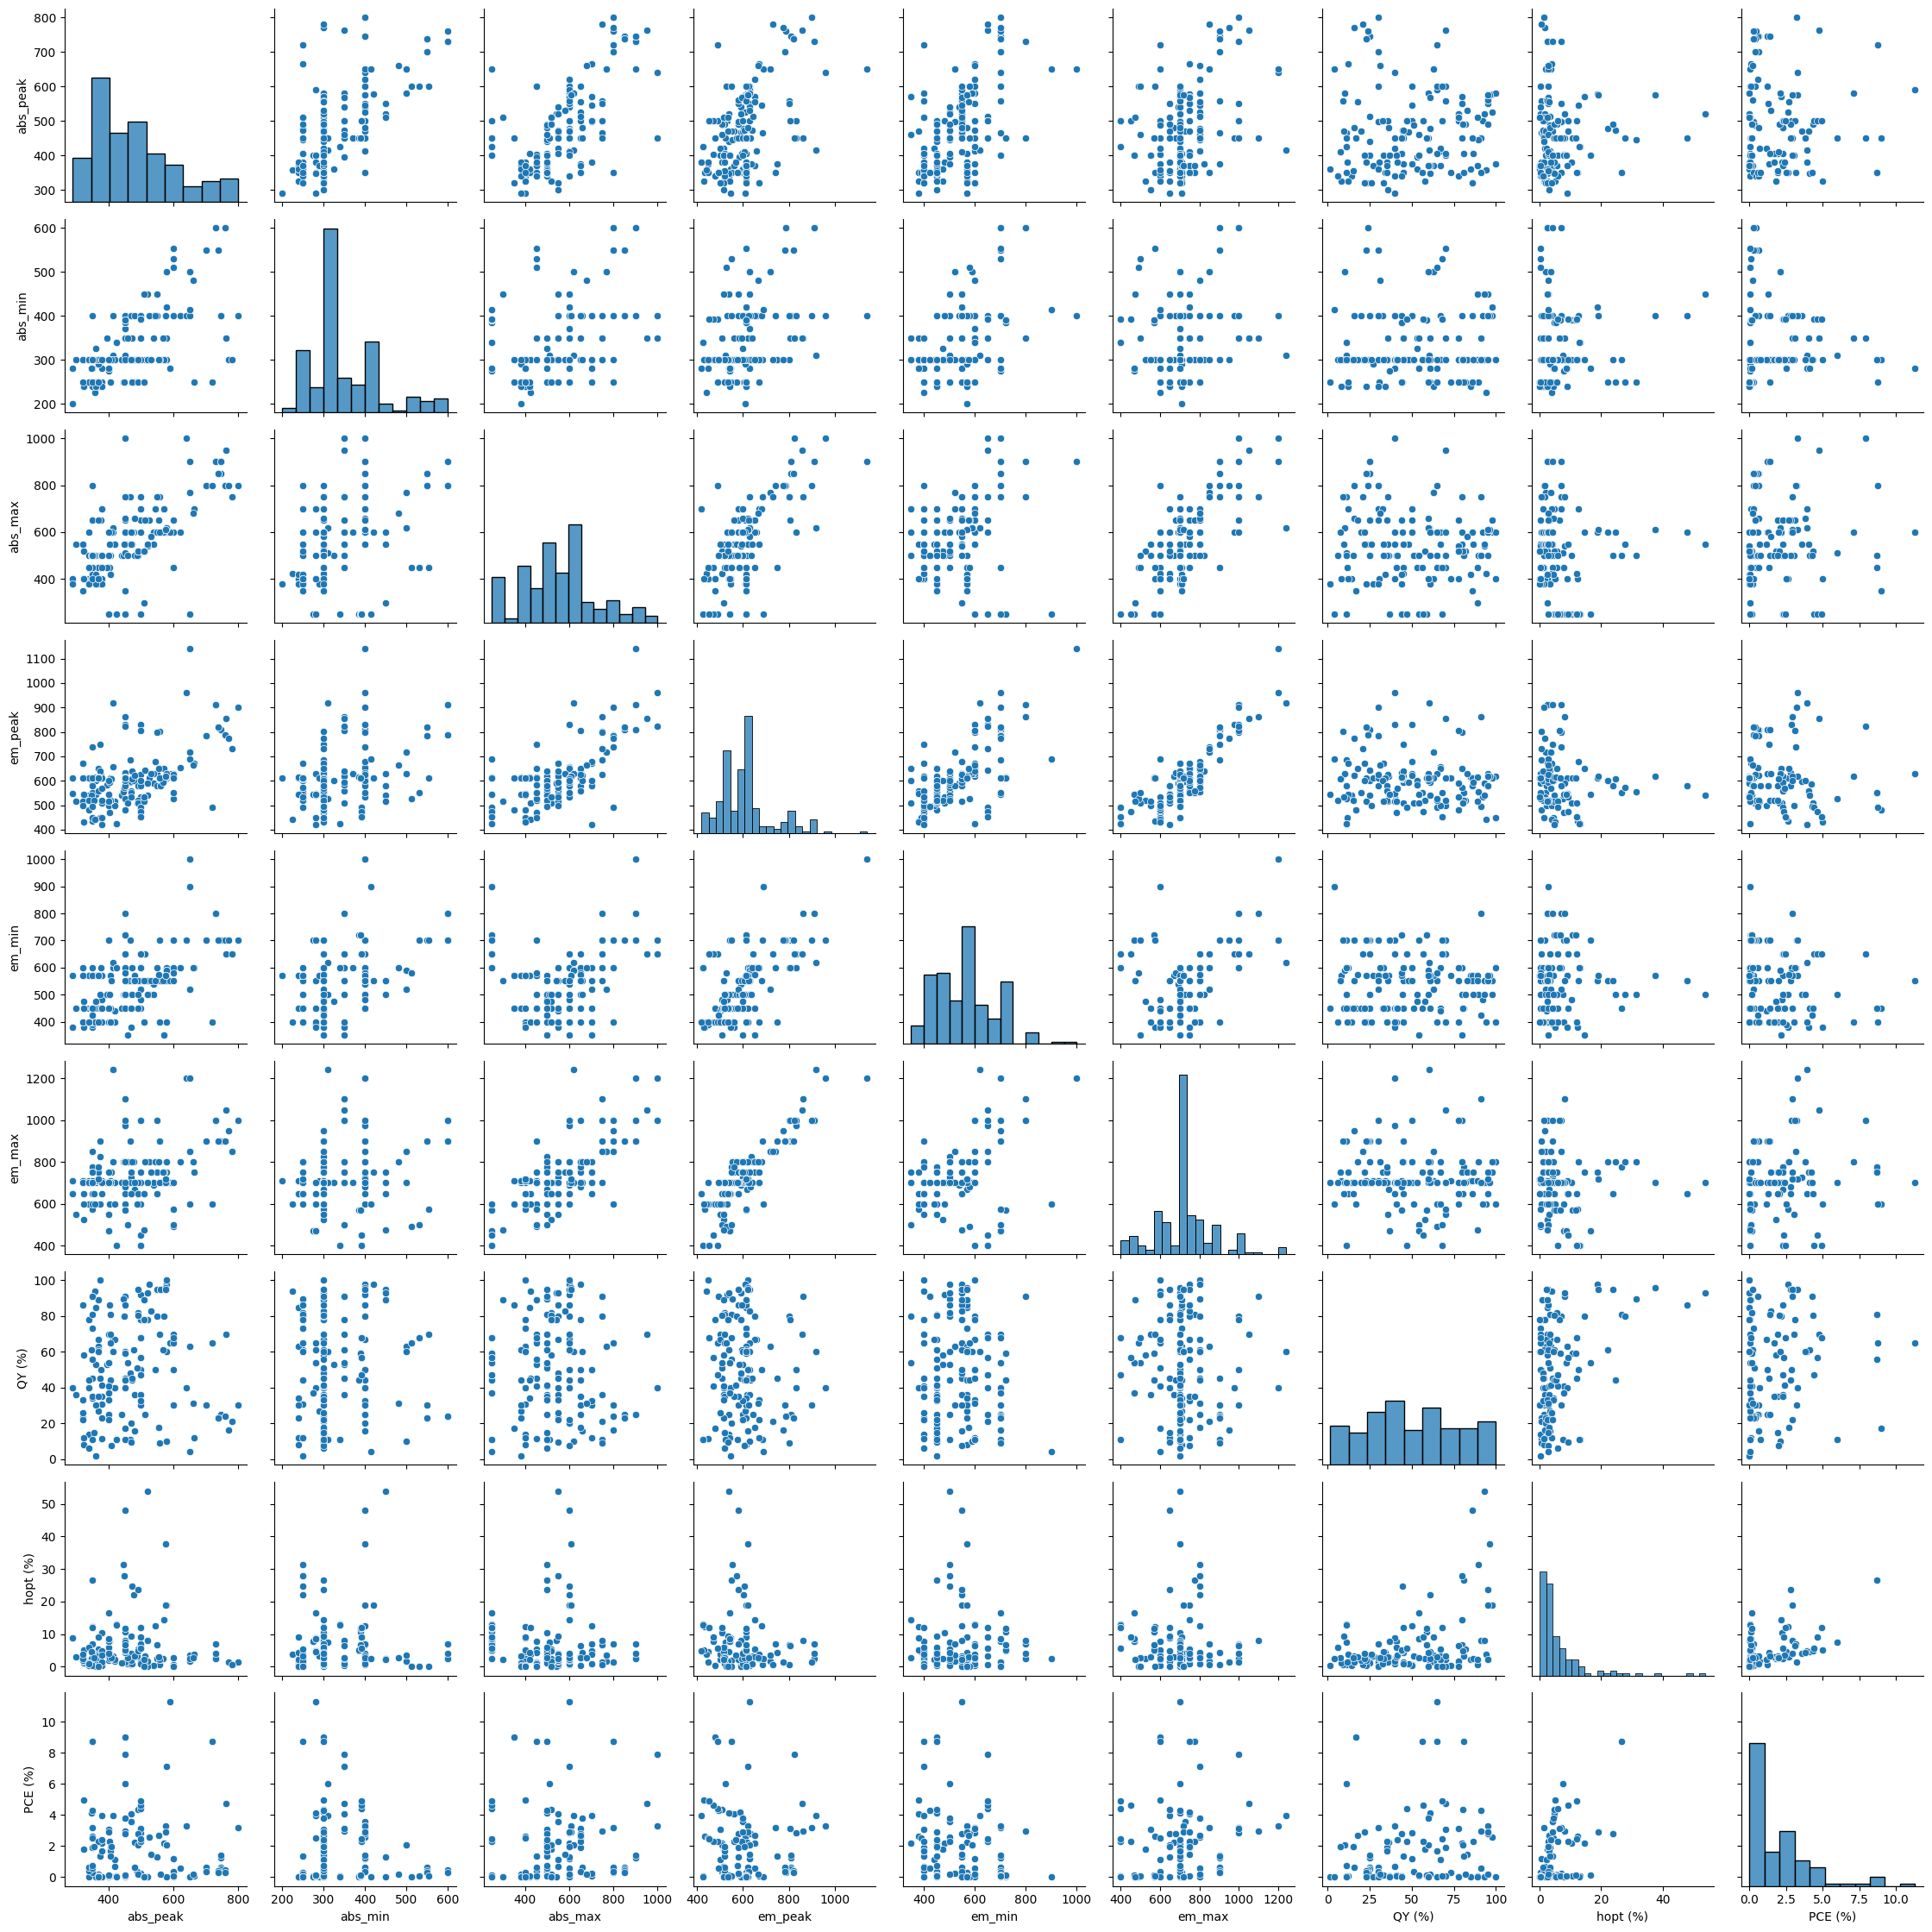

In [17]:
sns.pairplot(df.to_pandas())
fig = plt.gcf()
fig.savefig(f'figures/pairplot.pdf', bbox_inches='tight')
plt.show()

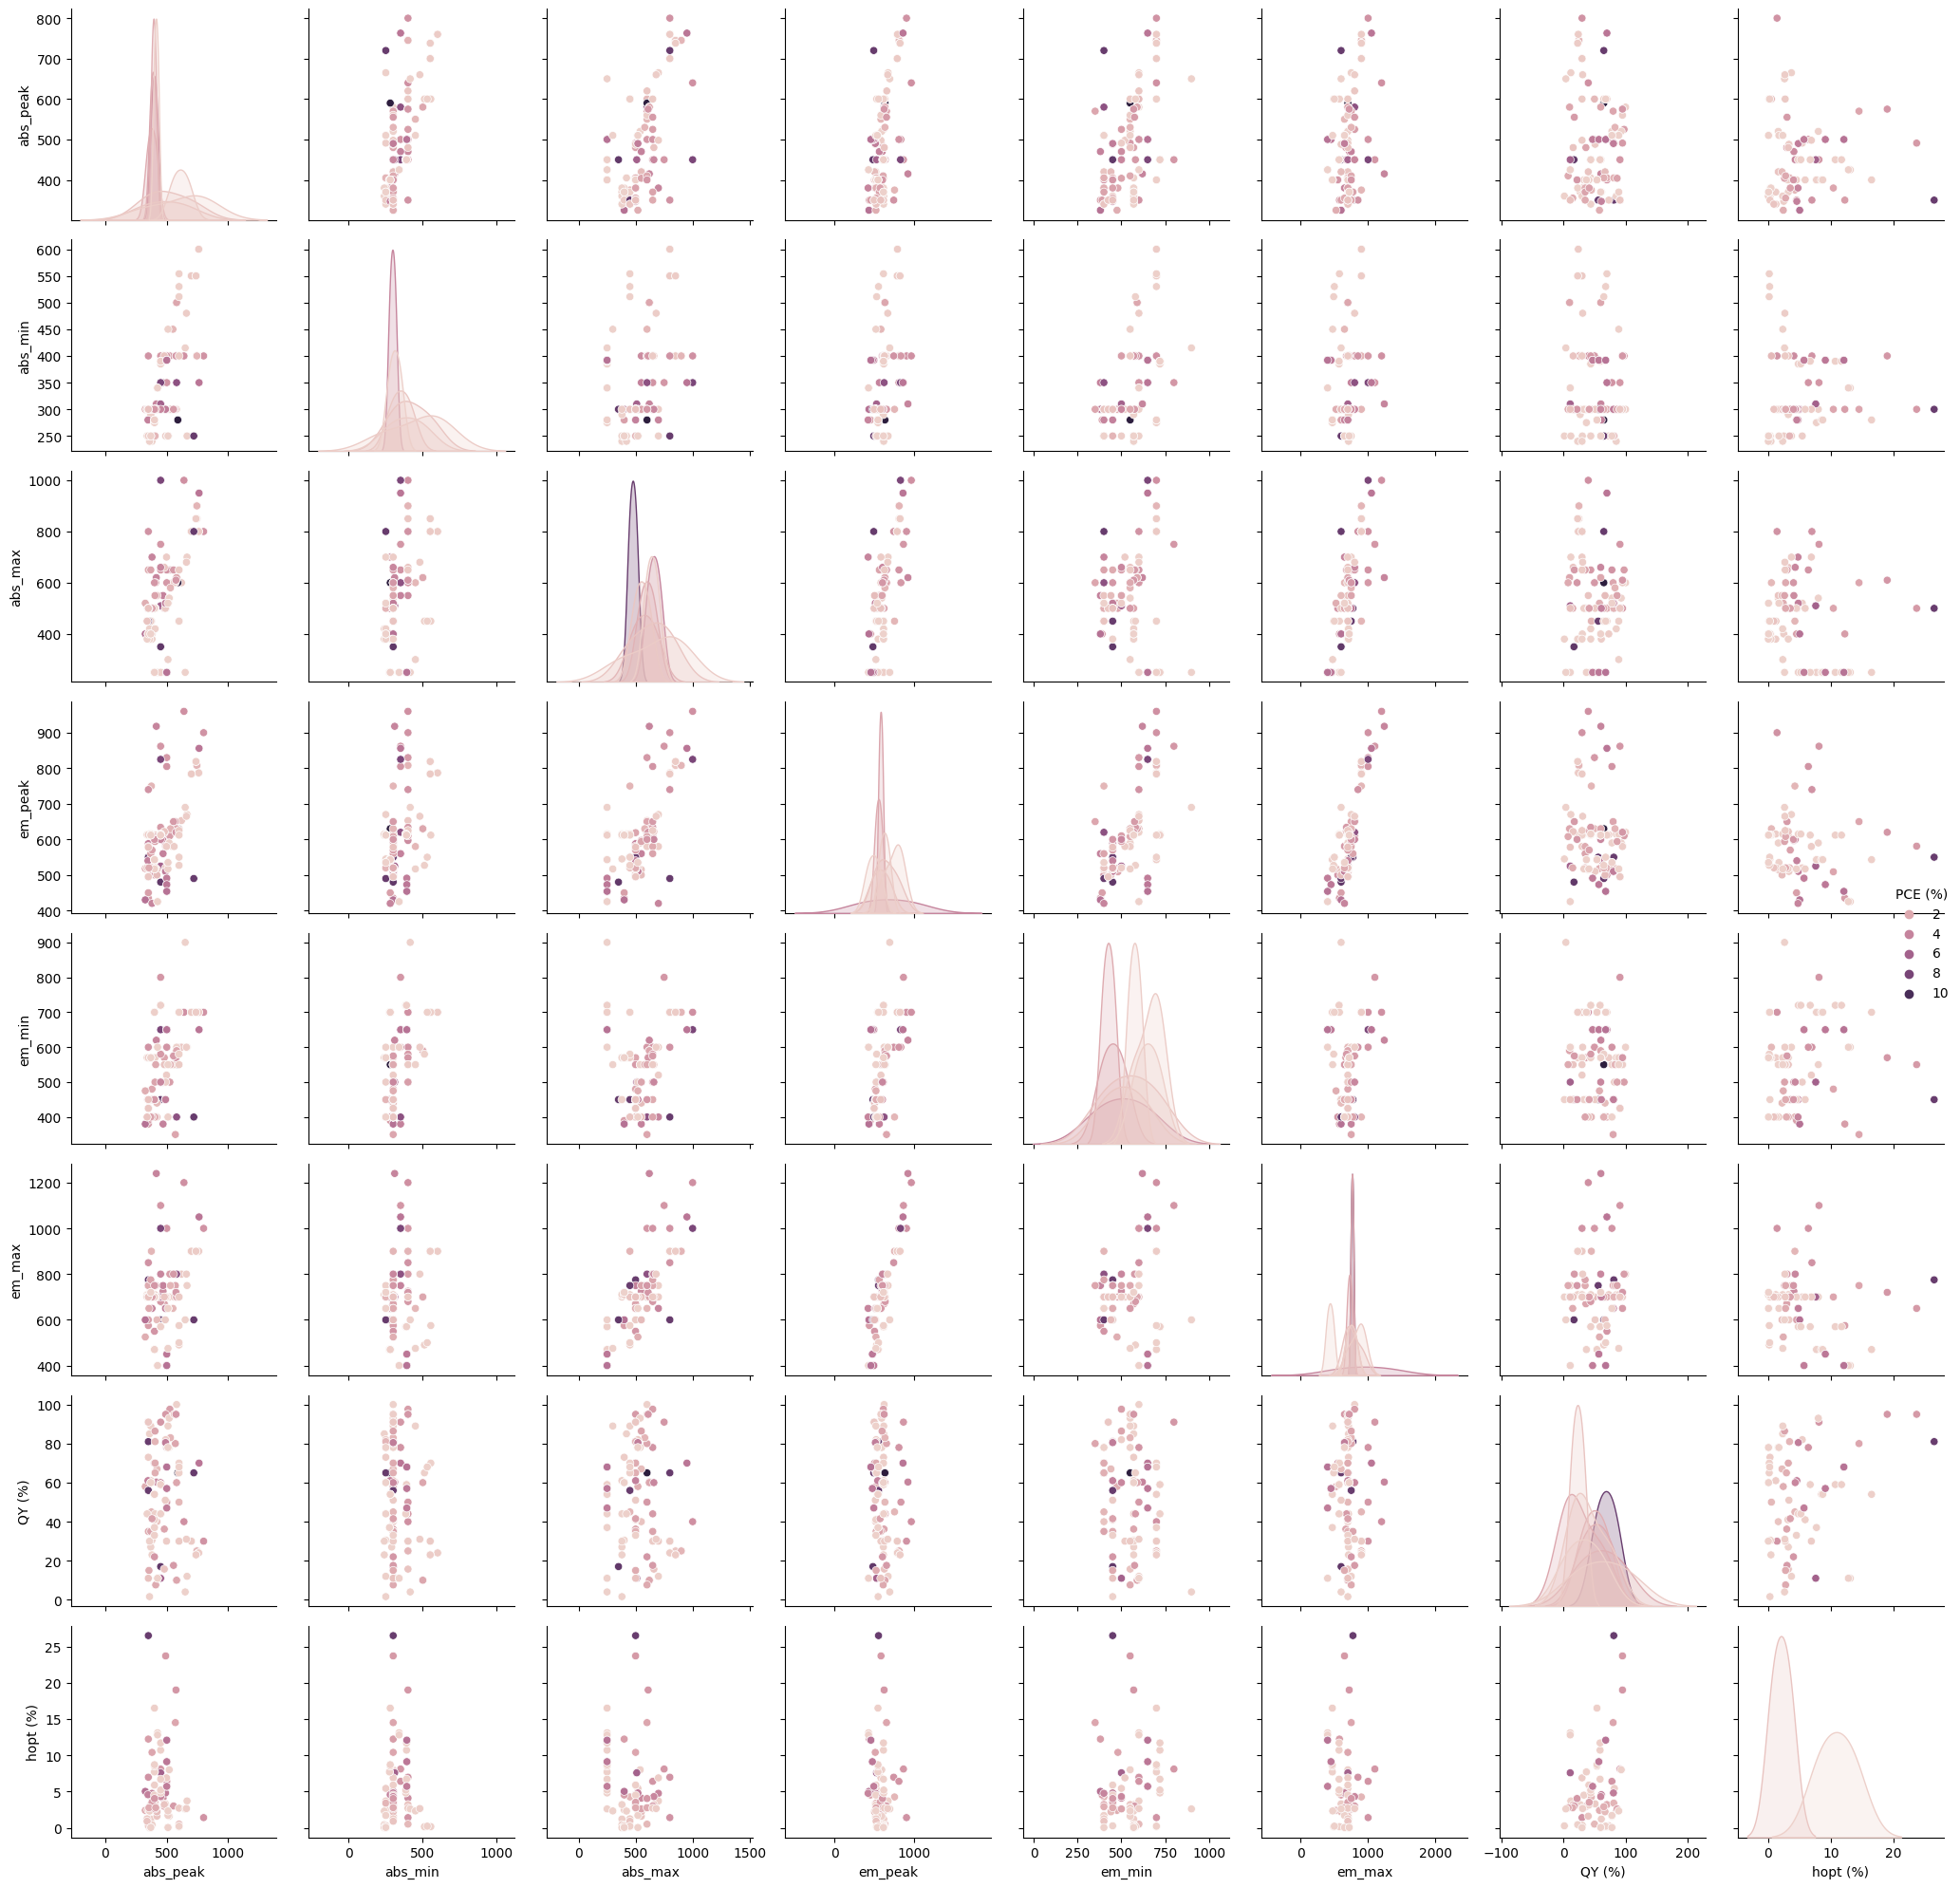

In [18]:
sns.pairplot(df.to_pandas(), hue='PCE (%)')
plt.show()

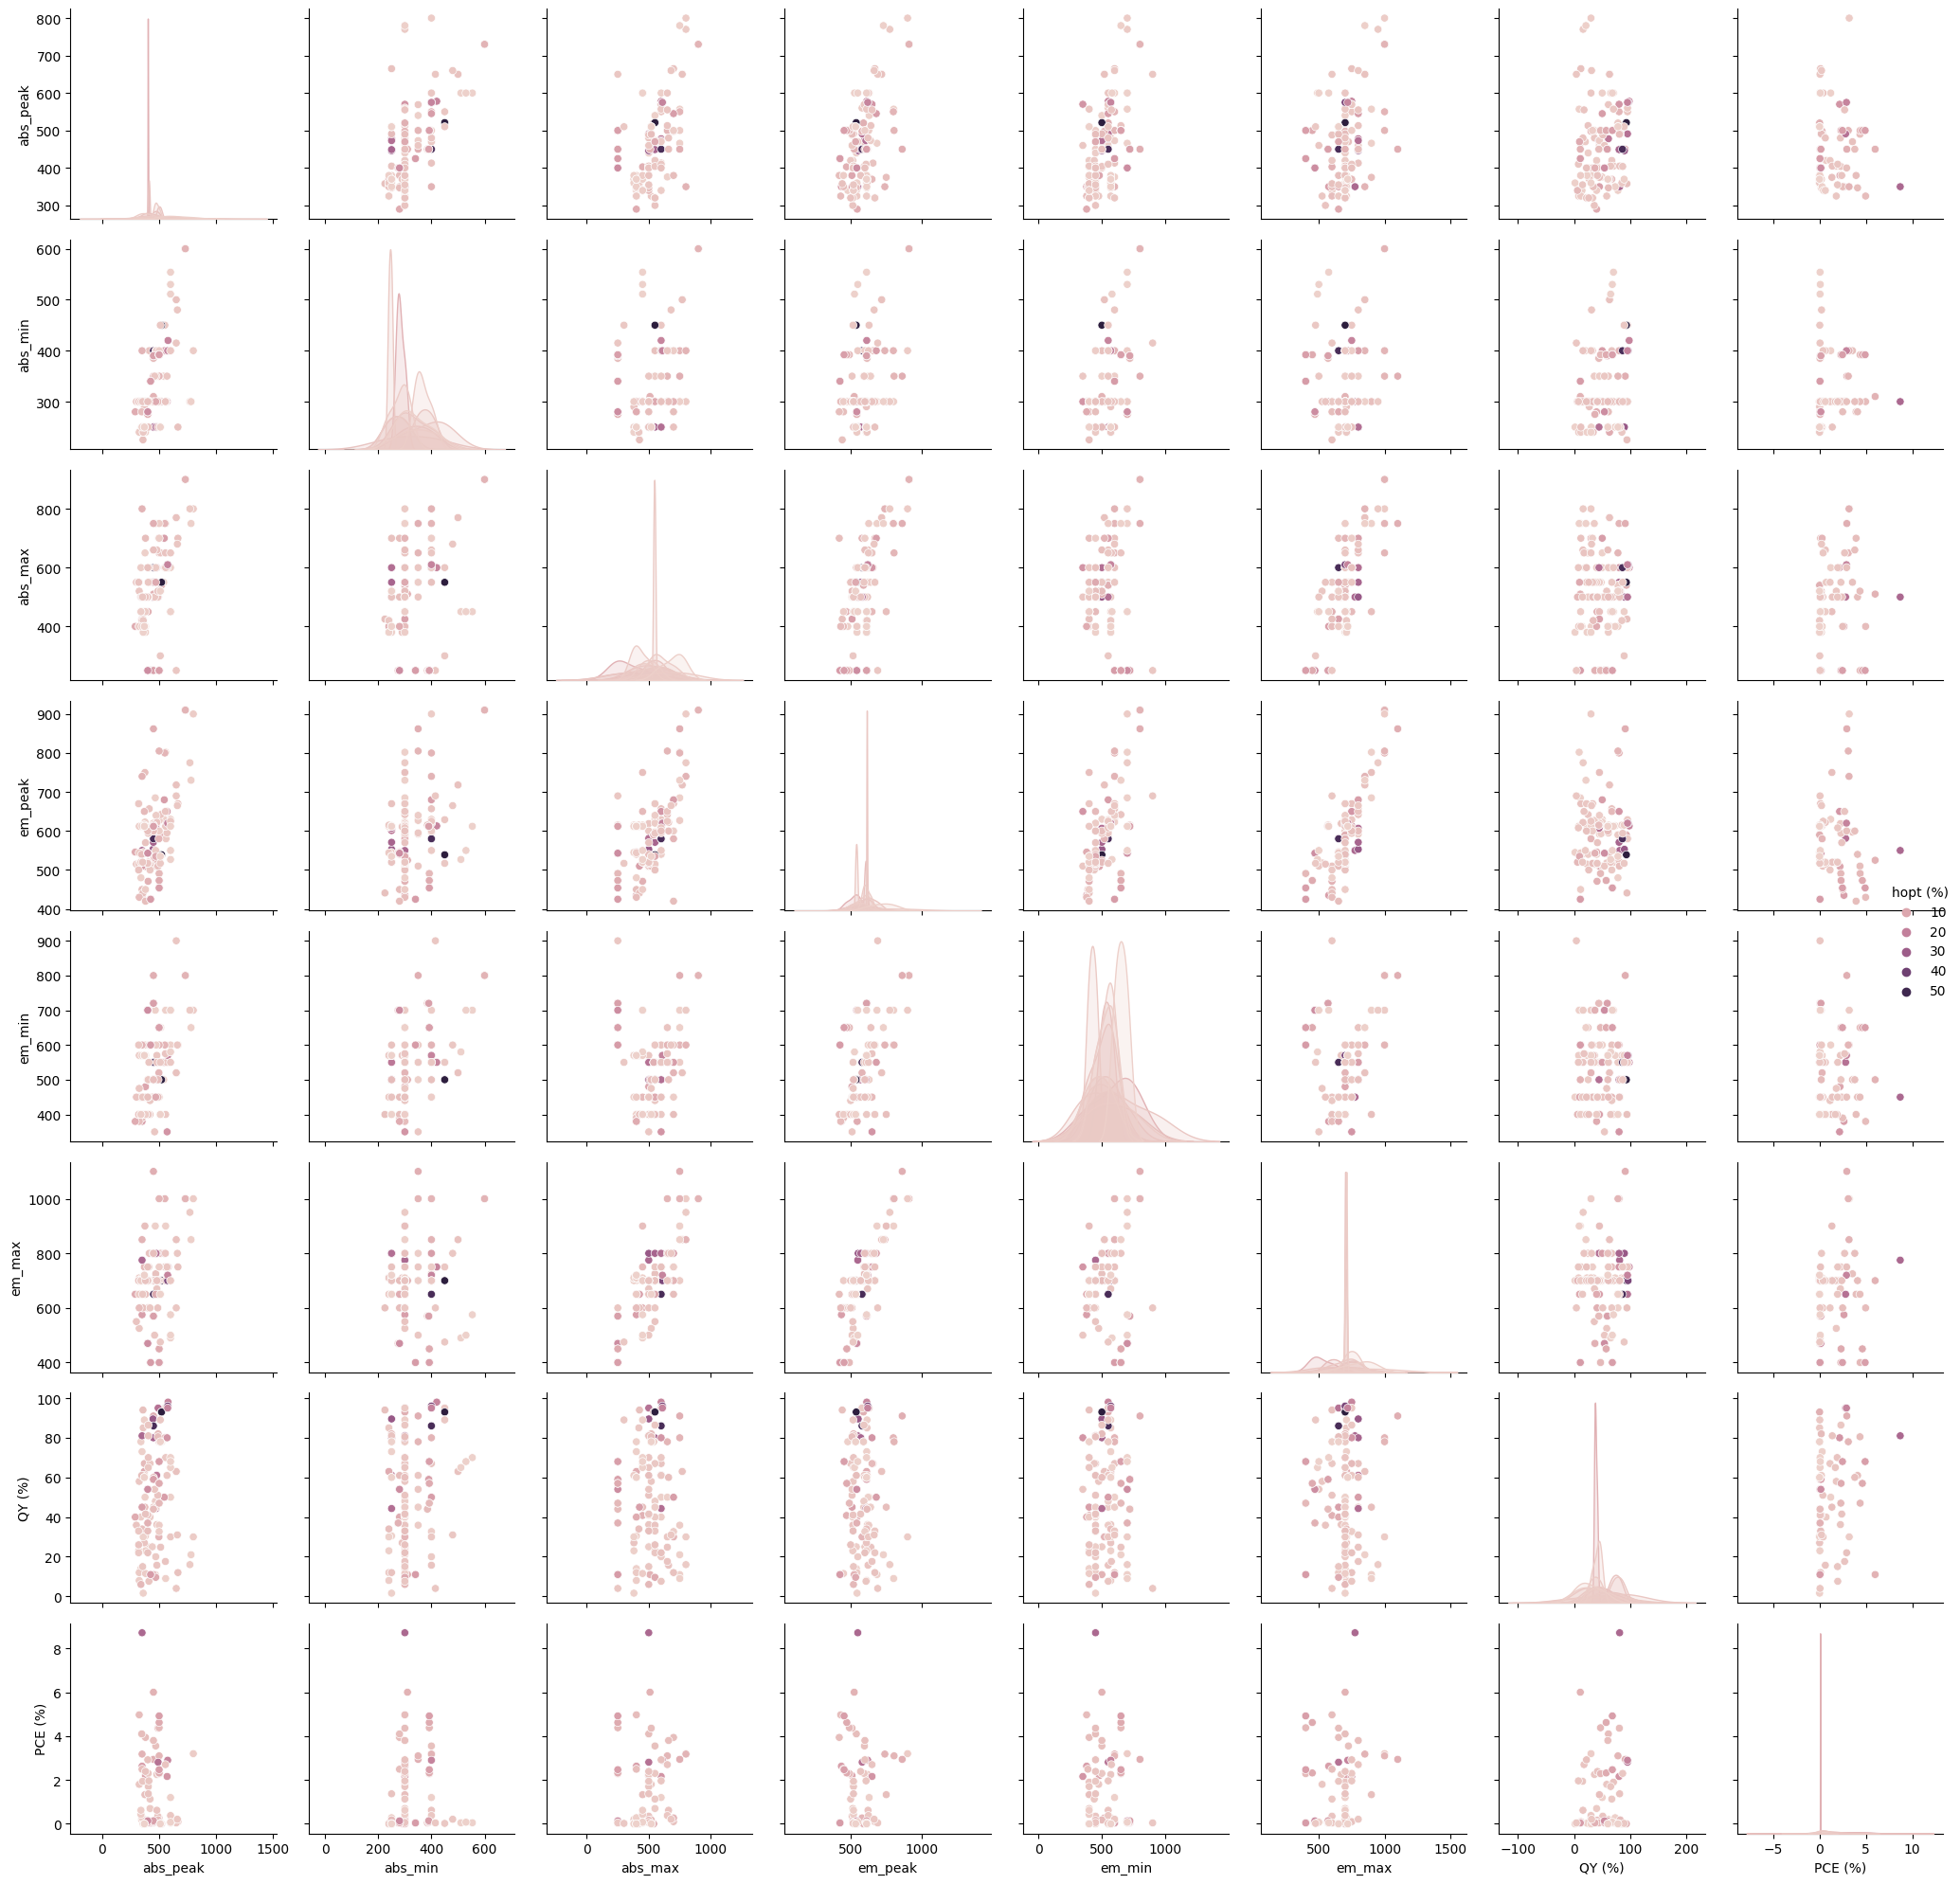

In [19]:
sns.pairplot(df.to_pandas(), hue='hopt (%)')
plt.show()

In [136]:
def idx_to_rowcol(idx, width):
    r = int(idx / width)
    c = int(idx % width)
    return (r,c)


def rowcol_to_idx(r,c, width):
    idx = int((r * width) + c)
    return idx


def describe_variables(df, categorical=['mat0', 'mat1'], cols=4, figsize=(20,15), filename=None, box=True):
    # get the pandas dataframe (since polars does not allow plots)
    df_pandas = df.to_pandas()
    for col in categorical:
        df_pandas[col] = df_pandas[col].astype('category')
    
    # compute the number of rows
    if box:
        total = (2 * len(df.get_columns())) - len(categorical)
    else:
        total = len(df.get_columns())
    rows = math.ceil(total/cols)
    fig, axes = plt.subplots(rows, cols, constrained_layout = True, figsize=figsize)
    #print(f'Total {total} -> ({rows} {cols})')
    
    idx = 0
    for col in df.get_columns():
        r, c = idx_to_rowcol(idx, cols)
        #print(f'({col.name}: {idx} -> {r}, {c})')
        sns.histplot(ax=axes[r, c], data=df_pandas, x=col.name)
        idx += 1
        if col.name not in categorical:
            r, c = idx_to_rowcol(idx, cols)
            #print(f'({col.name}: {idx} -> {r}, {c})')
            if box:
                sns.boxplot(ax=axes[r, c], data=df_pandas, x=col.name)
                idx += 1
    if isinstance(filename, str):
        fig_store = plt.gcf()
        fig_store.savefig(f'figures/{filename}.pdf', bbox_inches='tight')
        fig_store.savefig(f'figures/{filename}.png', bbox_inches='tight')
    plt.show()

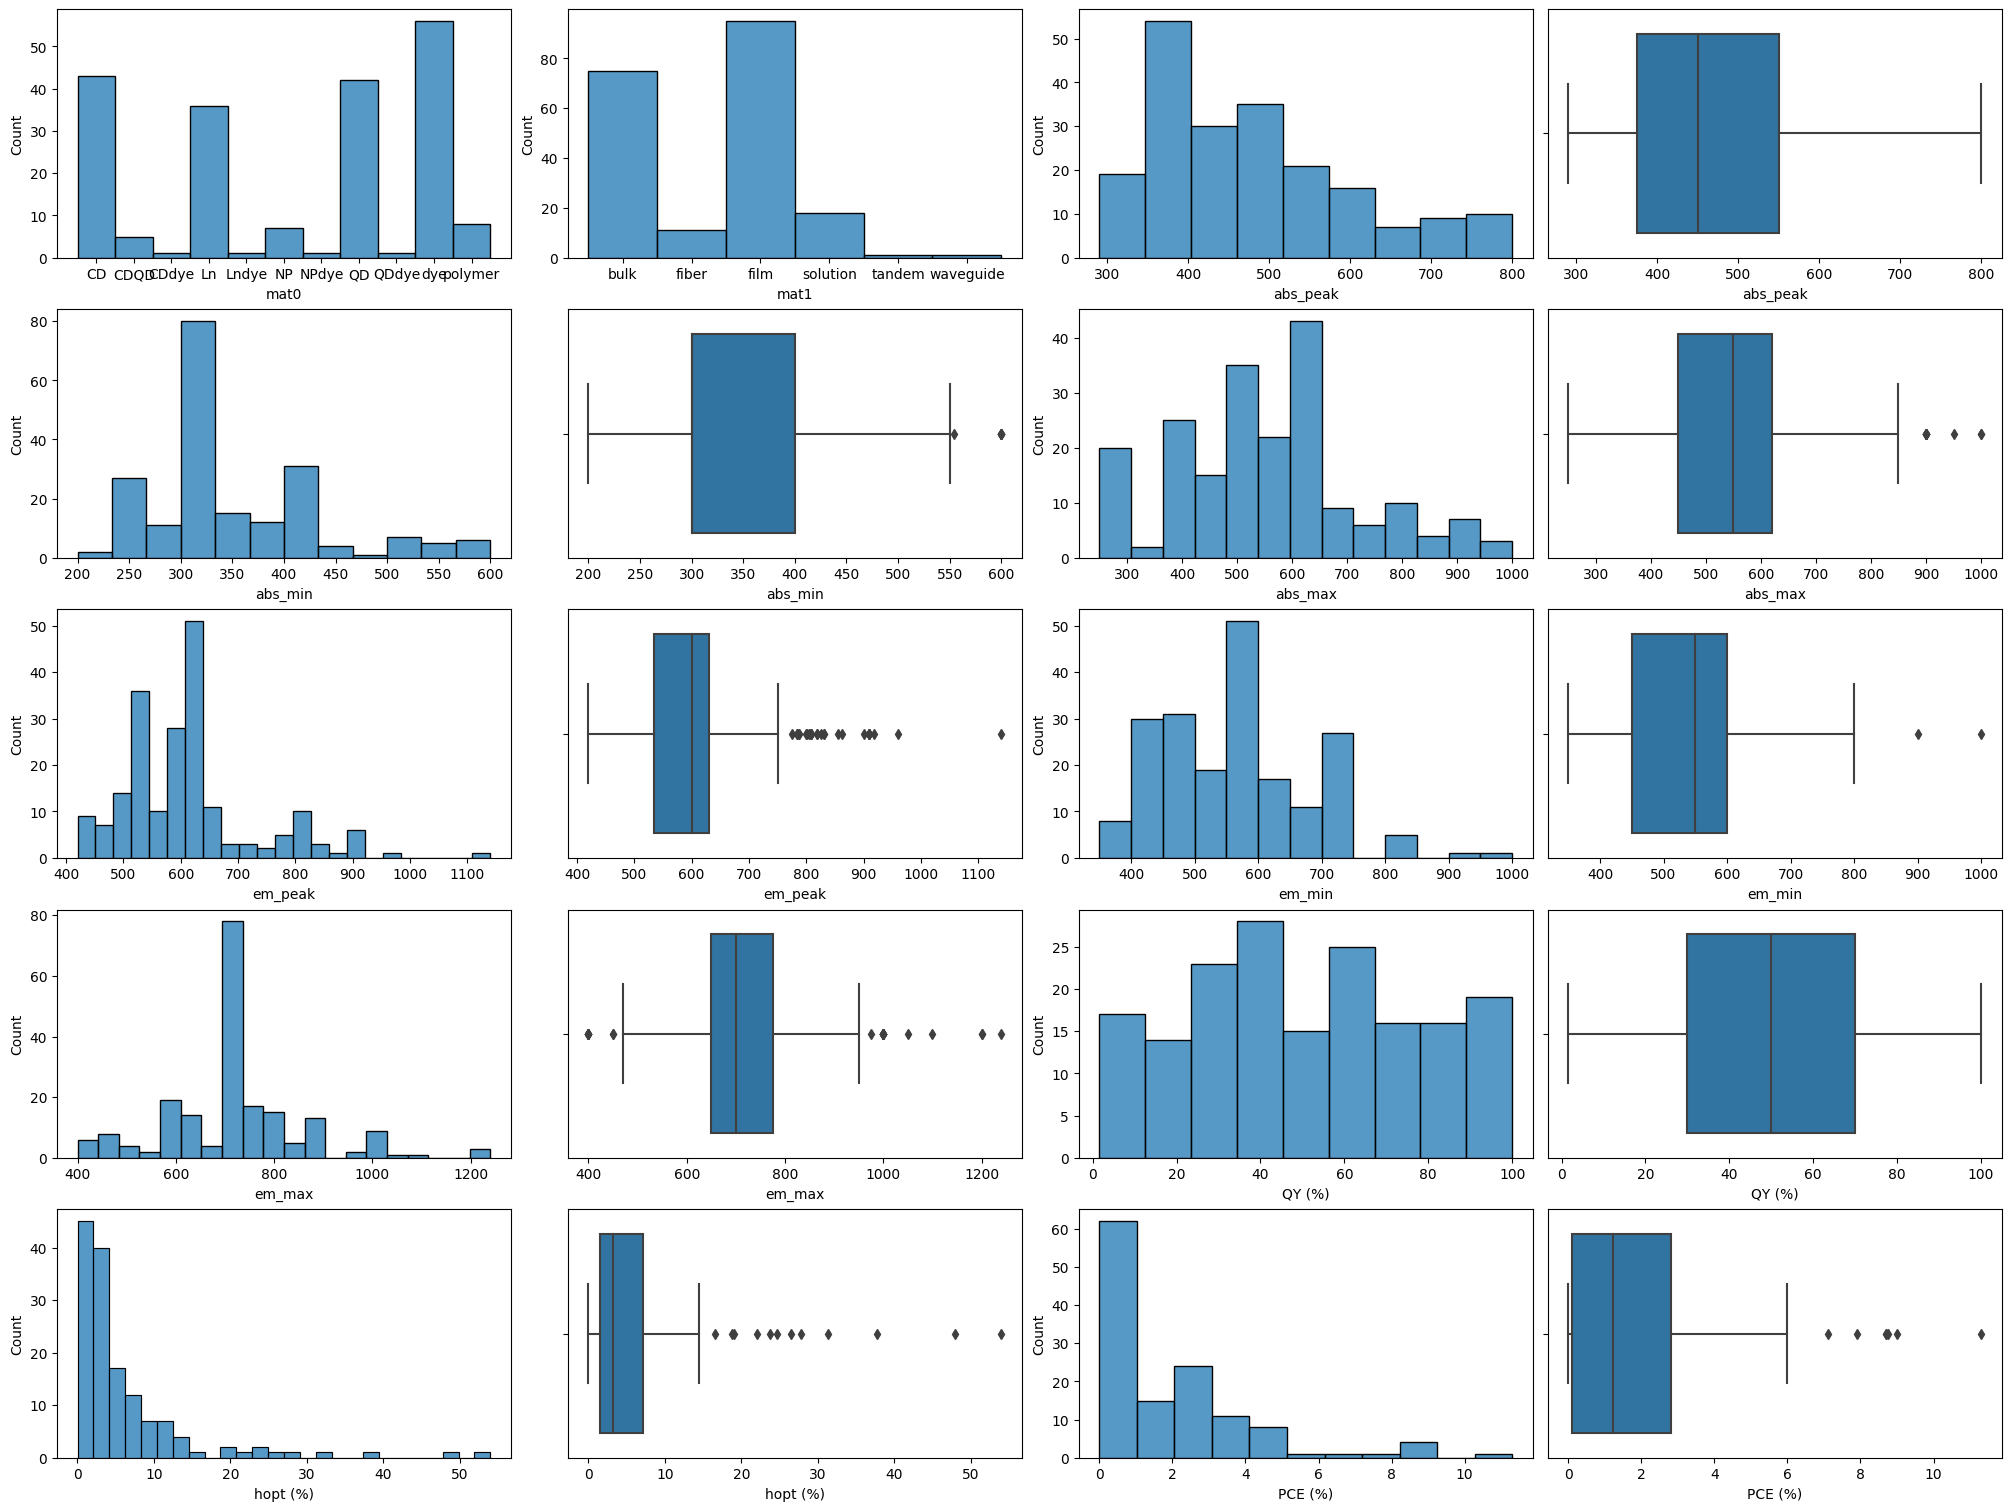

In [94]:
describe_variables(df, filename='feaures_description')

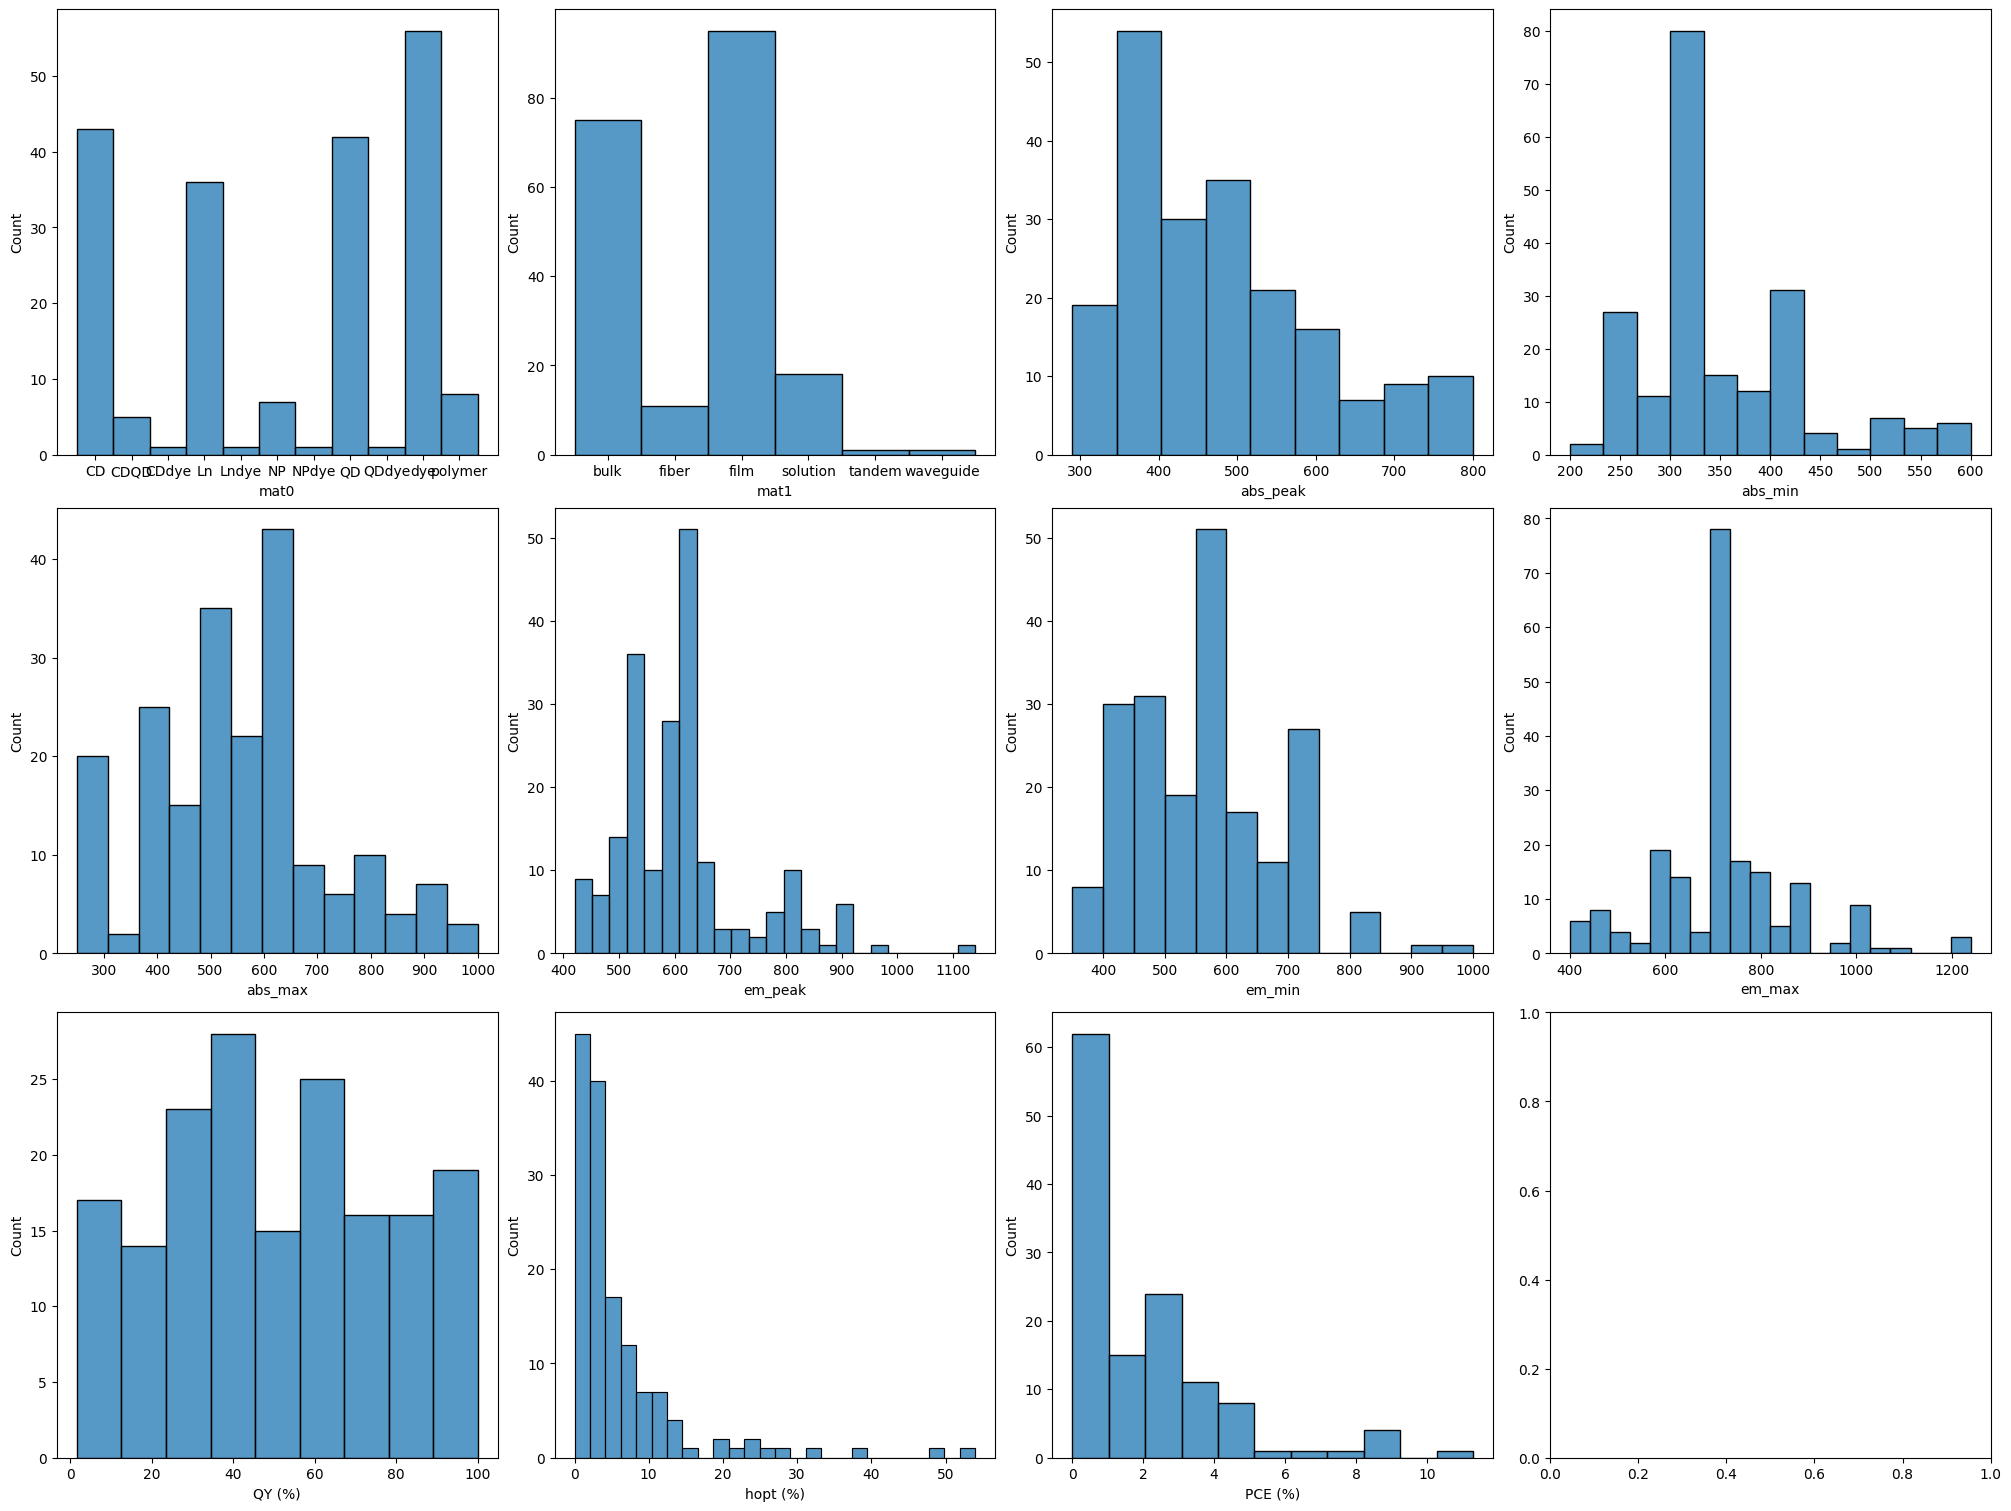

In [22]:
describe_variables(df, filename='feaures_description_no_box', box=False)

In [3]:
def print_missing_samples(df):
    print(f'Shape: {df.shape}')
    total, _ = df.shape
    for col in df.get_columns():
        print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

In [24]:
print_missing_samples(df)

Shape: (201, 11)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 14%
hopt (%): 28%
PCE (%): 36%


## PCE and hopt prediction

### Baseline (using only abs and em)

In [25]:
df_baseline_PCE = df.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_baseline_PCE)

Shape: (128, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


In [26]:
df_baseline_hopt = df.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_baseline_hopt)

Shape: (144, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


In [27]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# TODO: fix this
# Print Models parameters
models = [('Linear Regression', LinearRegression(), {}),
          ('K Neighbors', KNeighborsRegressor(),
           {'reg__n_neighbors':[1,3,5,7,9], 'reg__weights':['uniform', 'distance'], 'reg__p':[1,2]}),
          ('Random Forest', RandomForestRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200], 'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__bootstrap':[True, False], 'reg__max_depth':max_depth}),
          ('Gradient Boosting', GradientBoostingRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200],'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__max_depth':max_depth}),
         ('XGBoost', xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
          {'reg__max_depth': range (2, 10, 1), 'reg__n_estimators': range(60, 220, 40), 'reg__learning_rate': [0.1, 0.01, 0.05]})]

# remove heavy models that do not perform that well
#('Lasso Regression', Lasso(max_iter=5000, tol=1E-2, random_state=42), {'alpha': (np.logspace(-8, 8, 20))}),
#('Support Vector Regressor', SVR(),{'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],'kernel': ['linear','rbf', 'sigmoid']}),
#('ANN', MLPRegressor(max_iter=50000,  tol=1E-3, random_state=42),{'hidden_layer_sizes':[(8,), (16,), (32,)],'activation':['relu','logistic'], 'learning_rate':['constant', 'invscaling', 'adaptive']}),

In [28]:
def create_folds(X, y, b='auto', k=5):
    if isinstance(b, str):
        bins = np.histogram_bin_edges(y, bins=b)
        # remove the last index (end point)
        bins = bins[:-1]
    elif isinstance(b, int):
        bins = np.linspace(min(y), max(y), num=b, endpoint=False)
    else:
        raise Exception(f'Undefined bins {b}')
        
    #print(f'Bins: {bins}')
    groups = np.digitize(y, bins)
    #print(f'Group: {groups}')
    skf = StratifiedKFold(n_splits=k)
    return skf.split(X, groups)

In [29]:
from collections.abc import Iterable

def compute_performance(models, X, y, b=None, k=[5, 3], filename=None):
    if isinstance(k, Iterable):
        outer_k = k[0]
        inner_k = k[1]
    elif isinstance(k, int):
        outer_k = k
        inner_k = k
    else:
        raise Exception(f'Undefined k {k}')

    #kf = KFold(n_splits=cv)
    folds = create_folds(X, y, b=b, k=outer_k)
    
    perf_per_model = {}
    y_true = []
    y_true_train = []
    y_preds = {}
    y_preds_train = {}
    #for train_index, test_index in kf.split(X):
    for train_index, test_index in folds:
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
        y_true.extend(y_test)
        y_true_train.extend(y_train)
    
        # optimize each model and store the best result
        best_models = []
        for _, model, params in models:
            pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid_folds = create_folds(X_train, y_train, b=b, k=inner_k)
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='r2', n_jobs=-1)
            clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
            clf.fit(X_train, y_train)
            best_models.append(clf.best_estimator_)

        # compute the predictions and store the results
        for i in range(len(models)):
            model = best_models[i]
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            if models[i][0] not in y_preds:
                y_preds[models[i][0]] = []
            
            if models[i][0] not in y_preds_train:
                y_preds_train[models[i][0]] = []
            
            y_preds[models[i][0]].extend(y_pred)
            y_preds_train[models[i][0]].extend(y_pred_train)
            
            score_mae_test = mean_absolute_error(y_test, y_pred)
            score_mse_test = mean_squared_error(y_test, y_pred)
            score_r2_test = r2_score(y_test, y_pred)
            
            score_mae_train = mean_absolute_error(y_train, y_pred_train)
            score_mse_train = mean_squared_error(y_train, y_pred_train)
            score_r2_train = r2_score(y_train, y_pred_train)
            
            if models[i][0] not in perf_per_model:
                perf_per_model[models[i][0]] = {'train':{'mae':[], 'mse': [], 'r2':[]},
                                                'test':{'mae':[], 'mse': [], 'r2':[]}}
            
            perf_per_model[models[i][0]]['test']['mae'].append(score_mae_test)
            perf_per_model[models[i][0]]['test']['mse'].append(score_mse_test)
            perf_per_model[models[i][0]]['test']['r2'].append(score_r2_test)
            
            perf_per_model[models[i][0]]['train']['mae'].append(score_mae_train)
            perf_per_model[models[i][0]]['train']['mse'].append(score_mse_train)
            perf_per_model[models[i][0]]['train']['r2'].append(score_r2_train)
            
    # print the results
    print(f'Train')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['train']['mae']
        mse = perf_per_model[models[i][0]]['train']['mse']
        r2  = perf_per_model[models[i][0]]['train']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()
    
    print(f'Test')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['test']['mae']
        mse = perf_per_model[models[i][0]]['test']['mse']
        r2  = perf_per_model[models[i][0]]['test']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()

    # plot the graphs
    print(f'Train')
    data_train = []
    labels_train = []
    for name, _, _ in models:
        labels_train.append(name)

        # DEBUG STUFF:
        #score_mae = mean_absolute_error(y_true_train, y_preds_train[name])
        #score_mse = mean_squared_error(y_true_train, y_preds_train[name])
        #score_r2 = r2_score(y_true_train, y_preds_train[name])
        #print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_train.append(np.abs(np.subtract(y_true_train, y_preds_train[name])))
    ax = sns.violinplot(data=data_train)
    ax.set_xticklabels(labels_train)
    if isinstance(filename, str):
        fig = plt.gcf()
        fig.savefig(f'figures/{filename}_train.pdf', bbox_inches='tight')
    plt.show()

    print(f'Test')
    data_preds = []
    labels_preds = []
    for name, _, _ in models:
        labels_preds.append(name)

        # DEBUG STUFF:
        #score_mae = mean_absolute_error(y_true, y_preds[name])
        #score_mse = mean_squared_error(y_true, y_preds[name])
        #score_r2 = r2_score(y_true, y_preds[name])
        #print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_preds.append(np.abs(np.subtract(y_true, y_preds[name])))
    ax = sns.violinplot(data=data_preds)
    ax.set_xticklabels(labels_preds)
    if isinstance(filename, str):
        fig = plt.gcf()
        fig.savefig(f'figures/{filename}_test.pdf', bbox_inches='tight')
    plt.show()
    
    # convert best_models to a dict and return it
    bm = {}
    for name, model, params in models:
        # train on whole dataset
        pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
        #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_folds = create_folds(X, y, b=b, k=inner_k)
        clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
        clf.fit(X, y)
        bm[name] = clf.best_estimator_
    
    return bm

PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.53 |   4.39 |   0.13 |
| K Neighbors       |   0.22 |   0.46 |   0.91 |
| Random Forest     |   0.85 |   1.95 |   0.61 |
| Gradient Boosting |   0.25 |   0.26 |   0.95 |
| XGBoost           |   0.76 |   1.56 |   0.69 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.66 |   5.15 |  -0.01 |
| K Neighbors       |   1.31 |    4.1 |    0.2 |
| Random Forest     |   1.28 |   4.04 |   0.25 |
| Gradient Boosting |    1.3 |   4.42 |   0.16 |
| XGBoost           |   1.32 |   4.26 |    0.2 |

Train


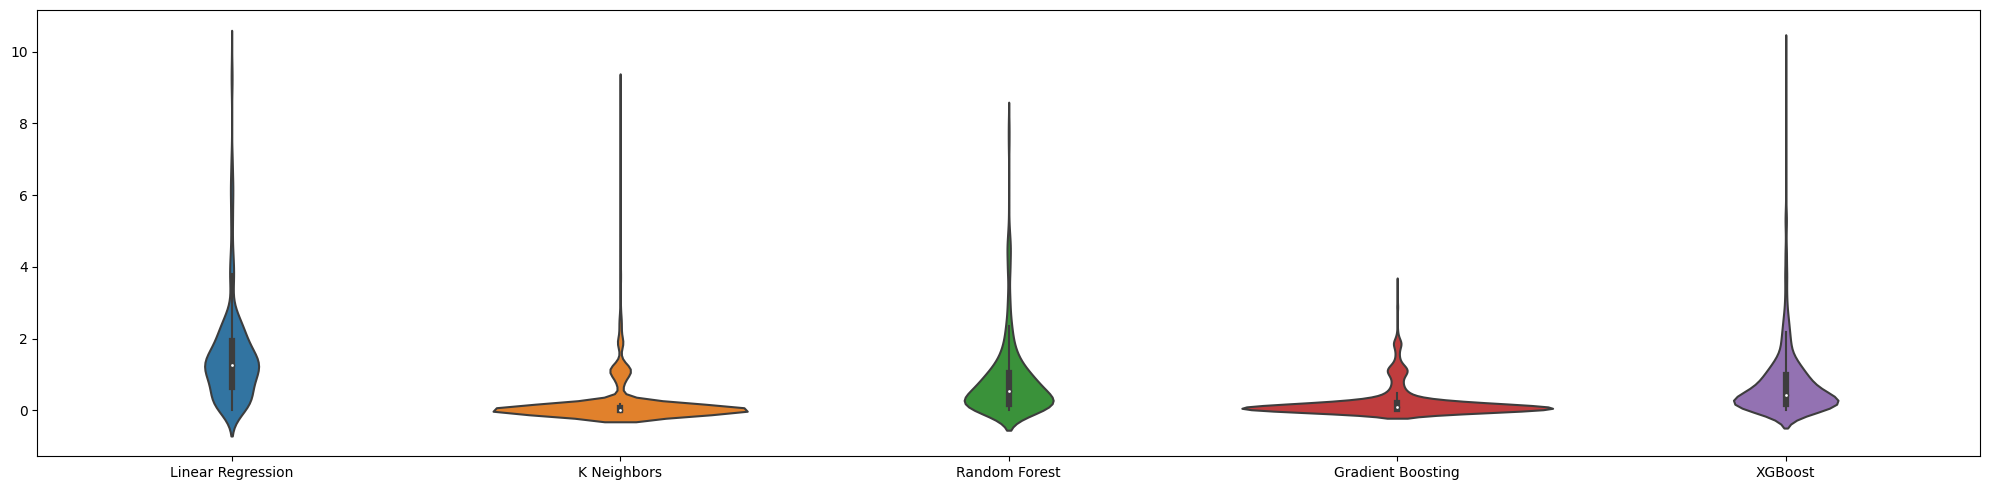

Test


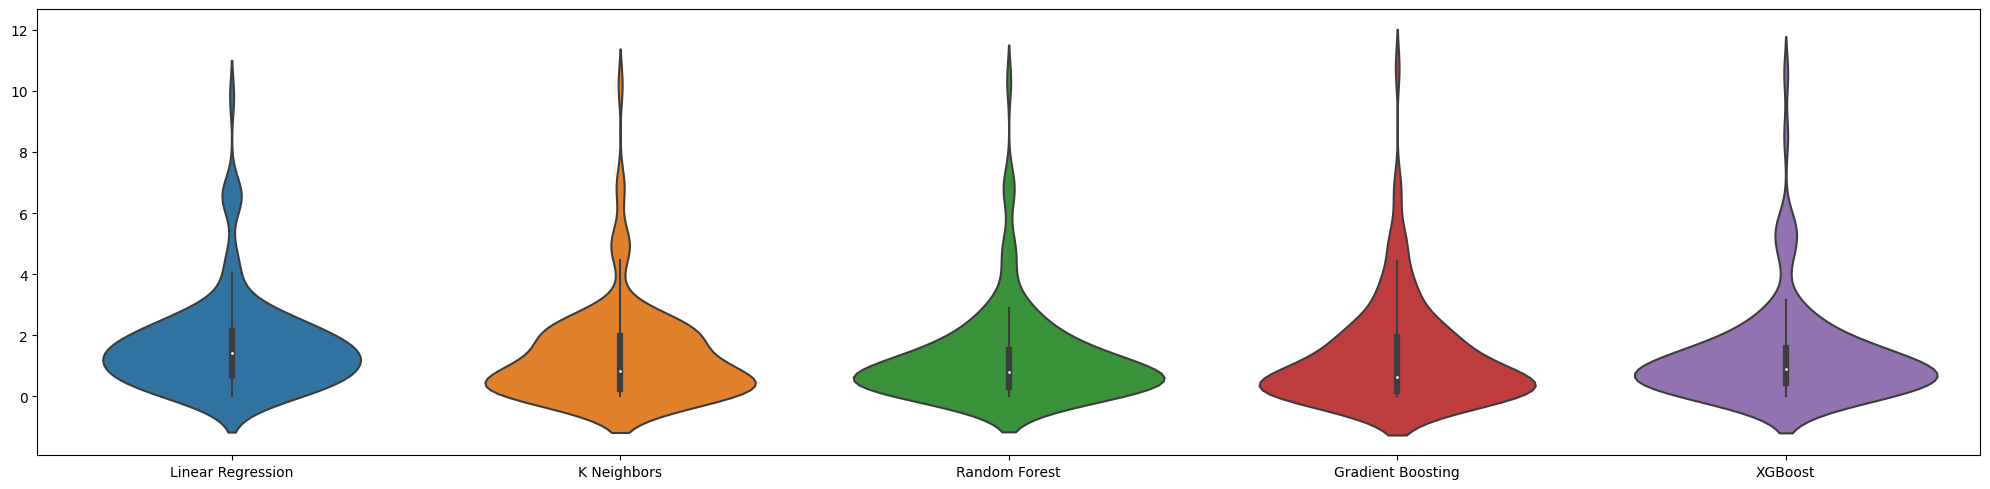

In [30]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]
#print(f'{y_PCE} {y_PCE.shape}')

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()
#print(f'{X} {X.shape}')

## PCE
print(f'PCE')
models_pce_baseline = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_baseline')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.14 |  65.18 |   0.07 |
| K Neighbors       |   0.98 |   8.88 |   0.87 |
| Random Forest     |   3.09 |  28.37 |    0.6 |
| Gradient Boosting |   1.13 |   4.37 |   0.94 |
| XGBoost           |   3.82 |  49.78 |    0.3 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.71 |  75.71 |  -0.15 |
| K Neighbors       |   4.69 |  62.34 |  -0.05 |
| Random Forest     |   5.19 |  68.62 |  -0.12 |
| Gradient Boosting |   4.76 |  67.24 |  -0.28 |
| XGBoost           |   4.54 |  66.16 |   0.02 |

Train


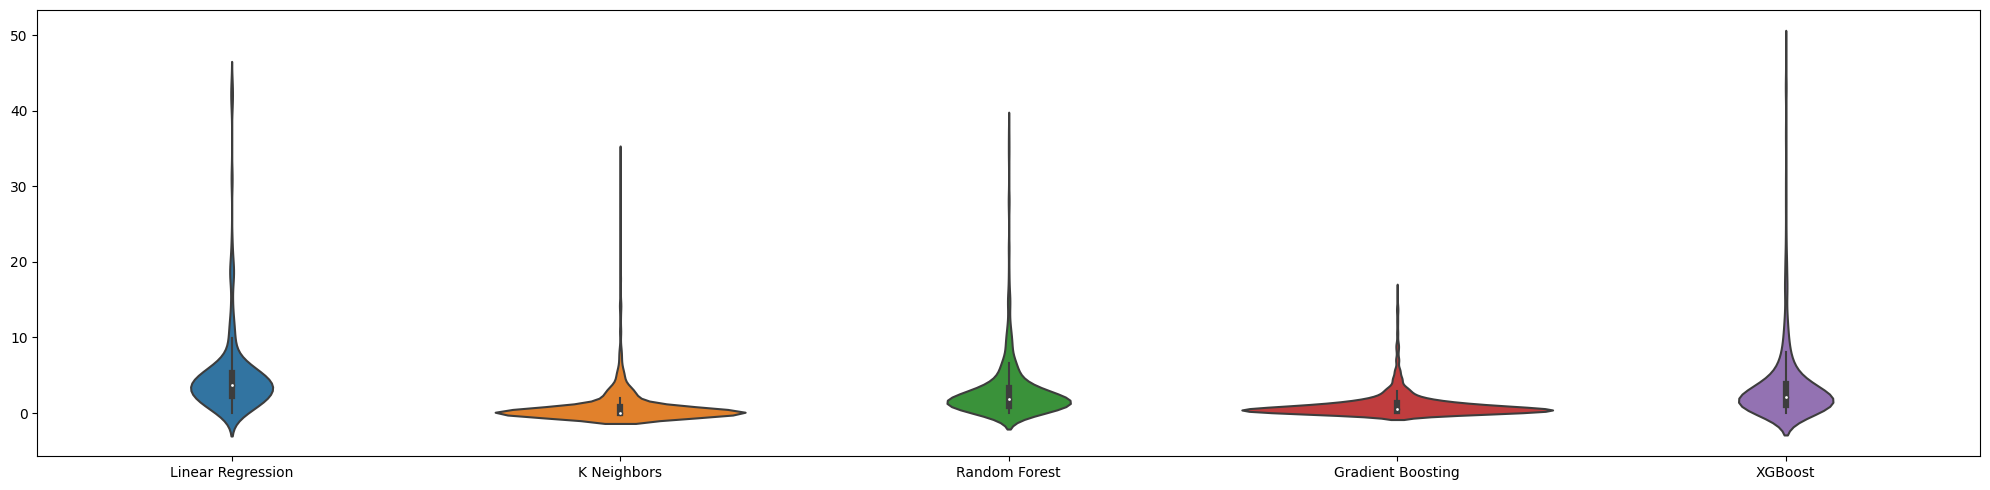

Test


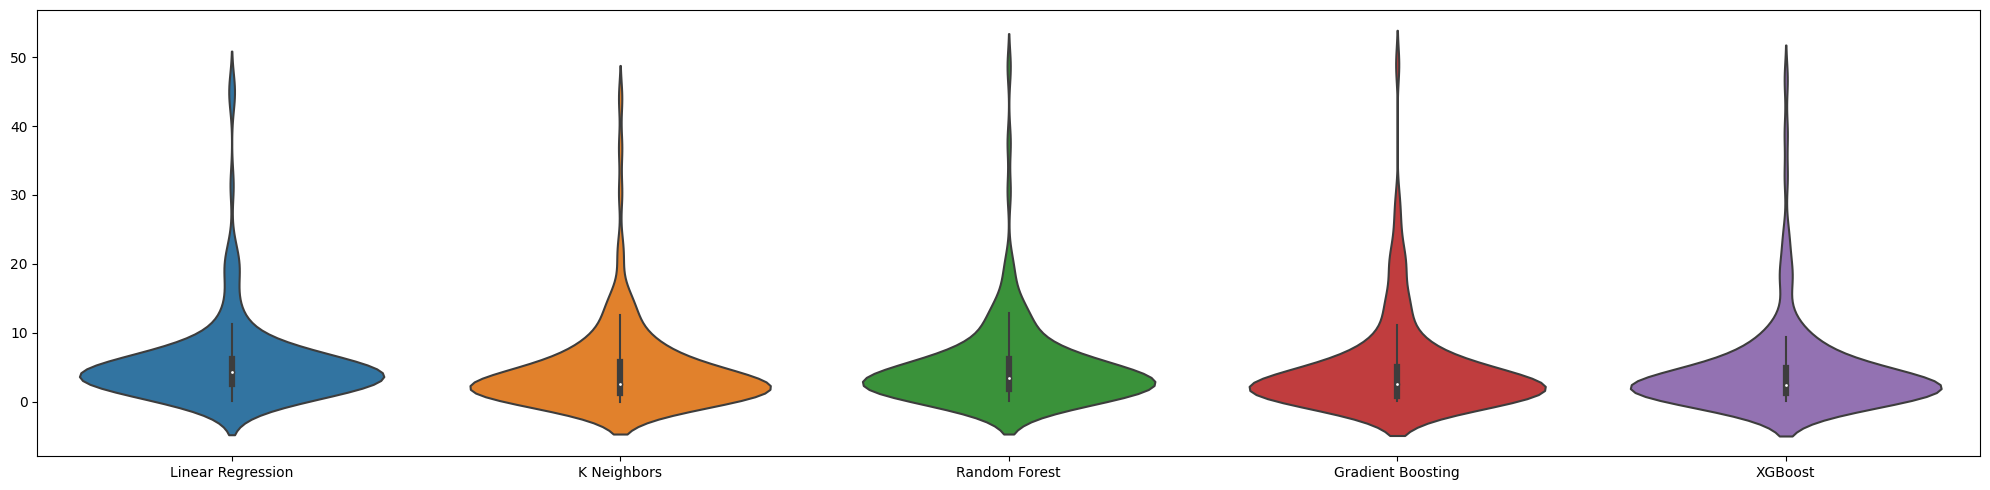

In [31]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_hopt_baseline = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_baseline')

### Baseline + QY

In [32]:
df_02_PCE = df.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_02_PCE)

Shape: (112, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [33]:
df_02_hopt = df.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_02_hopt)

Shape: (129, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.48 |   4.21 |   0.13 |
| K Neighbors       |   0.12 |   0.15 |   0.97 |
| Random Forest     |   0.78 |   1.78 |   0.63 |
| Gradient Boosting |   0.26 |   0.28 |   0.94 |
| XGBoost           |   1.01 |   2.76 |   0.42 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.64 |   4.99 |  -0.17 |
| K Neighbors       |   1.11 |    3.8 |   0.17 |
| Random Forest     |   1.32 |   4.37 |  -0.23 |
| Gradient Boosting |   1.44 |   5.48 |  -0.64 |
| XGBoost           |   1.43 |   5.41 |  -0.32 |

Train


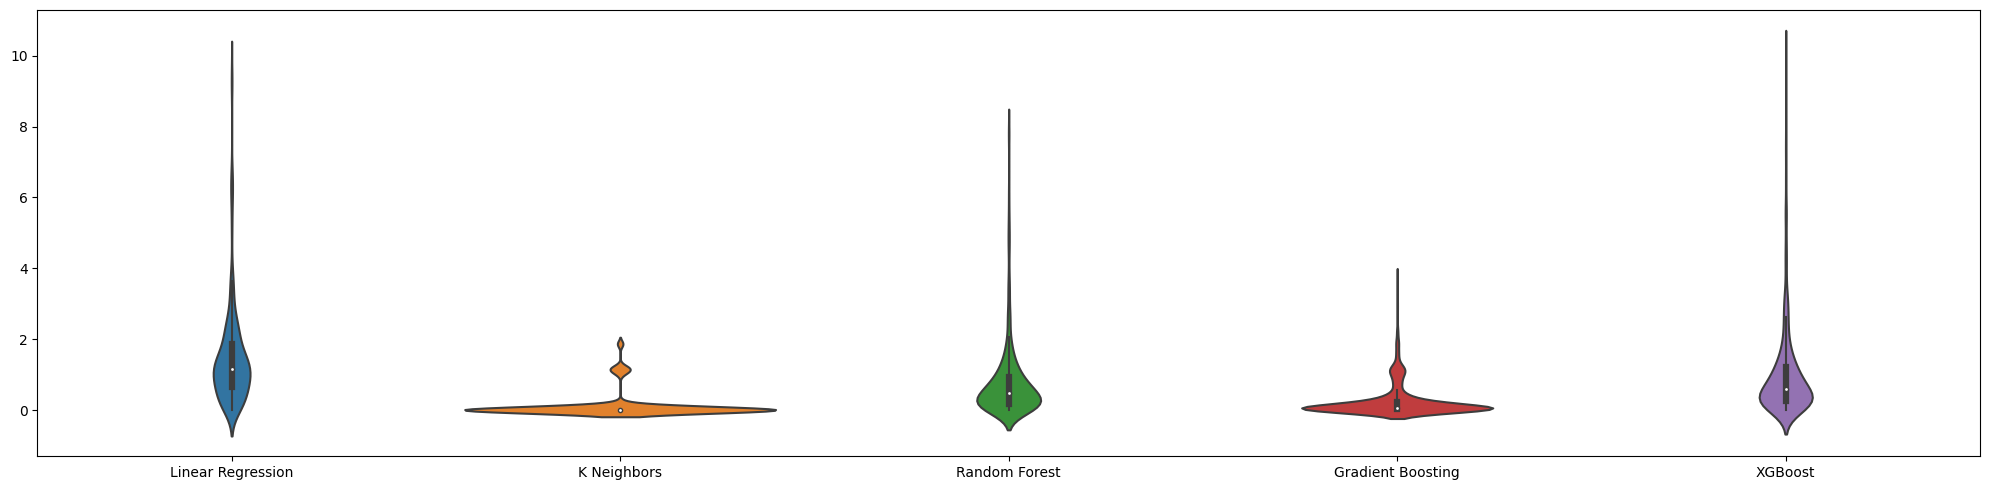

Test


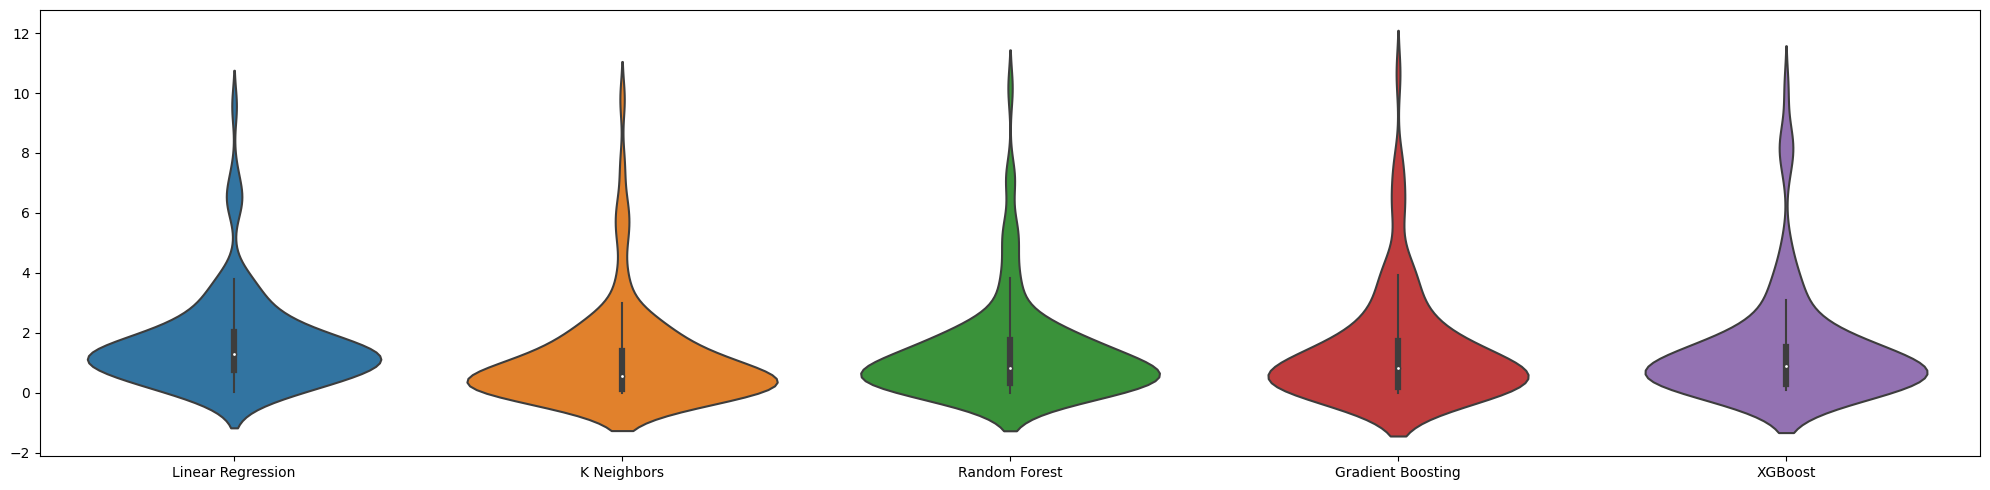

In [34]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_02_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_qy')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.25 |  62.42 |   0.18 |
| K Neighbors       |   2.38 |  23.96 |   0.68 |
| Random Forest     |   3.43 |  36.95 |   0.52 |
| Gradient Boosting |    0.8 |   3.32 |   0.95 |
| XGBoost           |   3.37 |  37.93 |   0.51 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.86 |  73.91 |  -0.39 |
| K Neighbors       |   4.56 |  50.99 |  -0.01 |
| Random Forest     |   4.97 |  64.28 |  -0.26 |
| Gradient Boosting |   4.95 |  70.14 |  -0.62 |
| XGBoost           |   4.21 |   63.4 |  -0.04 |

Train


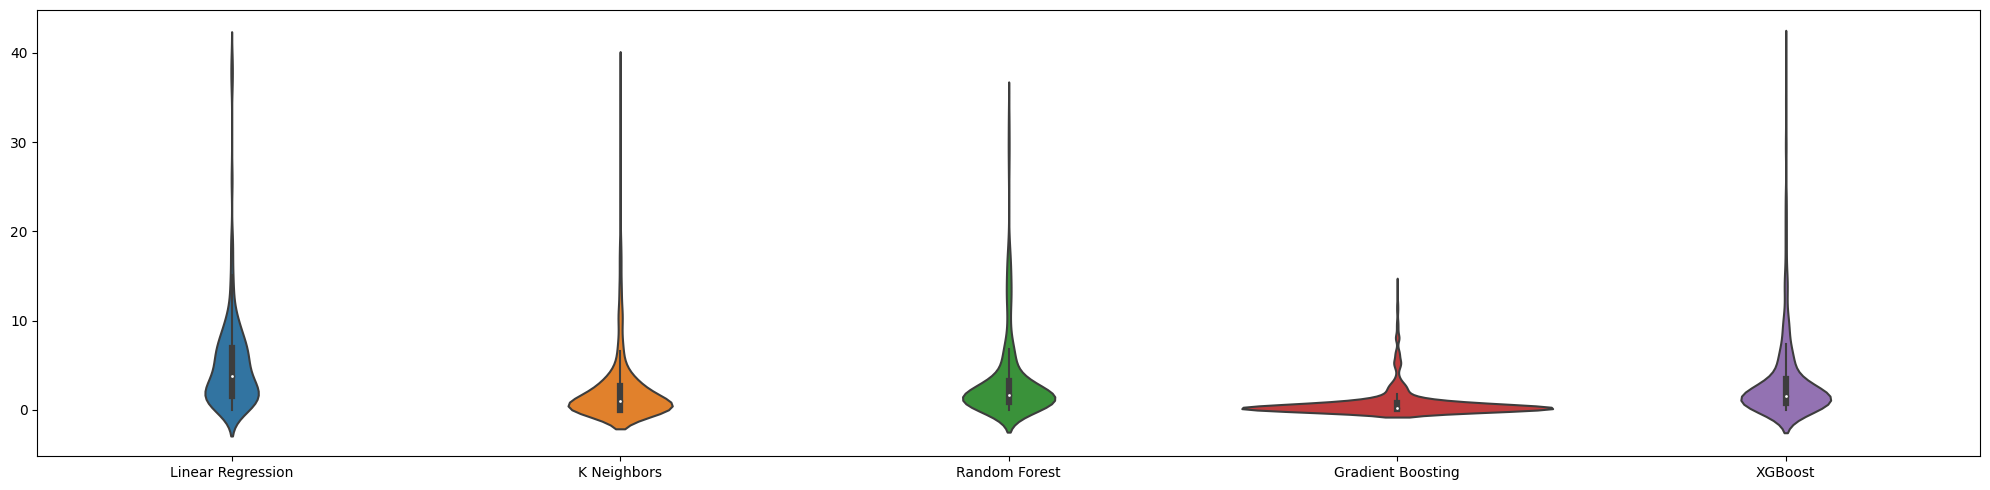

Test


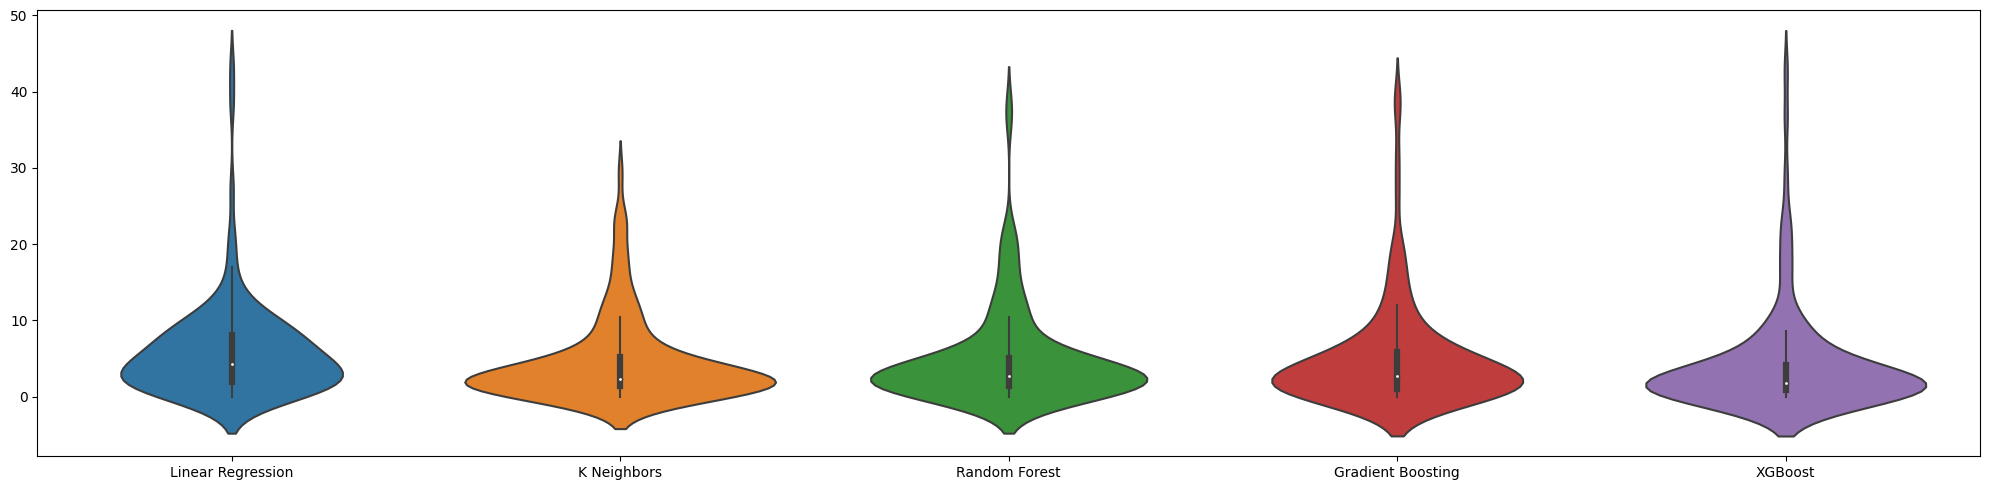

In [35]:
# Get Output variables
hopt = df_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_02_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_qy')

### Baseline + QY + Categorical (Mat0 and Mat1)

In [36]:
df_03_PCE = df.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_03_PCE)

Shape: (112, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [37]:
df_03_hopt = df.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_03_hopt)

Shape: (129, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.17 |   3.16 |   0.34 |
| K Neighbors       |   0.12 |   0.15 |   0.97 |
| Random Forest     |   0.79 |   1.82 |   0.62 |
| Gradient Boosting |   0.27 |   0.28 |   0.94 |
| XGBoost           |   1.01 |   2.77 |   0.42 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.44 |   4.72 |  -0.34 |
| K Neighbors       |    1.1 |   4.02 |   0.03 |
| Random Forest     |    1.3 |   4.35 |   -0.2 |
| Gradient Boosting |   1.29 |   5.35 |  -0.53 |
| XGBoost           |   1.38 |   4.91 |  -0.11 |

Train


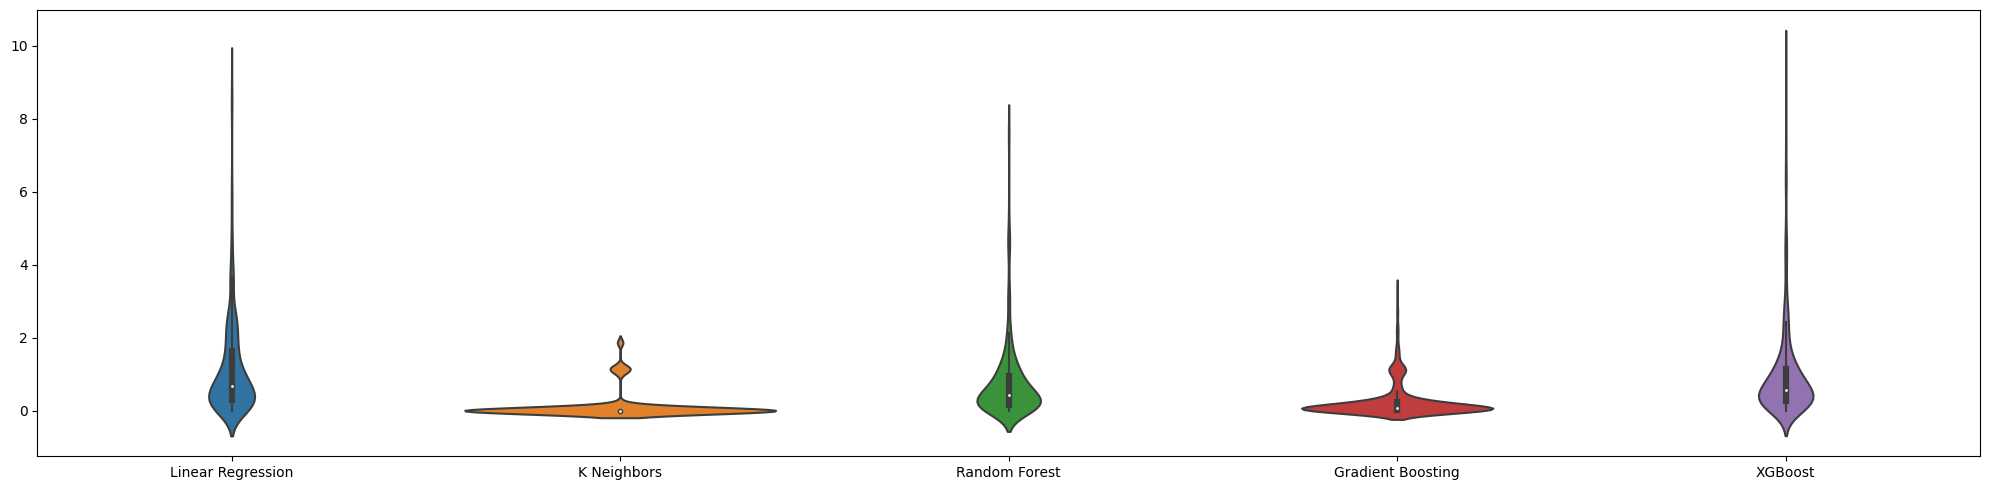

Test


In [38]:
# Get Output variables
PCE = df_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_03_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_qy_mat')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.71 |  47.33 |   0.38 |
| K Neighbors       |   0.99 |   9.13 |   0.89 |
| Random Forest     |   2.27 |  17.14 |   0.78 |
| Gradient Boosting |   0.49 |   1.48 |   0.98 |
| XGBoost           |   2.04 |  11.67 |   0.85 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.62 |  64.31 |  -0.26 |
| K Neighbors       |   4.12 |  47.73 |   0.15 |
| Random Forest     |   4.06 |  43.72 |   0.19 |
| Gradient Boosting |   4.52 |  60.79 |  -0.07 |
| XGBoost           |   3.67 |  40.66 |    0.3 |

Train


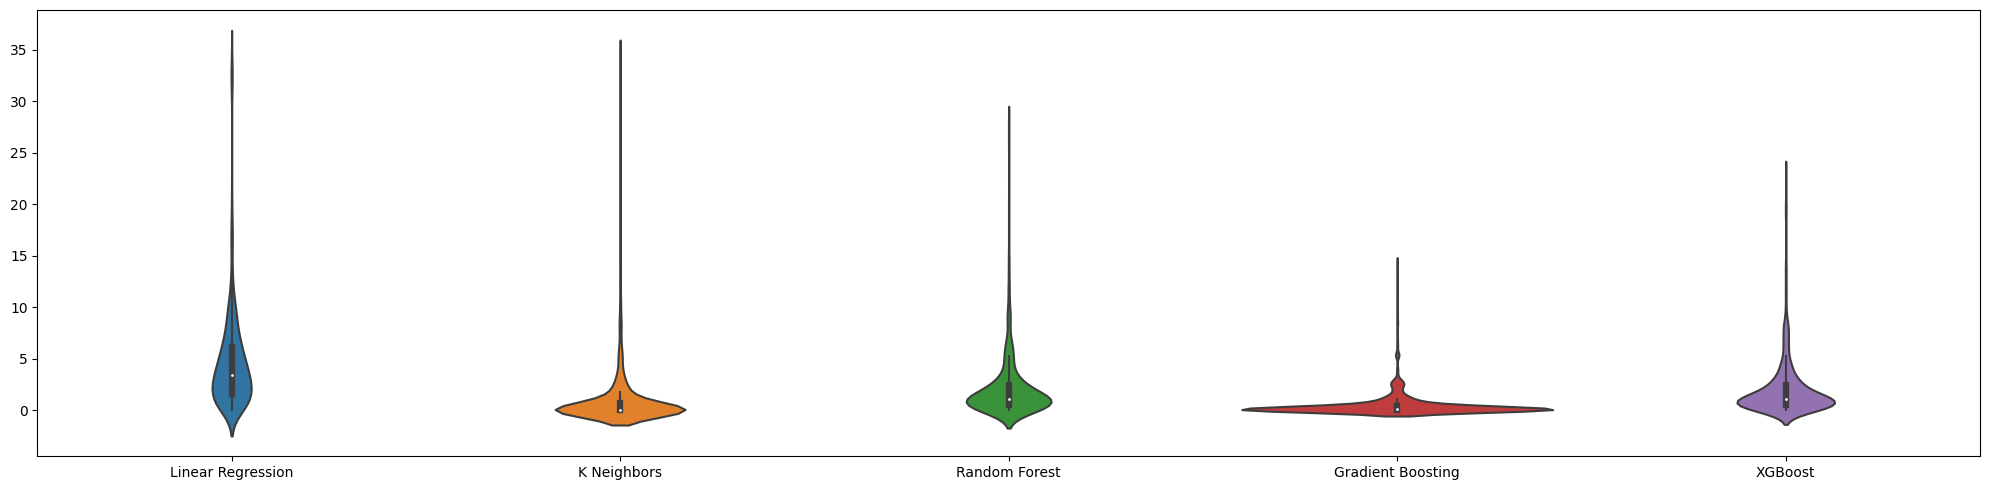

Test


In [39]:
# Get Output variables
hopt = df_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## hopt
print(f'hopt')
models_03_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_qy_mat')

## Outlier removal

In [40]:
def iqr_range(array):
    Q1 = np.percentile(array, 25)
    Q3 = np.percentile(array, 75)
    IQR = Q3 - Q1
    return ((Q1 - 1.5 * IQR),(Q3 + 1.5 * IQR))

In [41]:
PCE_array = df[['PCE (%)']].drop_nulls().to_numpy()[:,0]
#PCE_array
pce_low, pce_high = iqr_range(PCE_array)
print(f'PCE [{pce_low}, {pce_high}]')

PCE [-4.000000000000001, 6.912000000000001]


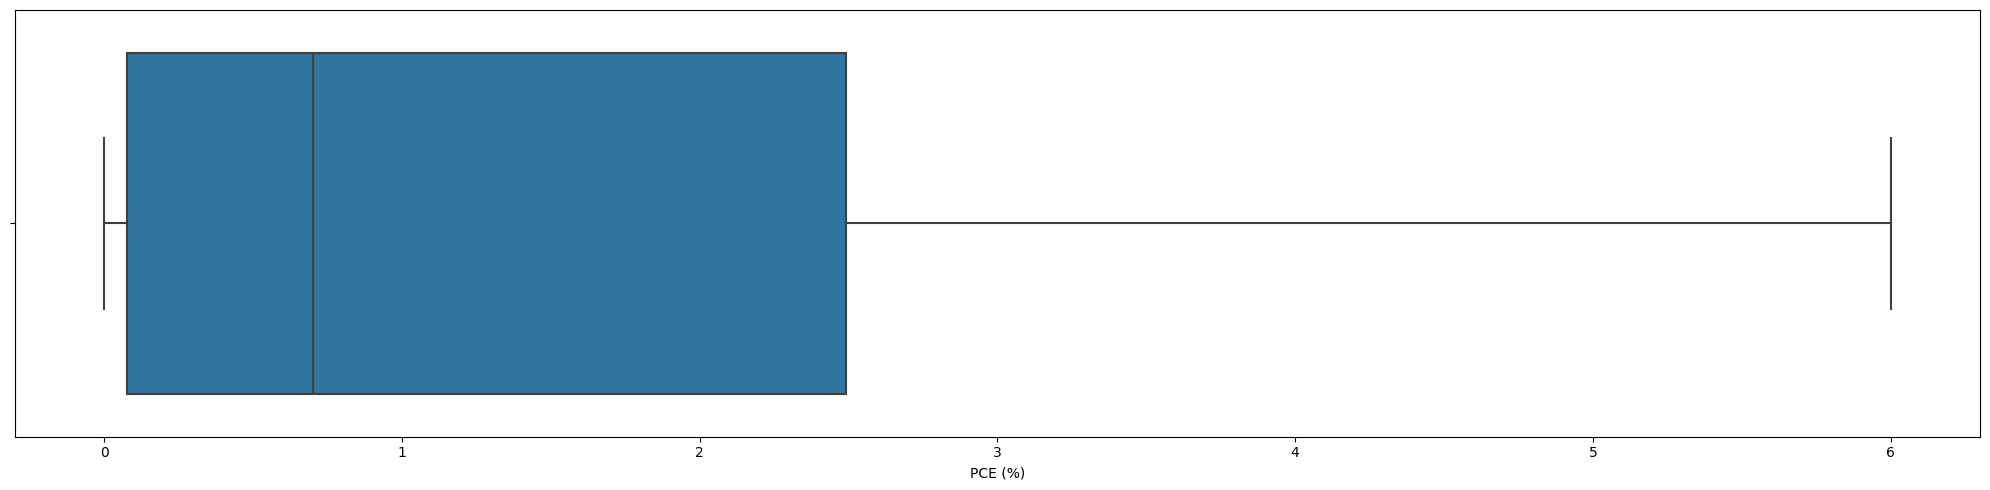

PCE: (121, 11)


In [42]:
df_filtered_PCE = df.filter((pl.col('PCE (%)') > pce_low) & (pl.col('PCE (%)') < pce_high))
sns.boxplot(data=df_filtered_PCE.to_pandas(), x='PCE (%)')
plt.show()
print(f'PCE: {df_filtered_PCE.shape}')

In [43]:
hopt_array = df[['hopt (%)']].drop_nulls().to_numpy()[:,0]
#hopt_array
hopt_low, hopt_high = iqr_range(hopt_array)
print(f'hopt [{hopt_low}, {hopt_high}]')

hopt [-6.99875, 15.63125]


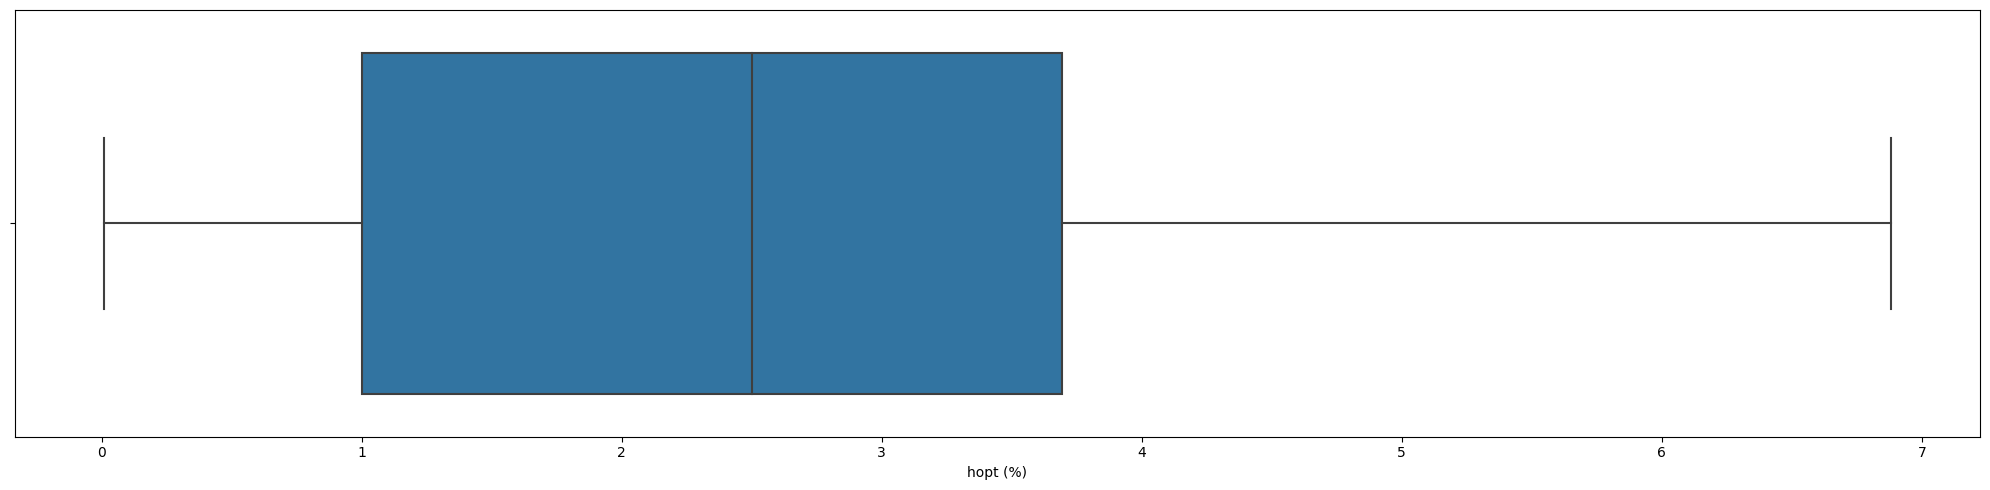

nhop: (106, 11)


In [44]:
df_filtered_hopt = df.filter((pl.col('hopt (%)') > pce_low) & (pl.col('hopt (%)') < pce_high))
sns.boxplot(data=df_filtered_hopt.to_pandas(), x='hopt (%)')
plt.show()
print(f'nhop: {df_filtered_hopt.shape}')

### PCE and hopt baselines

In [45]:
#models_gbr = [('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42),
#{'n_estimators':[50, 100, 150],'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],'max_depth':max_depth})]

In [46]:
df_out_baseline_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_baseline_PCE)

Shape: (121, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.15 |    2.0 |   0.14 |
| K Neighbors       |   0.26 |   0.39 |   0.83 |
| Random Forest     |   0.45 |   0.46 |    0.8 |
| Gradient Boosting |   0.17 |   0.15 |   0.93 |
| XGBoost           |   0.54 |   0.69 |    0.7 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.25 |   2.35 |  -0.01 |
| K Neighbors       |   0.99 |   1.94 |    0.1 |
| Random Forest     |   0.91 |   1.62 |   0.25 |
| Gradient Boosting |   0.79 |   1.53 |   0.28 |
| XGBoost           |   1.05 |   2.08 |   0.03 |

Train


Test


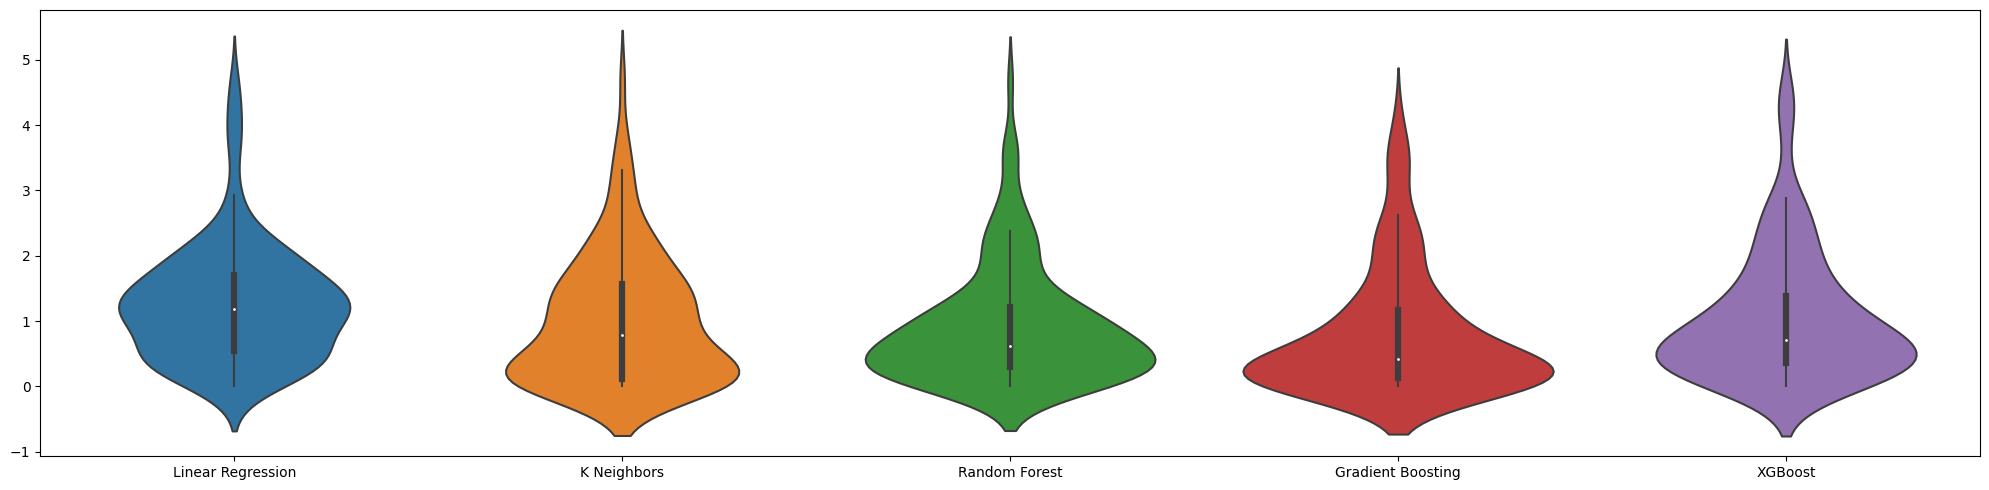

In [47]:
# Get Output variables
PCE = df_out_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_pce_baseline = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_baseline')

In [48]:
df_out_baseline_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_baseline_hopt)

Shape: (106, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.43 |   3.11 |   0.04 |
| K Neighbors       |    0.1 |   0.09 |   0.97 |
| Random Forest     |   0.85 |   1.11 |   0.66 |
| Gradient Boosting |   0.32 |   0.22 |   0.93 |
| XGBoost           |   1.07 |   1.76 |   0.46 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.59 |   3.86 |  -0.18 |
| K Neighbors       |   1.36 |   2.88 |   0.09 |
| Random Forest     |   1.44 |   3.04 |   0.04 |
| Gradient Boosting |    1.5 |   3.39 |  -0.06 |
| XGBoost           |   1.45 |   3.18 |   0.01 |

Train


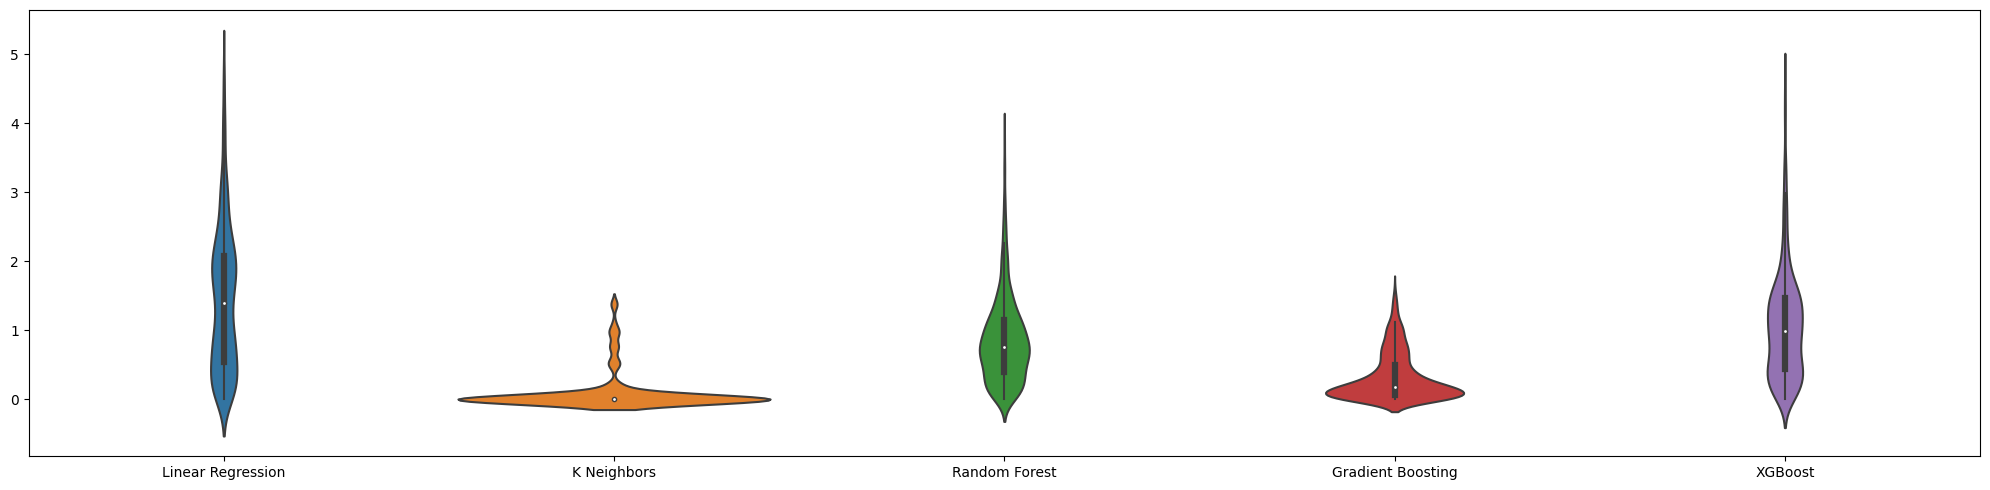

Test


In [49]:
# Get Output variables
hopt = df_out_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_hopt_baseline = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_baseline')

### Baseline + QY

In [50]:
df_out_02_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_02_PCE)

Shape: (107, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [51]:
df_out_02_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_02_hopt)

Shape: (95, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.11 |   1.91 |   0.12 |
| K Neighbors       |   0.12 |   0.14 |   0.93 |
| Random Forest     |   0.39 |   0.37 |   0.83 |
| Gradient Boosting |   0.16 |   0.16 |   0.93 |
| XGBoost           |   0.56 |   0.71 |   0.67 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.27 |   2.42 |  -0.15 |
| K Neighbors       |   0.99 |   1.97 |   0.11 |
| Random Forest     |   0.91 |   1.65 |   0.24 |
| Gradient Boosting |   0.96 |   2.03 |   0.05 |
| XGBoost           |   0.97 |   1.85 |   0.15 |

Train


Test


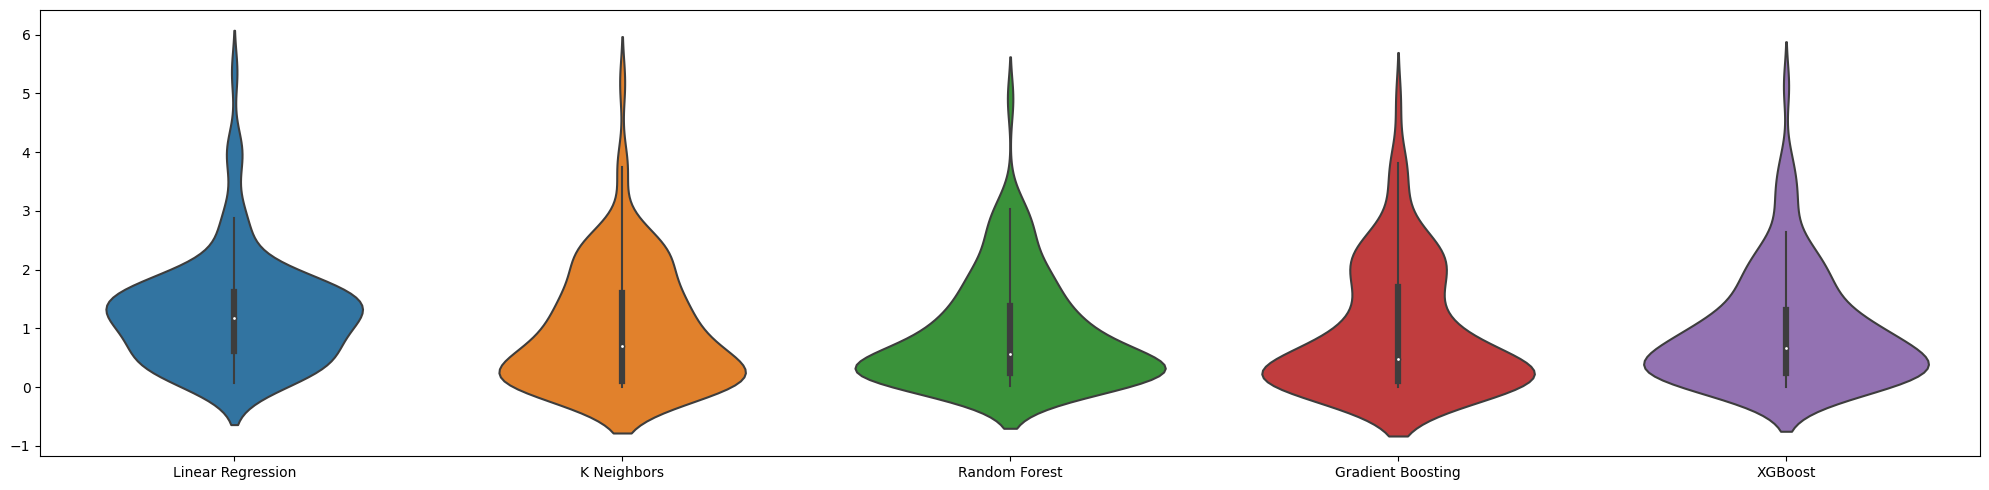

In [52]:
# Get Output variables
PCE = df_out_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_02_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_qy')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.45 |   3.18 |   0.04 |
| K Neighbors       |   0.48 |   0.87 |   0.74 |
| Random Forest     |   0.66 |   0.74 |   0.78 |
| Gradient Boosting |   0.21 |   0.13 |   0.96 |
| XGBoost           |   0.97 |   1.52 |   0.54 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.63 |   4.12 |   -0.3 |
| K Neighbors       |   1.36 |   2.91 |   0.07 |
| Random Forest     |    1.4 |   2.92 |   0.07 |
| Gradient Boosting |   1.47 |   3.55 |  -0.14 |
| XGBoost           |   1.42 |   3.15 |   0.01 |

Train


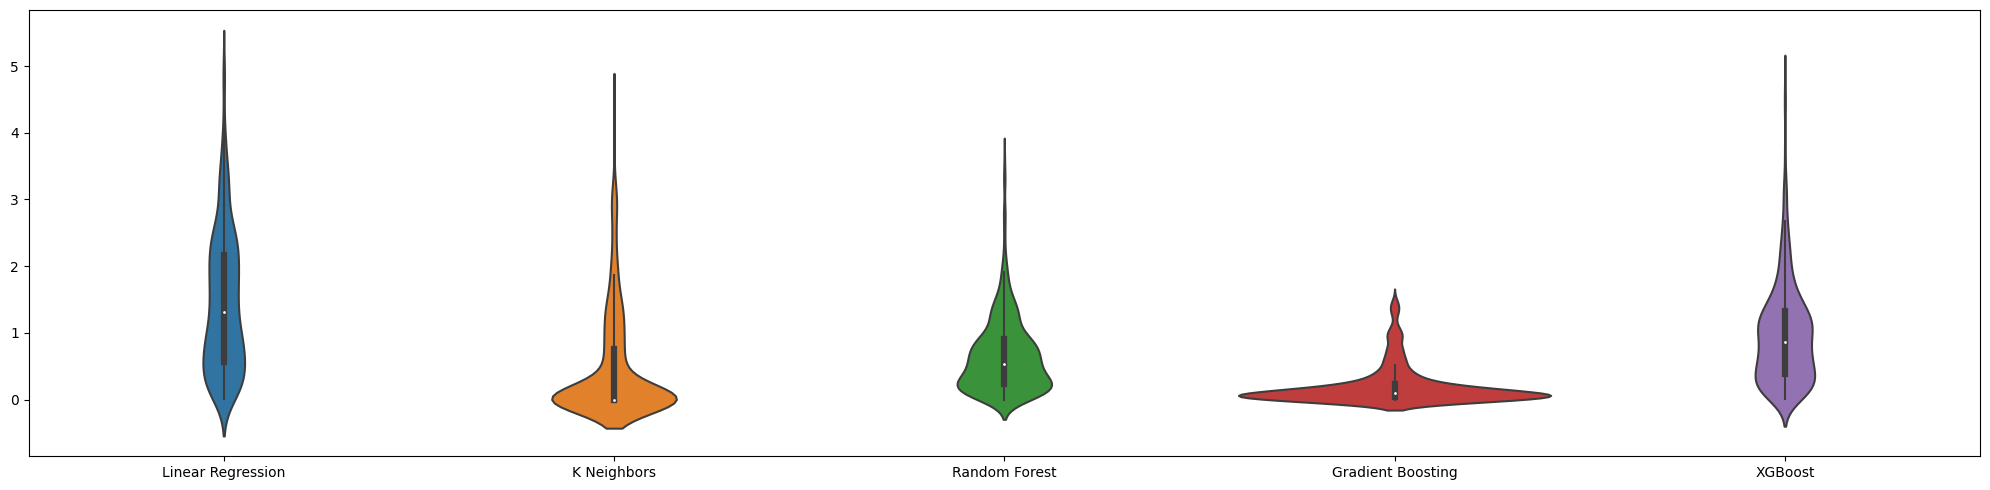

Test


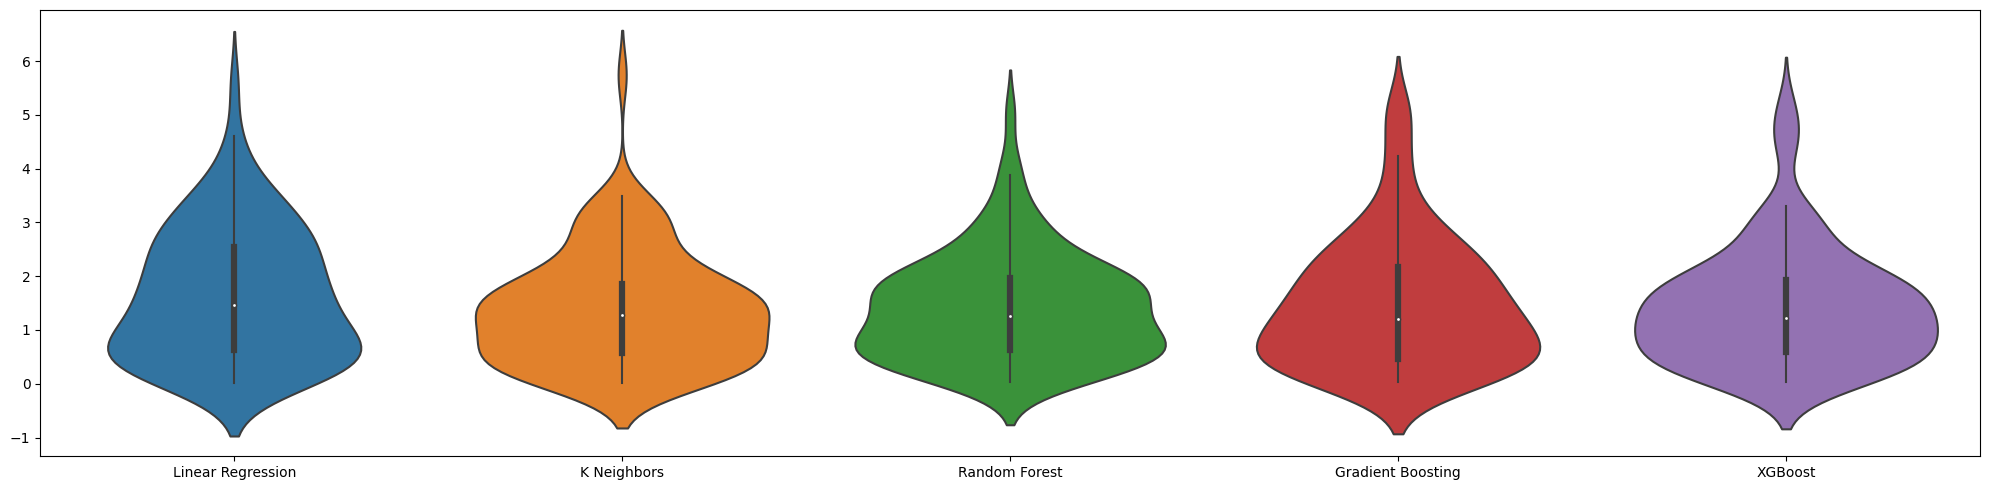

In [53]:
# Get Output variables
hopt = df_out_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_02_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_qy')

### Baseline + QY + Categorical (Mat0 and Mat1)

In [54]:
df_out_03_PCE = df_filtered_PCE.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_out_03_PCE)

Shape: (107, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [55]:
df_out_03_hopt = df_filtered_hopt.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_out_03_hopt)

Shape: (95, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


In [56]:
# Get Output variables
PCE = df_out_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_out_03_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_qy_mat')

PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   0.79 |   1.15 |   0.47 |
| K Neighbors       |   0.17 |   0.21 |    0.9 |
| Random Forest     |   0.35 |    0.3 |   0.86 |
| Gradient Boosting |   0.14 |   0.15 |   0.93 |
| XGBoost           |    0.4 |   0.45 |   0.79 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.02 |    1.8 |   0.16 |
| K Neighbors       |   0.88 |   1.72 |   0.22 |
| Random Forest     |   0.88 |   1.56 |   0.28 |
| Gradient Boosting |   0.96 |   1.99 |   0.06 |
| XGBoost           |    1.0 |   2.16 |  -0.02 |

Train


Test


hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.36 |   2.84 |   0.14 |
| K Neighbors       |   0.21 |   0.36 |   0.89 |
| Random Forest     |   0.63 |   0.64 |   0.81 |
| Gradient Boosting |   0.18 |   0.11 |   0.97 |
| XGBoost           |   0.97 |   1.53 |   0.54 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.71 |   4.66 |  -0.48 |
| K Neighbors       |    1.4 |   3.05 |   0.06 |
| Random Forest     |   1.41 |   3.02 |   0.04 |
| Gradient Boosting |   1.49 |    3.6 |  -0.12 |
| XGBoost           |   1.43 |   3.28 |  -0.04 |

Train


Test


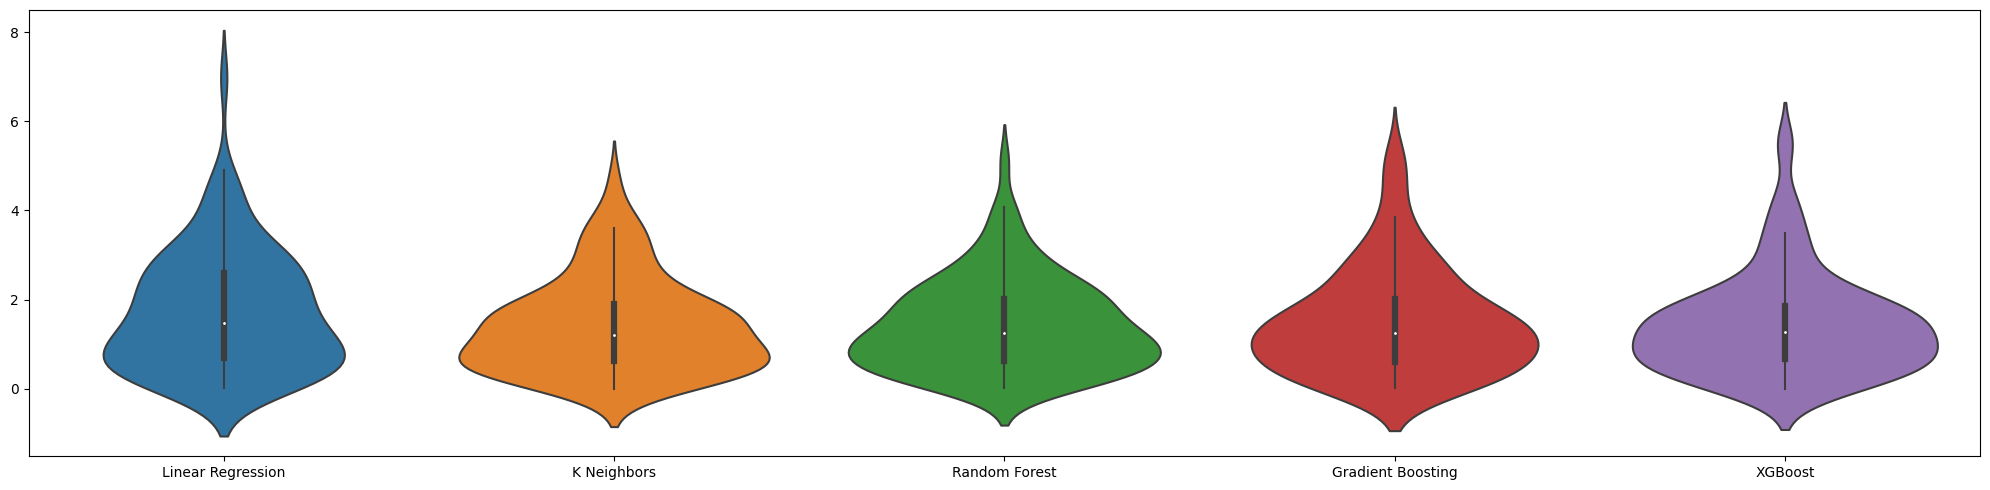

In [57]:
# Get Output variables
hopt = df_out_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'hopt')
models_out_03_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_qy_mat')

## Clustering

In [4]:
df = pl.read_excel('db.xlsx')
#df = df.drop(['#'])
df_clustering_index = df.drop(['mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
df_clustering_index = df_clustering_index.drop_nulls()
df_clustering = df_clustering_index.drop(['#'])
print_missing_samples(df_clustering)

Shape: (173, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%


In [5]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [6]:
# Cluster the materials without the hopt and PCE
X = df_clustering.to_numpy()
print(f'X = {X.shape}')

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 20

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

X = (173, 7)


In [7]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

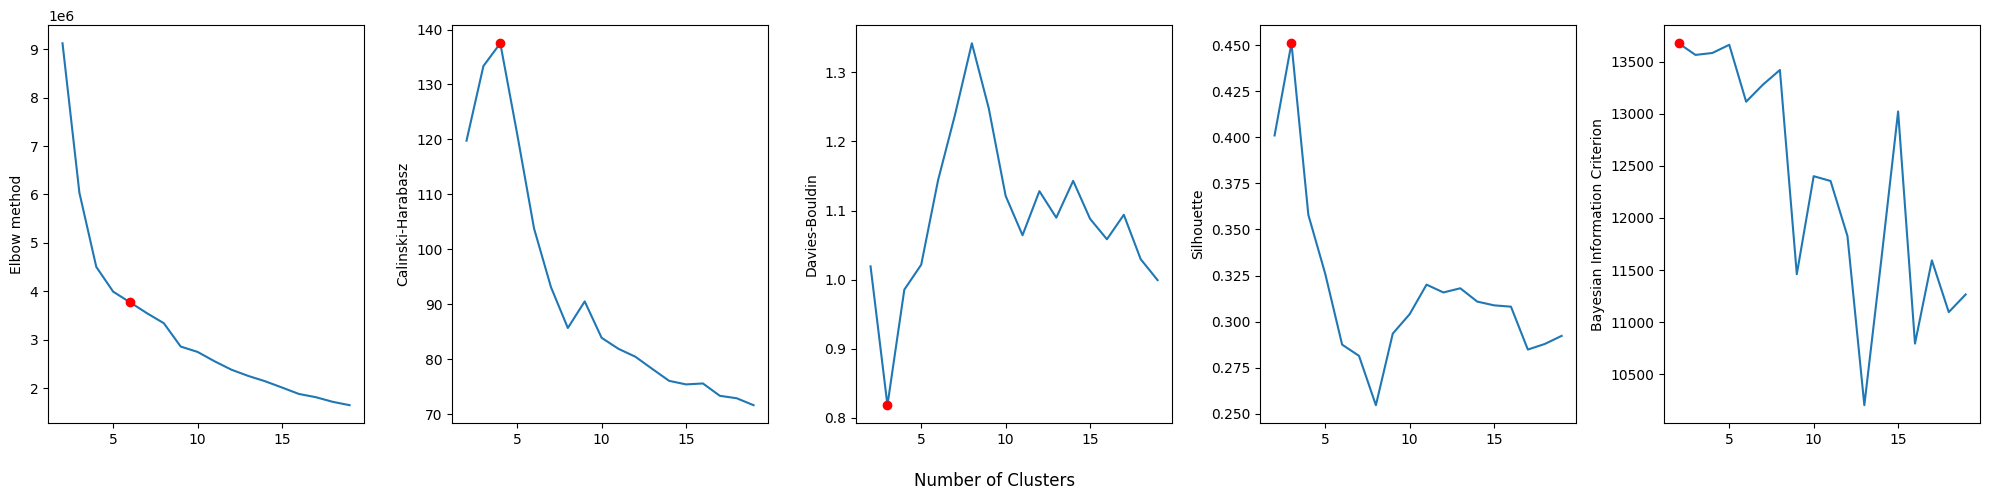

In [8]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]
    
    axs[i].plot(range(min_k, max_k), scores[method])
    if method == 'elbow':
        idx = kneedle.auto_knee(points)
        axs[i].set_ylabel('Elbow method')
    elif method == 'calinski-harabasz':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Calinski-Harabasz')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'davies-bouldin':
        idx = scores[method].index(min(scores[method]))
        axs[i].set_ylabel('Davies-Bouldin')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'silhouette':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Silhouette')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'bic':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Bayesian Information Criterion')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    axs[i].plot(x[idx], scores[method][idx], 'ro')
fig.supxlabel('Number of Clusters')
#fig.supylabel('Metric Score', x=-0.0001)
fig_store = plt.gcf()
fig_store.savefig(f'figures/kmeans.pdf', bbox_inches='tight')
plt.show()

In [9]:
def compute_avg_field_per_cluster(df_origin, df_clustering, labels, field='PCE (%)'):
    field_per_cluster = []
    min_k = min(labels)
    max_k = max(labels)
    #print(f'[{min_k}, {max_k}]')
    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        mean_field = filter_df[field].mean()
        field_per_cluster.append(mean_field)
    return field_per_cluster

def get_clusters_df(df_origin, df_clustering, labels):
    min_k = min(labels)
    max_k = max(labels)

    df_per_cluster = []

    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        #mean_field = filter_df[field].mean()
        #field_per_cluster.append(mean_field)
        df_per_cluster.append(filter_df)
    return df_per_cluster

def plot_stats_per_cluster(df_origin, df_clustering, labels):
    df_per_cluster = get_clusters_df(df_origin, df_clustering, labels)
    for k, dfk in enumerate(df_per_cluster):
        print(f'Cluster: {k}')
        plot_dfk = dfk.drop(['#'])
        describe_variables(plot_dfk, filename=f'cluster_{k}')

def find_nearest(array, value):
    diff = np.sum(np.abs(array - value), axis=1)
    idx = diff.argmin()
    return idx

def find_nearest_df(df, df_origin, value, k, field):
    df_no_id = df.drop(['#'])
    array = df_no_id.to_numpy()
    diff = np.sum(np.abs(array - value), axis=1)
    idxs = []
    
    i = j = 0
    while i < k and j < len(diff):
        j += 1
        idx = diff.argmin()
        #print(f'Current idx {idx}')
        diff[idx] = float('inf')
        #print(f'{df_origin.row(idx, named=True)}')
        if df_origin.row(idx, named=True)[field] is not None:
            idxs.append(idx)
            i += 1
    
    idxs = [df.row(i, named=True)['#'] for i in idxs]
    return idxs

def get_missing(df, field):
    df_qy_not_null = df.filter(pl.col('QY (%)').is_not_null())
    missing_df = df_qy_not_null.filter(pl.col(field).is_null())
    missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()
    return missing
    #return missing_df
    #vector_df = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
    #missing = vector_df.to_numpy()

def predict_field_clustering(df_origin, df_clustering, kmeans, k=3, field='PCE (%)'):
    labels = kmeans.labels_
    centroids  = kmeans.cluster_centers_
    #centroid_labels = [centroids[i] for i in labels]
    #print(f'{labels} {centroids}')
    
    missing = get_missing(df_origin, field)
    #missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()

    # for each missing point, find the closest cluster
    rv = []
    for row in missing:
        closest_cluster = find_nearest(centroids, row)
        # select the corresponding cluster
        mask = (labels == closest_cluster)
        df_k = df_clustering.filter(mask)
        temp_id = df_k['#'].to_list()
        df_origin_k = df_origin.filter(pl.col('#').is_in(temp_id))
        idxs = find_nearest_df(df_k, df_origin_k, row, k, field)
        filter_df = df_origin.filter(pl.col('#').is_in(idxs))
        # compute the average
        pce_k = filter_df[field].to_numpy()
        rv.append((np.mean(pce_k), np.median(pce_k)))
    return rv

def rmse(measured, truth):
    return np.linalg.norm(measured - truth) / np.sqrt(len(truth))

In [127]:
k=5
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
labels = kmeans.labels_

In [128]:
avg_pce_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='PCE (%)')
print(f'Avg PCE cluster: {avg_pce_cluster}')
avg_hopt_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='hopt (%)')
print(f'Avg hOPT cluster: {avg_hopt_cluster}')
predictions_pce = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='PCE (%)')
print(f'Predictions PCE: {predictions_pce}')
predictions_hopt = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='hopt (%)')
print(f'Predictions hOPT: {predictions_hopt}')

Avg PCE cluster: [1.7782352941176471, 2.208725, 0.9611066247880435, 2.3942907096774193, 0.5521064117647059]
Avg hOPT cluster: [3.1220000000000003, 9.250588235294117, 7.5371304347826085, 4.159564102564102, 5.469478260869566]
Predictions PCE: [(2.466666666666667, 2.9), (0.8433333333333334, 0.2), (1.9866666666666666, 1.96), (2.546666666666667, 2.9), (1.4166666666666667, 0.61), (0.7966666666666667, 0.61), (1.9217333333333333, 1.96), (0.07253333333333332, 0.0052), (1.96, 1.7), (5.4433333333333325, 4.29), (0.86, 0.2), (3.7266666666666666, 1.7), (2.63, 3.05), (2.9633333333333334, 2.94), (3.296666666666667, 3.1), (0.47333333333333333, 0.44), (0.47333333333333333, 0.44), (1.78, 1.7), (2.63, 3.05), (2.796666666666667, 2.39), (2.0033333333333334, 2.39), (1.0923333333333334, 0.77), (2.0366666666666666, 2.6), (0.11266666666666668, 0.117), (0.42333333333333334, 0.38), (2.42, 2.39), (1.7199666666666669, 2.3), (2.4, 1.96), (2.1672666666666665, 2.7), (1.7199666666666669, 2.3), (2.4, 1.96), (2.58, 1.94)

In [129]:
mean_k_preds_pce = [p[0] for p in predictions_pce]
median_k_preds_pce = [p[1] for p in predictions_pce]

mean_k_preds_hopt = [p[0] for p in predictions_hopt]
median_k_preds_hopt = [p[1] for p in predictions_hopt]

PCE
Model: Linear Regression
Mean


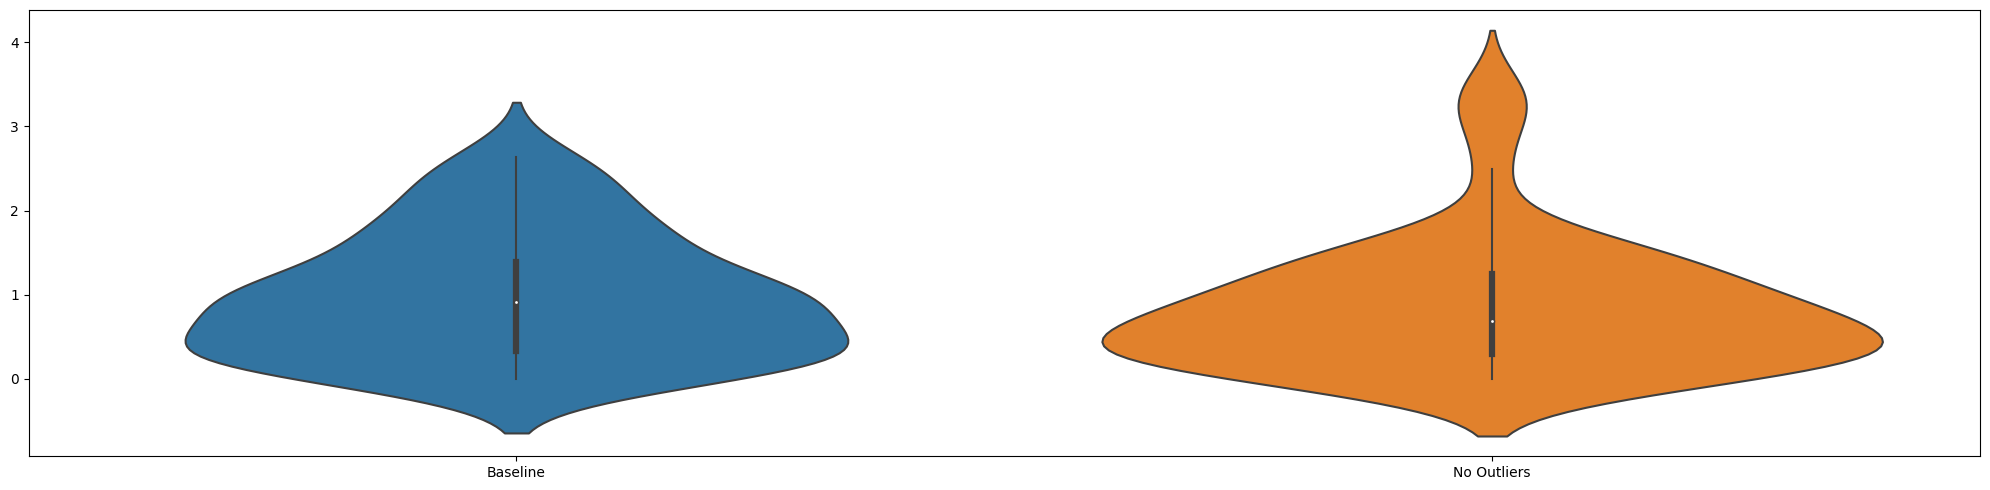

Median


Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.97 |   1.47 |  -1.87 |
| Median            |   1.02 |   1.48 |  -1.89 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.84 |   1.29 |   0.03 |
| Median            |   0.89 |   1.19 |   0.09 |

Model: K Neighbors
Mean


Median


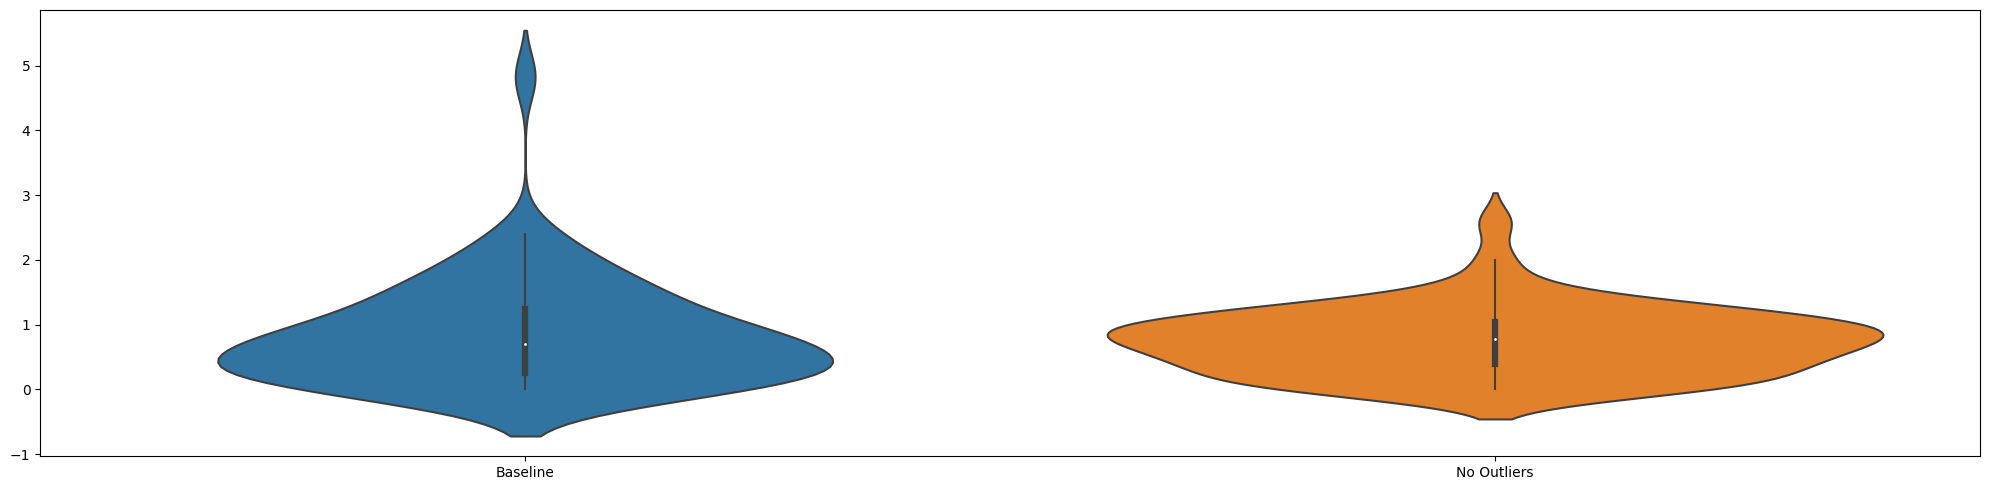

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    0.8 |   1.35 |   -0.2 |
| Median            |   0.84 |   1.36 |  -0.21 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.68 |   0.99 |   0.26 |
| Median            |   0.74 |   0.81 |   0.38 |

Model: Random Forest
Mean


Median


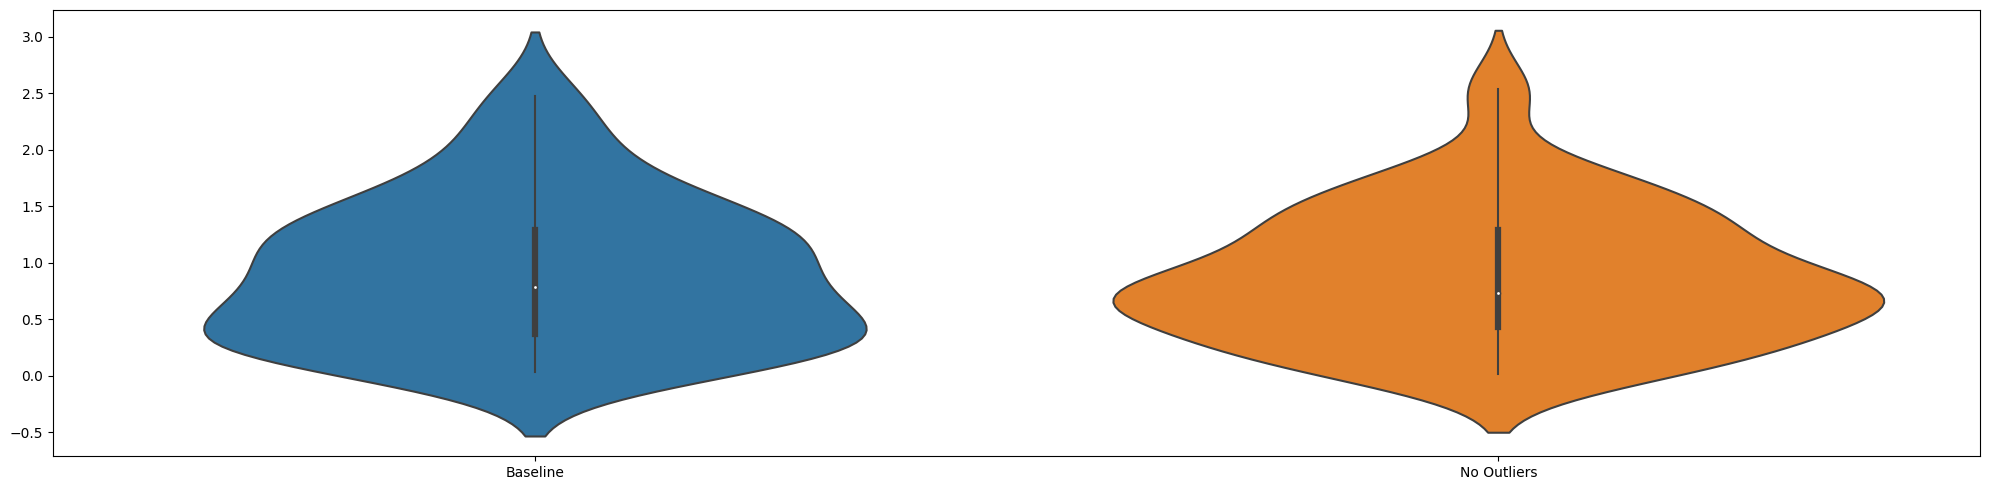

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.86 |   1.13 |  -1.23 |
| Median            |   0.91 |   1.24 |  -1.45 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.79 |   1.24 |   0.07 |
| Median            |   0.87 |    1.1 |   0.16 |

Model: Gradient Boosting
Mean


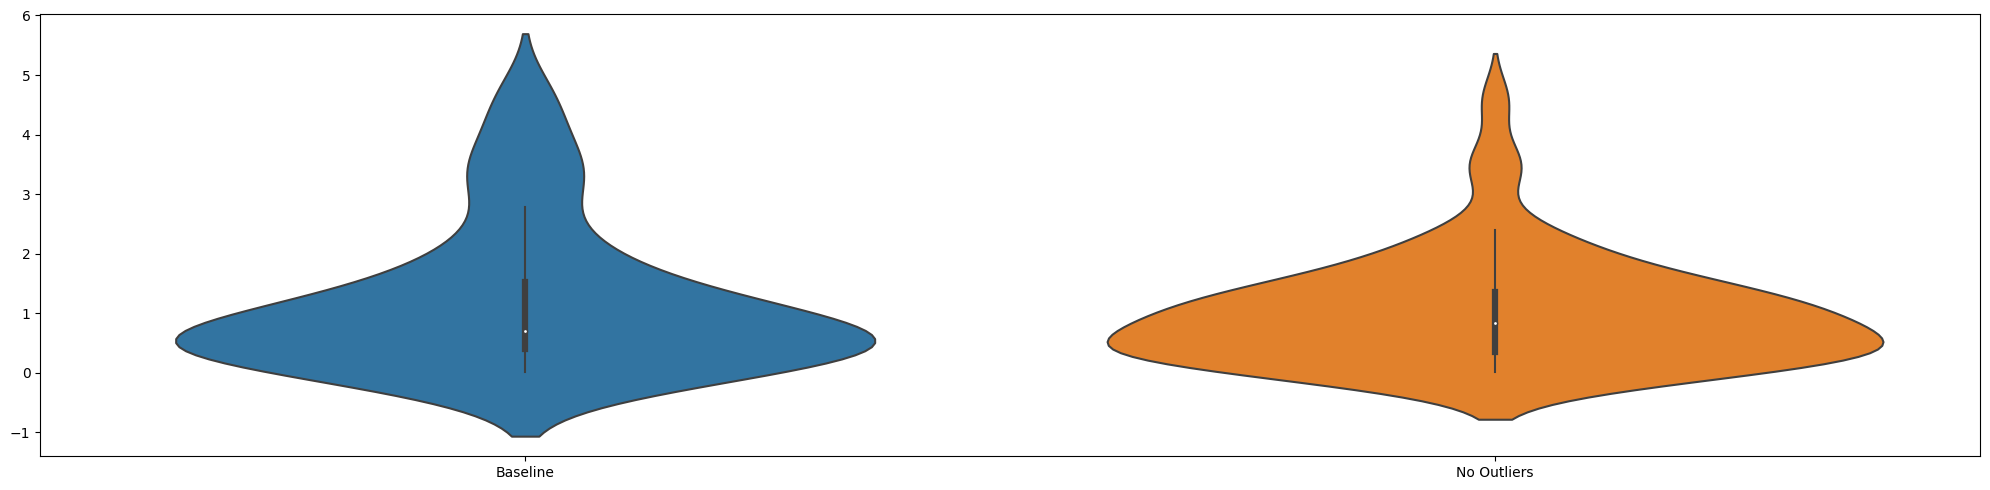

Median


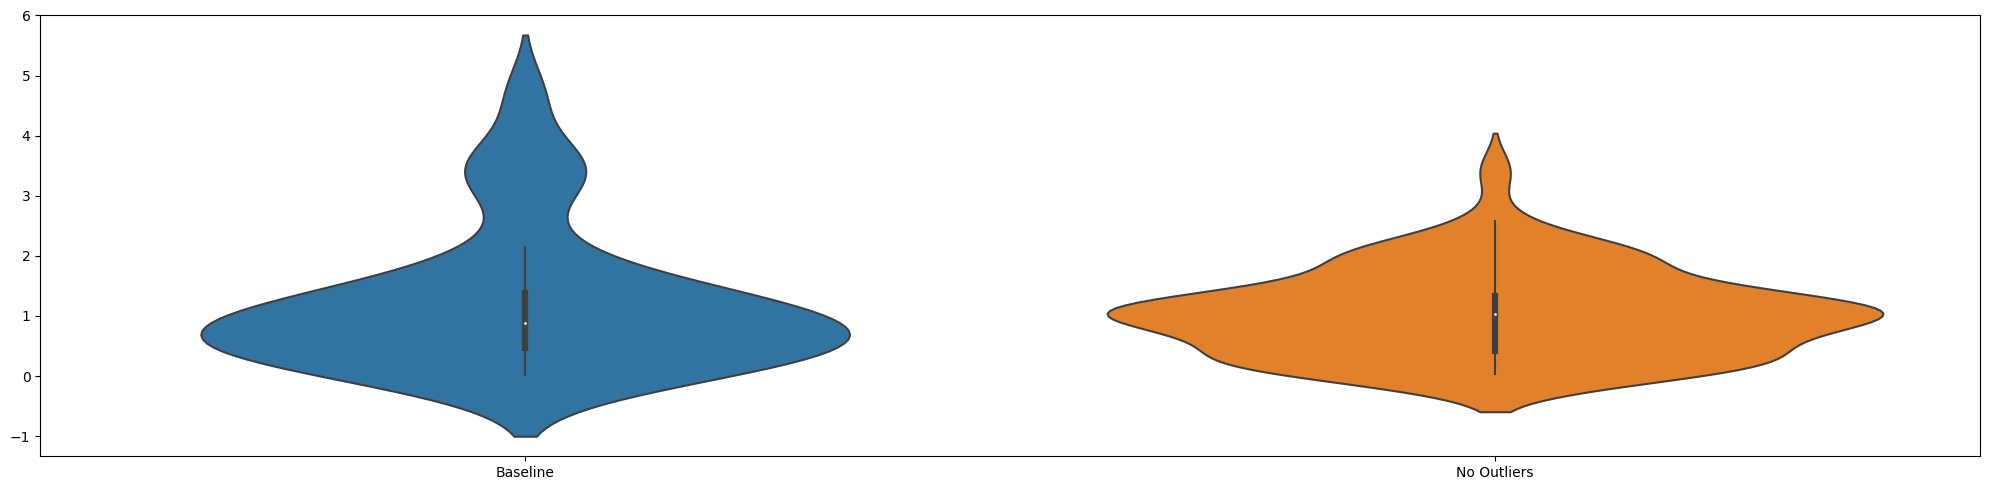

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   1.18 |   2.86 |  -0.13 |
| Median            |   1.21 |   2.78 |   -0.1 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.99 |    1.8 |  -0.35 |
| Median            |   1.03 |   1.58 |   -0.2 |

Model: XGBoost
Mean


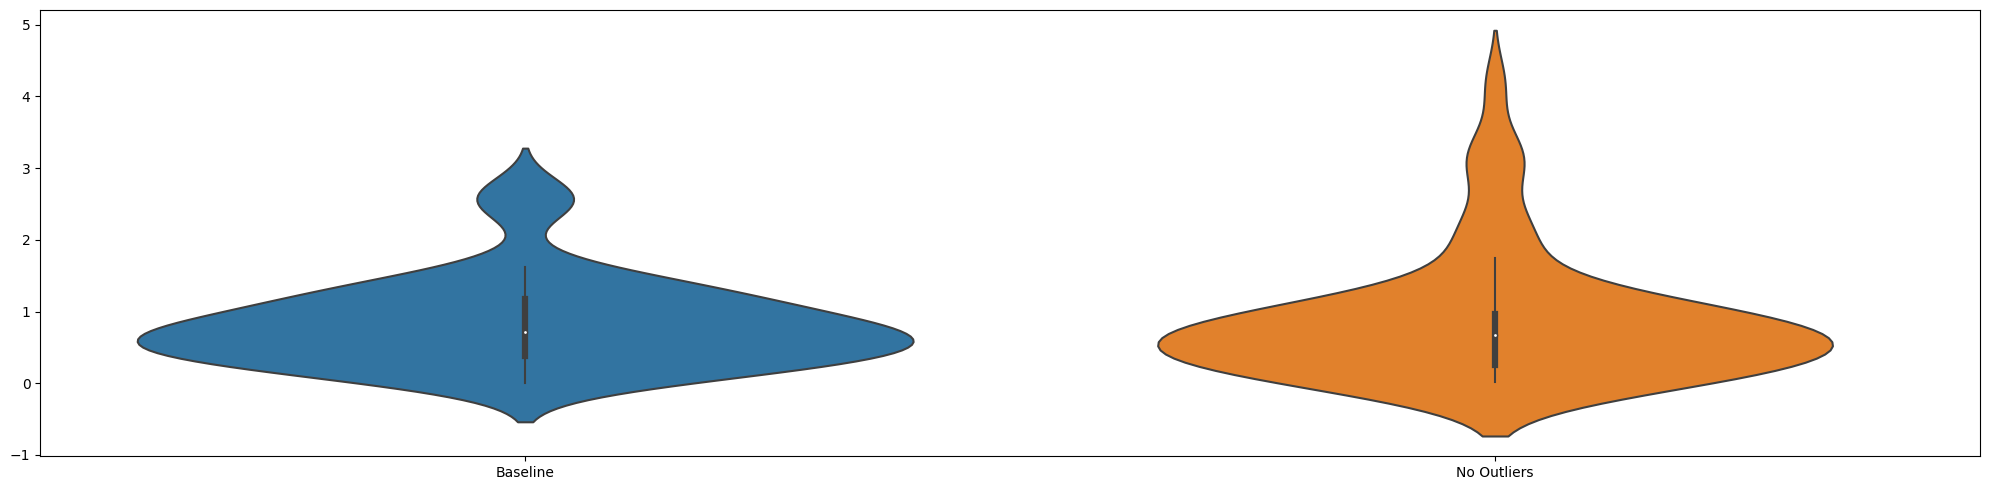

Median


Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.83 |   1.07 |  -3.07 |
| Median            |    0.9 |   1.04 |  -2.97 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.86 |   1.46 |   -0.1 |
| Median            |   0.89 |   1.23 |   0.07 |



In [130]:
print(f'PCE')
missing = get_missing(df, field='PCE (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_pce     = models_02_pce[name].predict(missing)
    out_preds_pce = models_out_02_pce[name].predict(missing)

    print(f'Mean')
    diff_mean_preds = np.abs(preds_pce-mean_k_preds_pce)
    diff_mean_out_preds = np.abs(out_preds_pce-mean_k_preds_pce)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_pce_{name}_mean.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_pce_{name}_mean.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_pce-median_k_preds_pce)
    diff_median_out_preds = np.abs(out_preds_pce-median_k_preds_pce)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_pce_{name}_median.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_pce_{name}_median.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_pce, mean_k_preds_pce)
    score_mse_mean = mean_squared_error(preds_pce, mean_k_preds_pce)
    score_r2_mean  = r2_score(preds_pce, mean_k_preds_pce)
                
    score_mae_median = mean_absolute_error(preds_pce, median_k_preds_pce)
    score_mse_median = mean_squared_error(preds_pce, median_k_preds_pce)
    score_r2_median  = r2_score(preds_pce, median_k_preds_pce)

    # print the results
    print(f'With Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_pce, mean_k_preds_pce)
    score_mse_mean_out = mean_squared_error(out_preds_pce, mean_k_preds_pce)
    score_r2_mean_out  = r2_score(mean_k_preds_pce, out_preds_pce)
                
    score_mae_median_out = mean_absolute_error(out_preds_pce, median_k_preds_pce)
    score_mse_median_out = mean_squared_error(out_preds_pce, median_k_preds_pce)
    score_r2_median_out  = r2_score(median_k_preds_pce, out_preds_pce)

    # print the results
    print(f'Without Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

hOPT
Model: Linear Regression
Mean


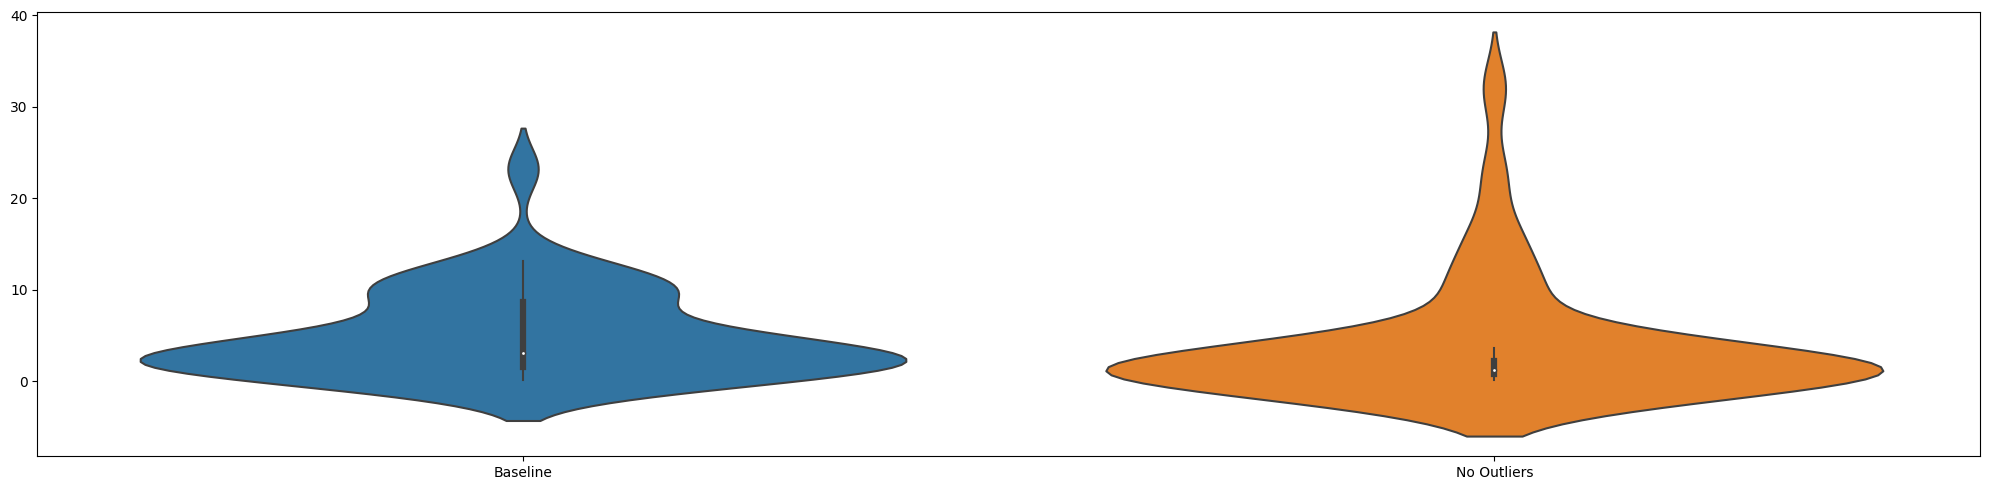

Median


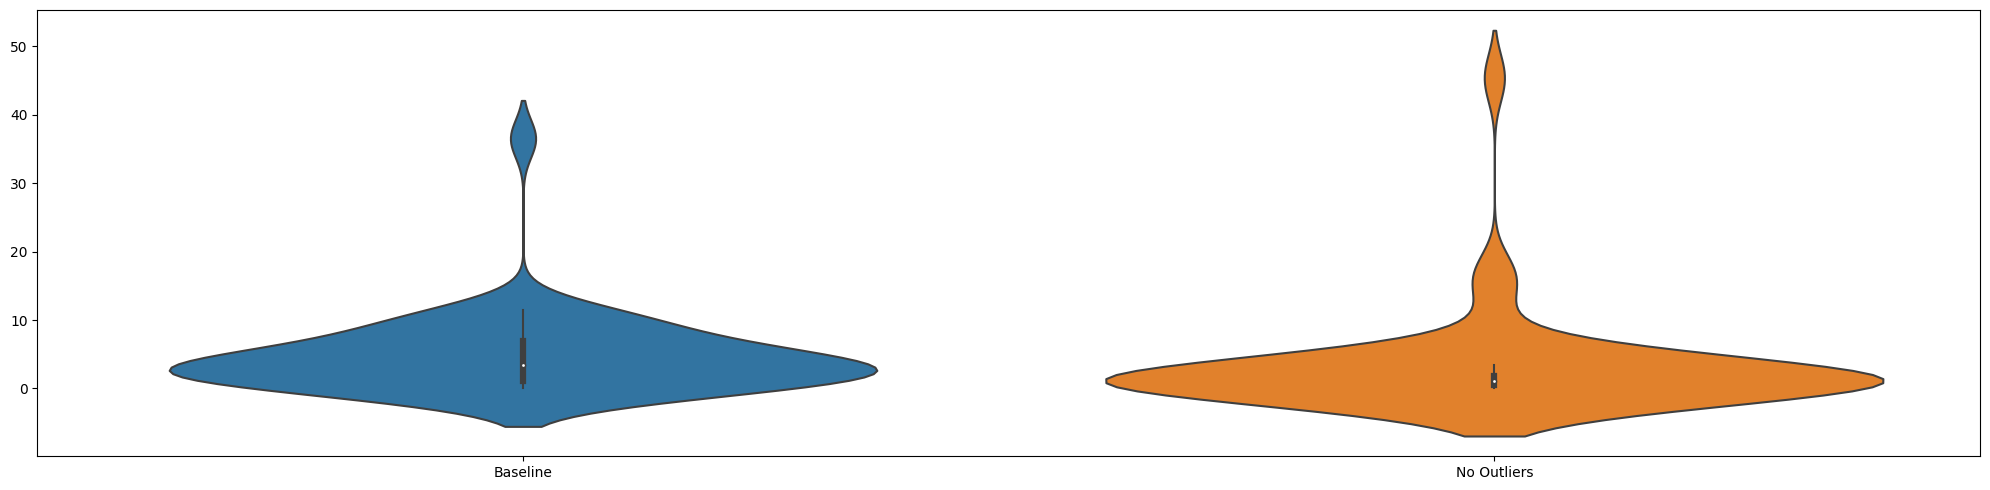

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   4.99 |  47.15 |  -2.12 |
| Median            |   4.79 |  57.43 |   -2.8 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.84 |  56.54 |  -0.18 |
| Median            |   3.07 |  63.06 |  -0.06 |

Model: K Neighbors
Mean


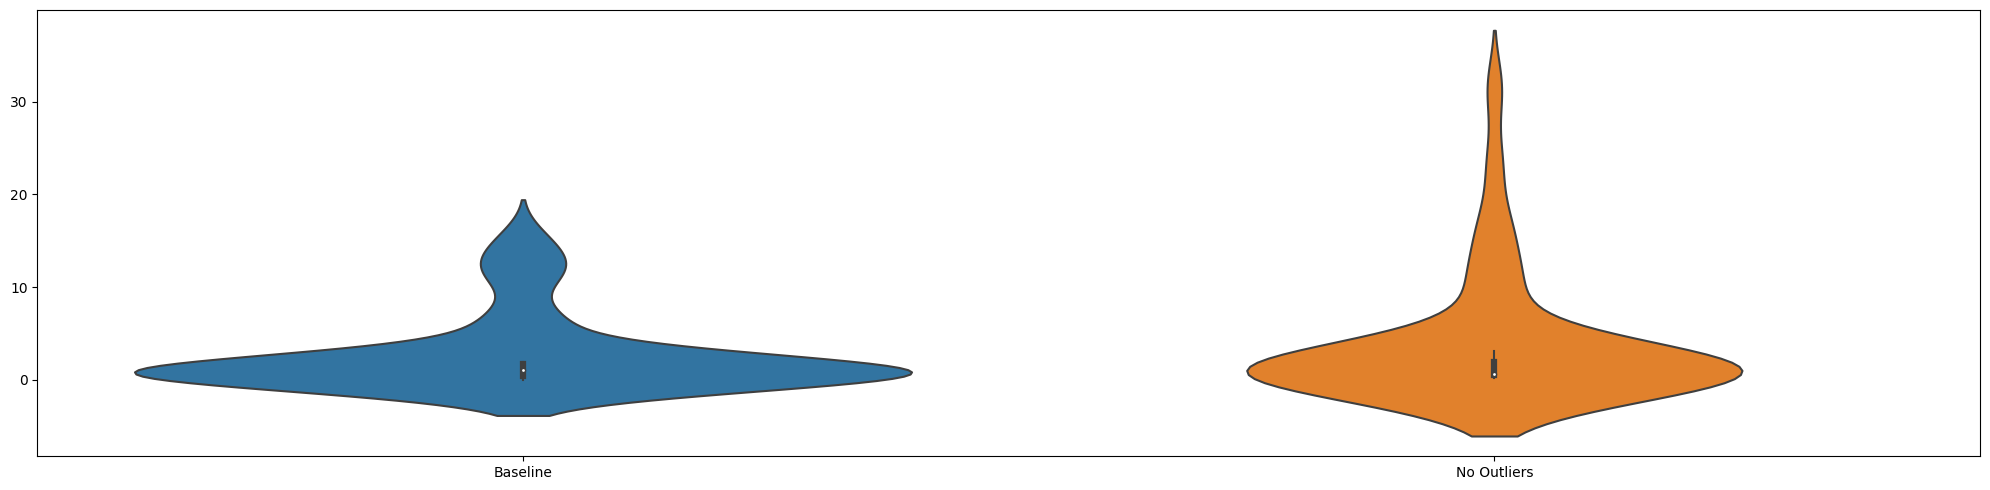

Median


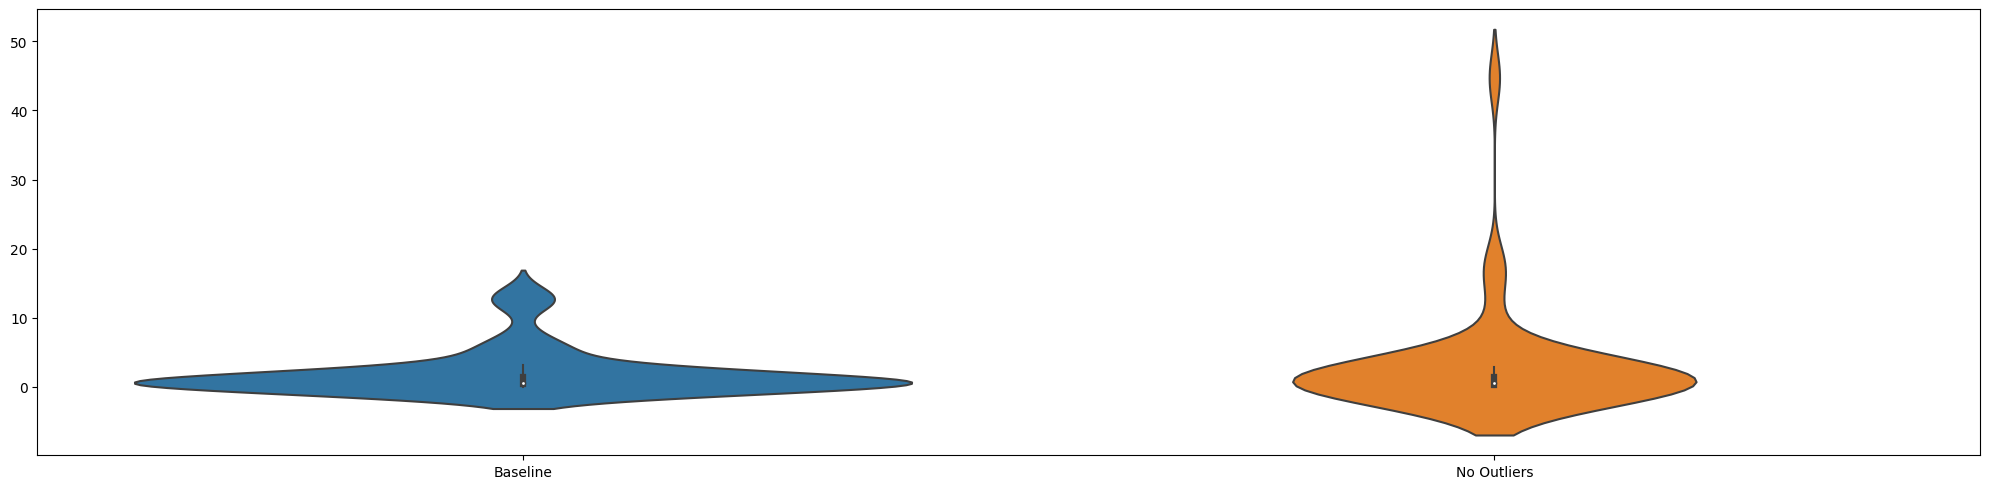

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   2.65 |  23.39 |   0.49 |
| Median            |   1.98 |  15.15 |   0.67 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.67 |   57.3 |  -0.19 |
| Median            |   2.77 |  62.26 |  -0.04 |

Model: Random Forest
Mean


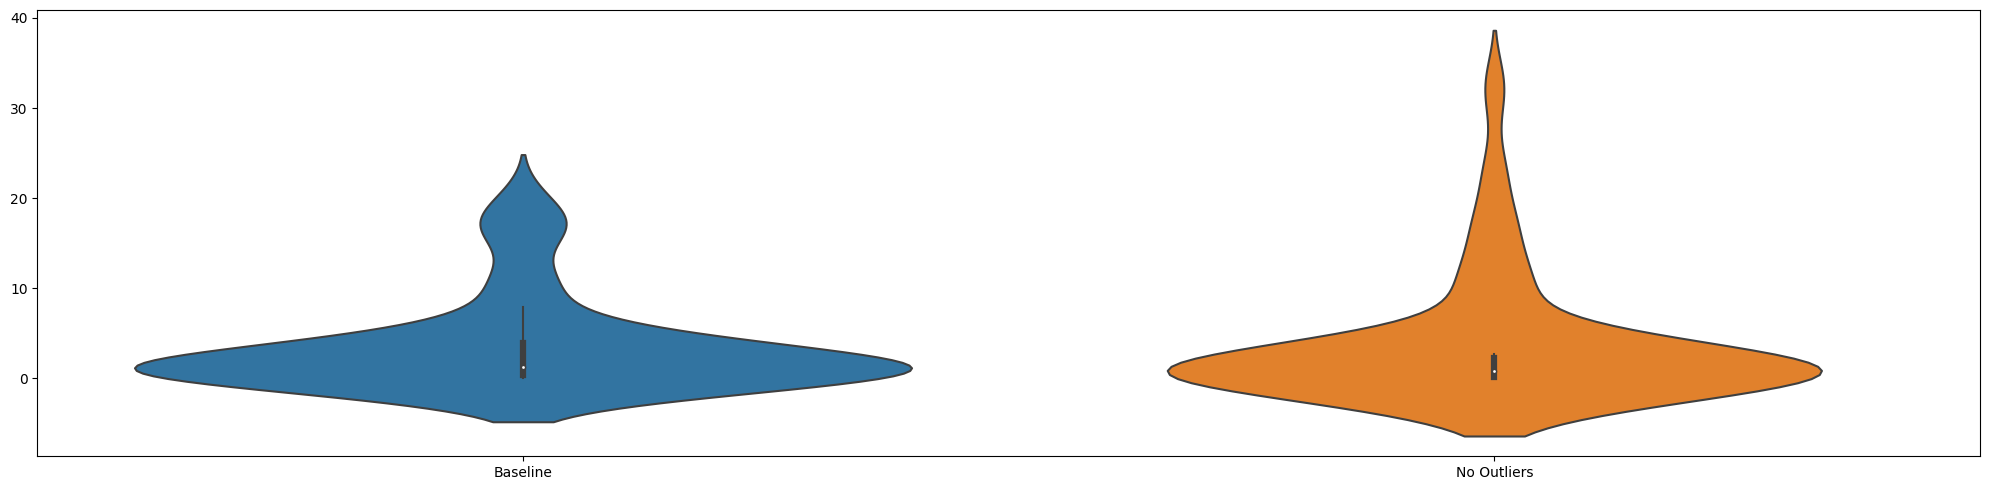

Median


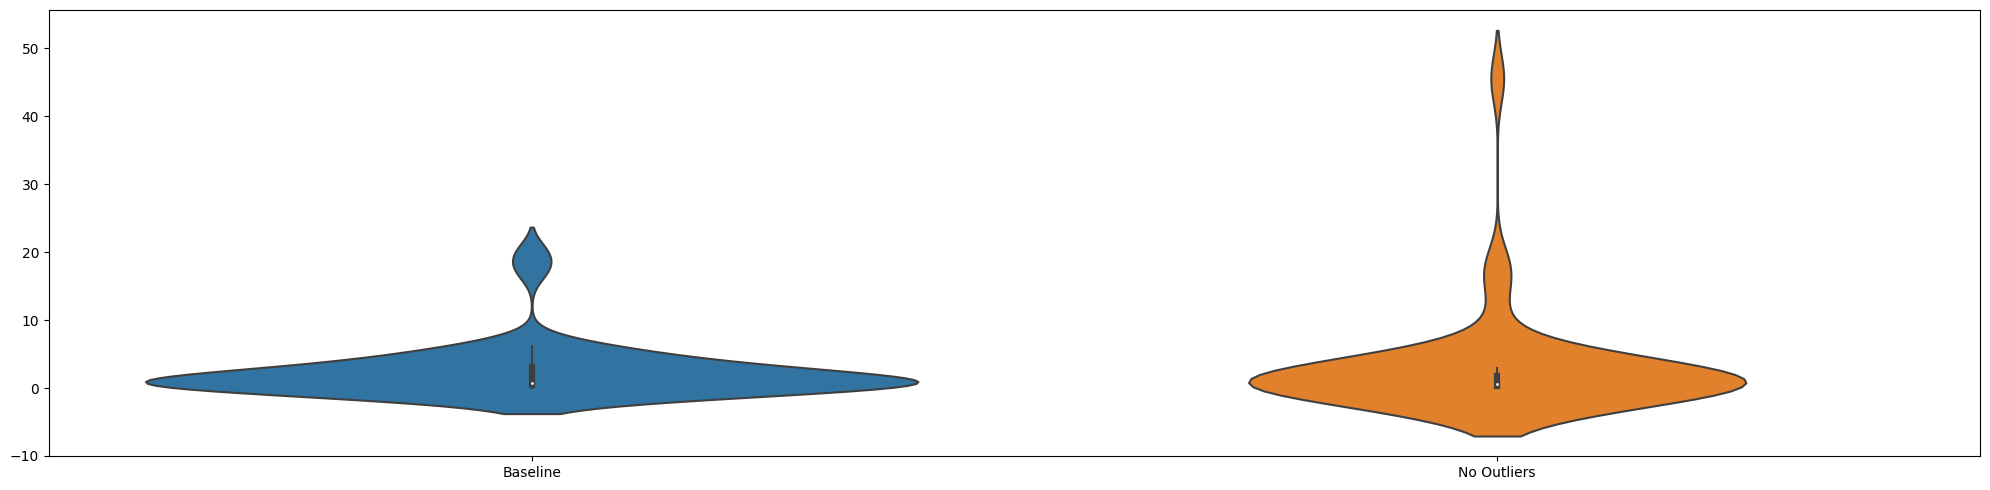

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.52 |  39.02 |   0.46 |
| Median            |   2.41 |  21.55 |    0.7 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.59 |  58.64 |  -0.22 |
| Median            |   2.87 |  64.29 |  -0.08 |

Model: Gradient Boosting
Mean


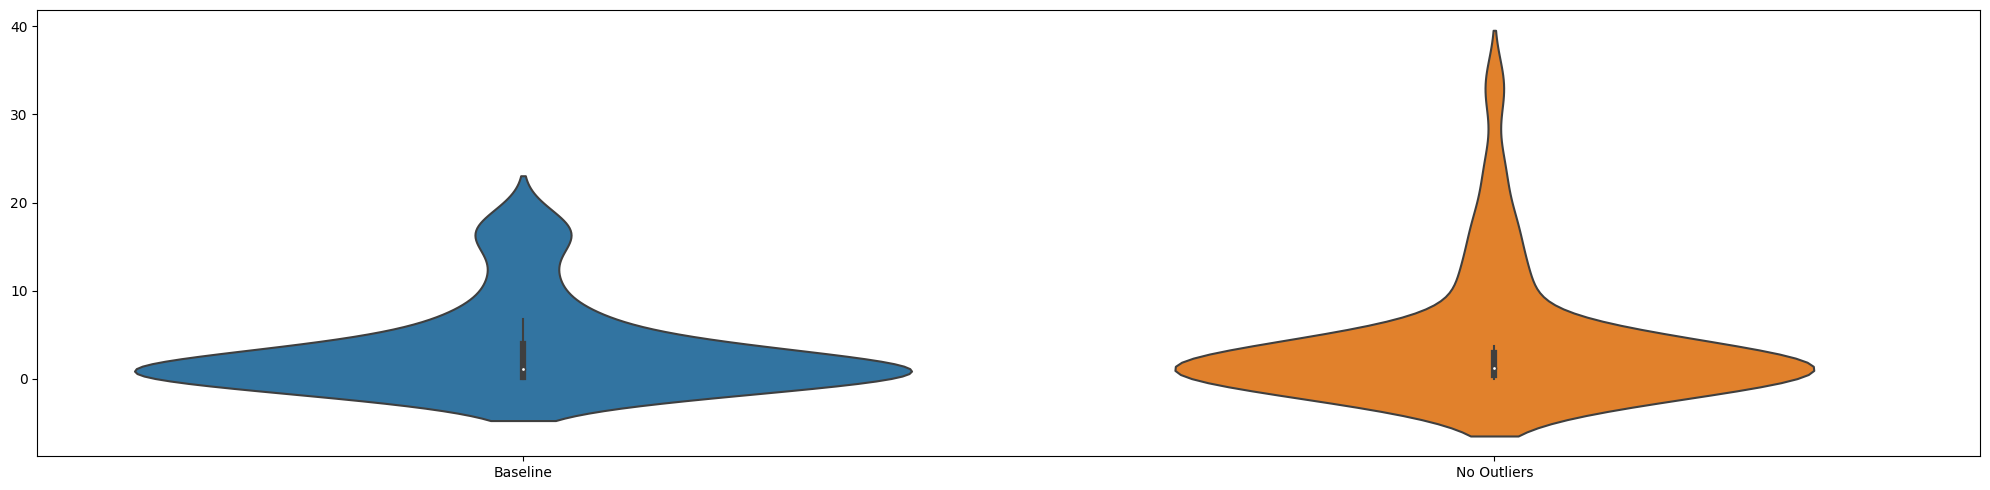

Median


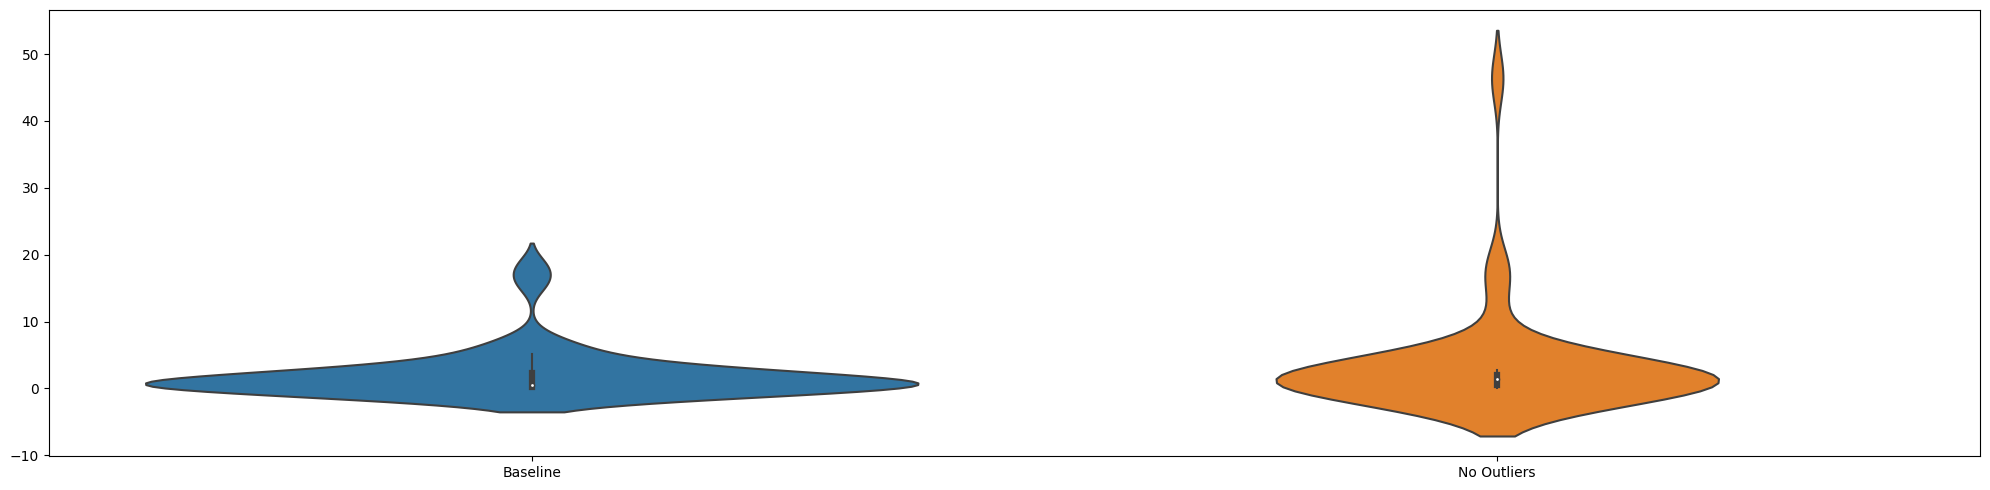

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.42 |  36.85 |   0.43 |
| Median            |   2.09 |  18.12 |   0.72 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.92 |  61.96 |  -0.29 |
| Median            |    3.2 |  67.39 |  -0.13 |

Model: XGBoost
Mean


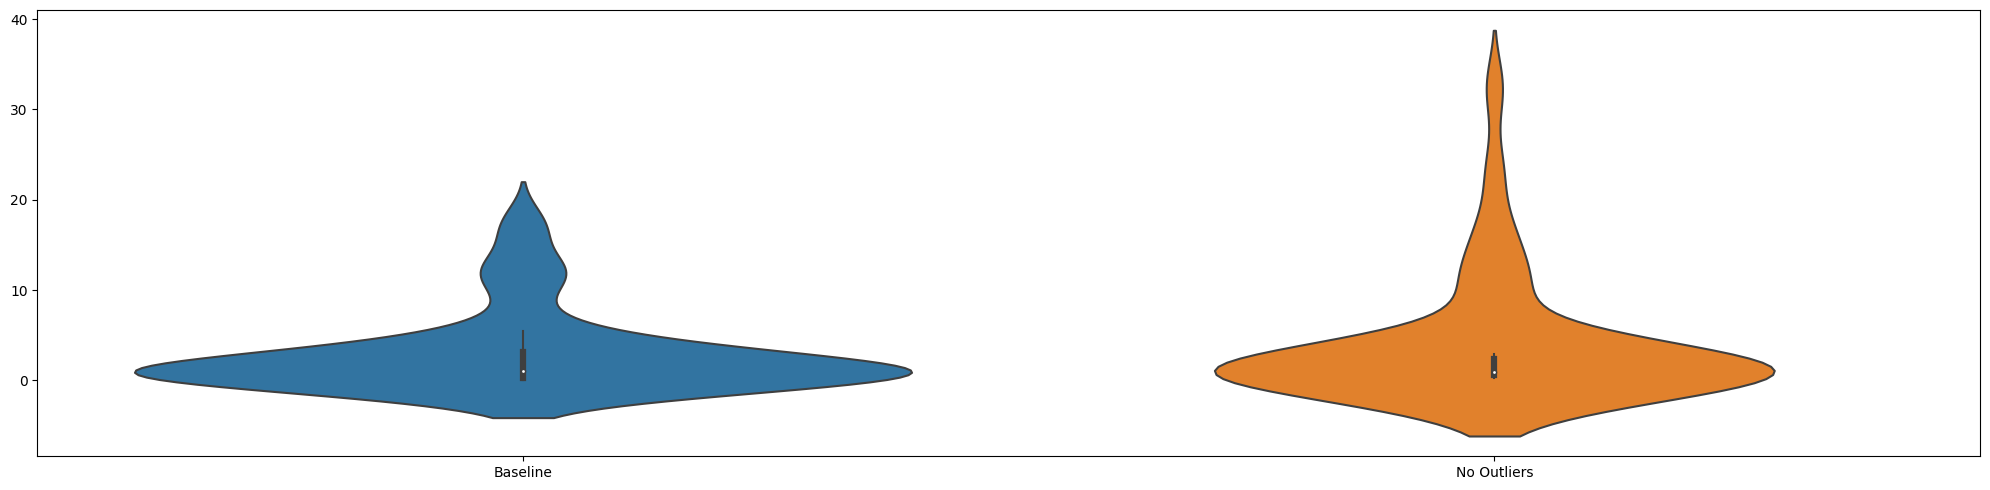

Median


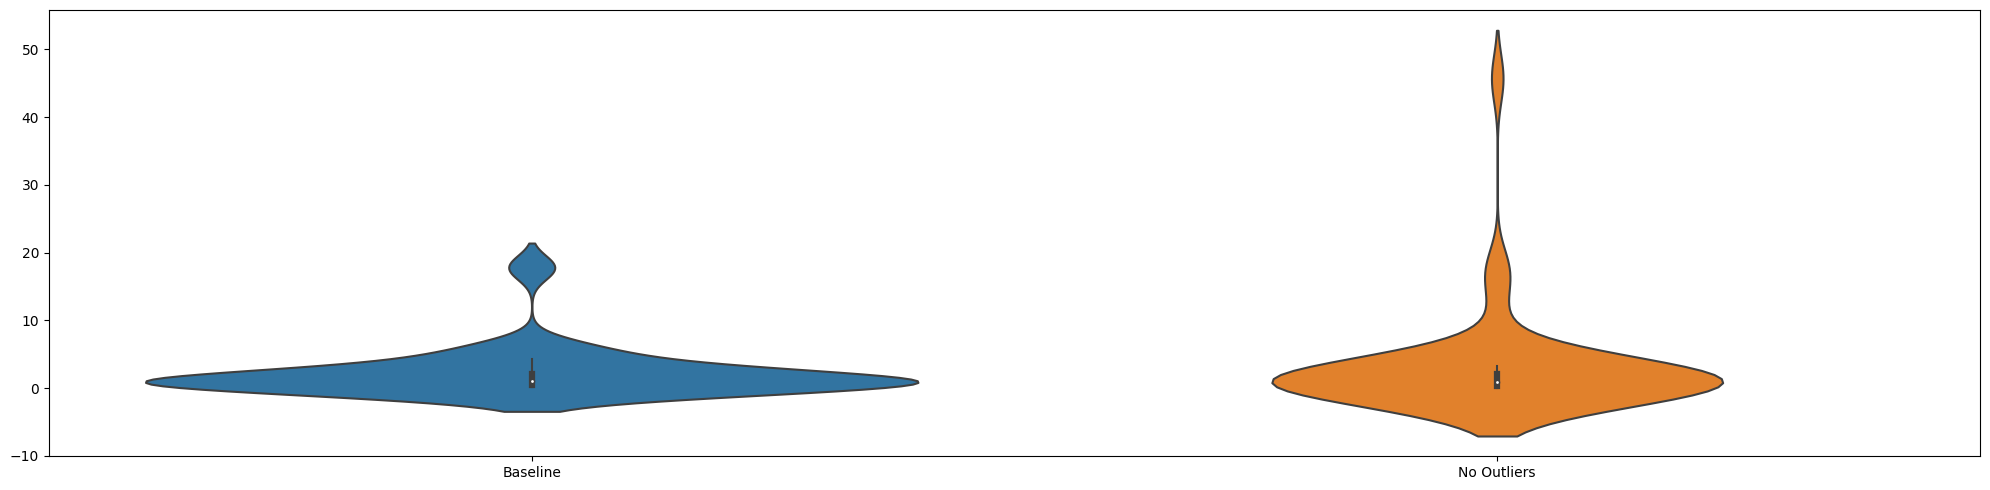

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   2.95 |  28.03 |  -0.29 |
| Median            |   2.31 |  19.48 |    0.1 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.79 |  59.47 |  -0.24 |
| Median            |   2.93 |   64.6 |  -0.08 |



In [131]:
print(f'hOPT')
missing = get_missing(df, field='hopt (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_hopt     = models_02_hopt[name].predict(missing)
    out_preds_hopt = models_out_02_hopt[name].predict(missing)
    
    print(f'Mean')
    diff_mean_preds = np.abs(preds_hopt-mean_k_preds_hopt)
    diff_mean_out_preds = np.abs(out_preds_hopt-mean_k_preds_hopt)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_hopt_{name}_mean.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_hopt_{name}_mean.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_hopt-median_k_preds_hopt)
    diff_median_out_preds = np.abs(out_preds_hopt-median_k_preds_hopt)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_hopt_{name}_median.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_hopt_{name}_median.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_hopt, mean_k_preds_hopt)
    score_mse_mean = mean_squared_error(preds_hopt, mean_k_preds_hopt)
    score_r2_mean  = r2_score(preds_hopt, mean_k_preds_hopt)
                
    score_mae_median = mean_absolute_error(preds_hopt, median_k_preds_hopt)
    score_mse_median = mean_squared_error(preds_hopt, median_k_preds_hopt)
    score_r2_median  = r2_score(preds_hopt, median_k_preds_hopt)

    # print the results
    print(f'With Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_hopt, mean_k_preds_hopt)
    score_mse_mean_out = mean_squared_error(out_preds_hopt, mean_k_preds_hopt)
    score_r2_mean_out  = r2_score(mean_k_preds_hopt, out_preds_hopt)
                
    score_mae_median_out = mean_absolute_error(out_preds_hopt, median_k_preds_hopt)
    score_mse_median_out = mean_squared_error(out_preds_hopt, median_k_preds_hopt)
    score_r2_median_out  = r2_score(median_k_preds_hopt, out_preds_hopt)

    # print the results
    print(f'Without Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

In [132]:
df_per_cluster = get_clusters_df(df, df_clustering_index, labels)

for k, dfk in enumerate(df_per_cluster):
    print(f'Cluster {i}')
    print(f'{dfk}')

Cluster 4
shape: (25, 12)
┌─────┬──────┬───────────┬──────────┬───┬────────┬────────┬──────────┬─────────┐
│ #   ┆ mat0 ┆ mat1      ┆ abs_peak ┆ … ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%) │
│ --- ┆ ---  ┆ ---       ┆ ---      ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---     │
│ i64 ┆ str  ┆ str       ┆ i64      ┆   ┆ i64    ┆ f64    ┆ f64      ┆ f64     │
╞═════╪══════╪═══════════╪══════════╪═══╪════════╪════════╪══════════╪═════════╡
│ 8   ┆ QD   ┆ solution  ┆ 800      ┆ … ┆ 1000   ┆ 30.0   ┆ 1.4      ┆ 3.2     │
│ 14  ┆ dye  ┆ solution  ┆ 466      ┆ … ┆ 900    ┆ 11.0   ┆ 0.6      ┆ null    │
│ 15  ┆ dye  ┆ solution  ┆ 557      ┆ … ┆ 900    ┆ 9.0    ┆ 0.5      ┆ null    │
│ 26  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.61    │
│ 27  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.24    │
│ 28  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.54    │
│ 29  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.41    │
│ 

Cluster: 0


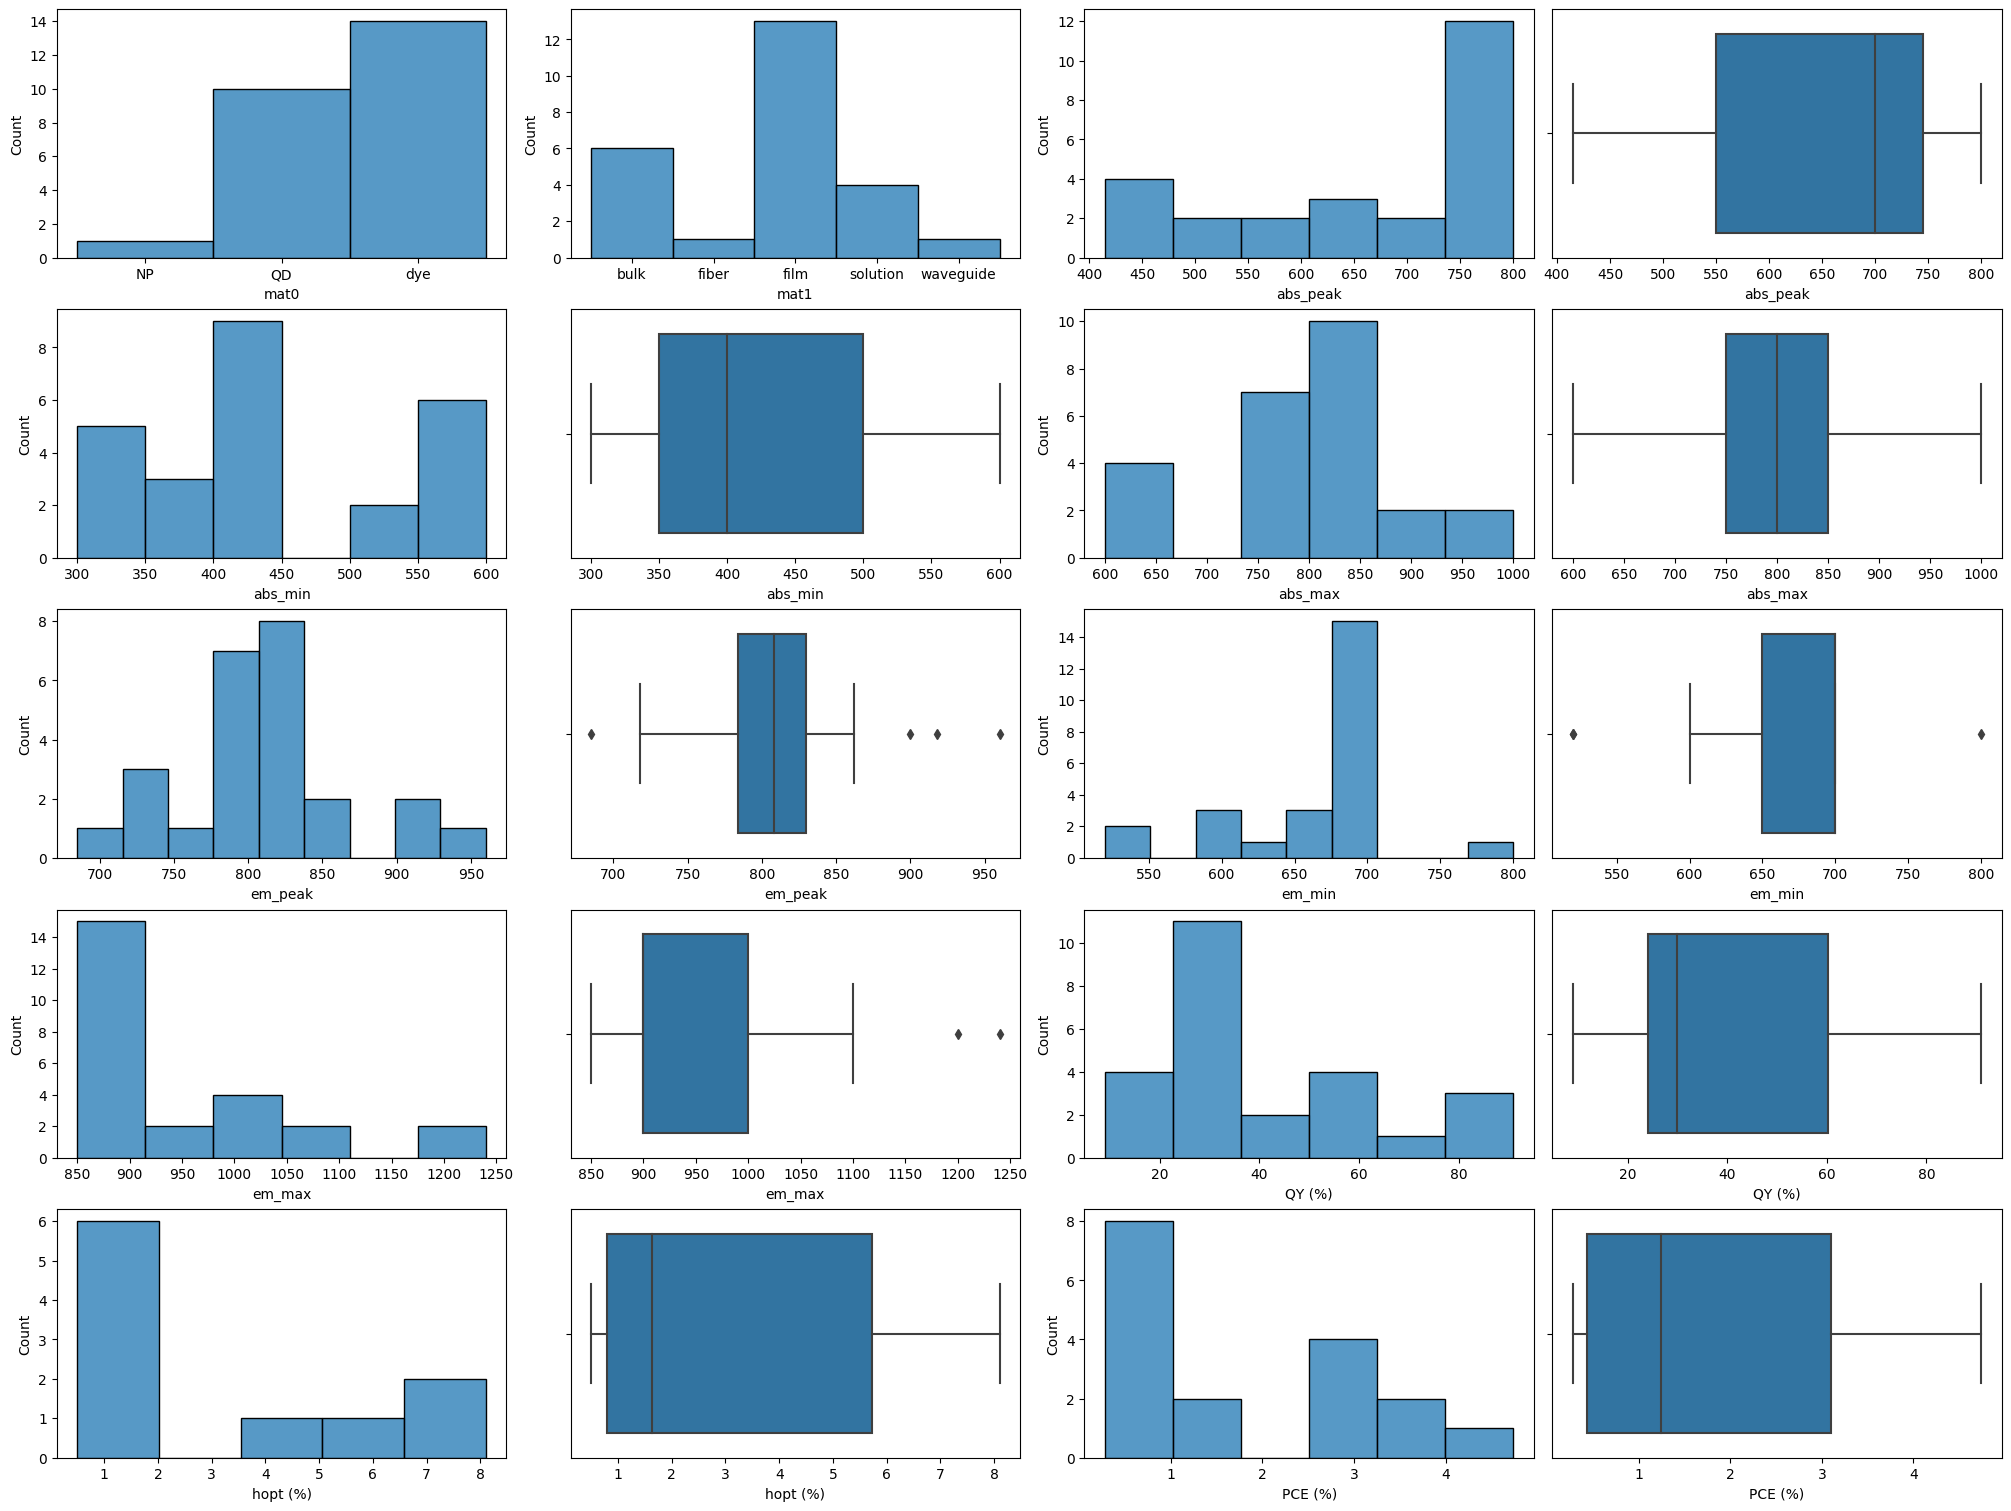

Cluster: 1


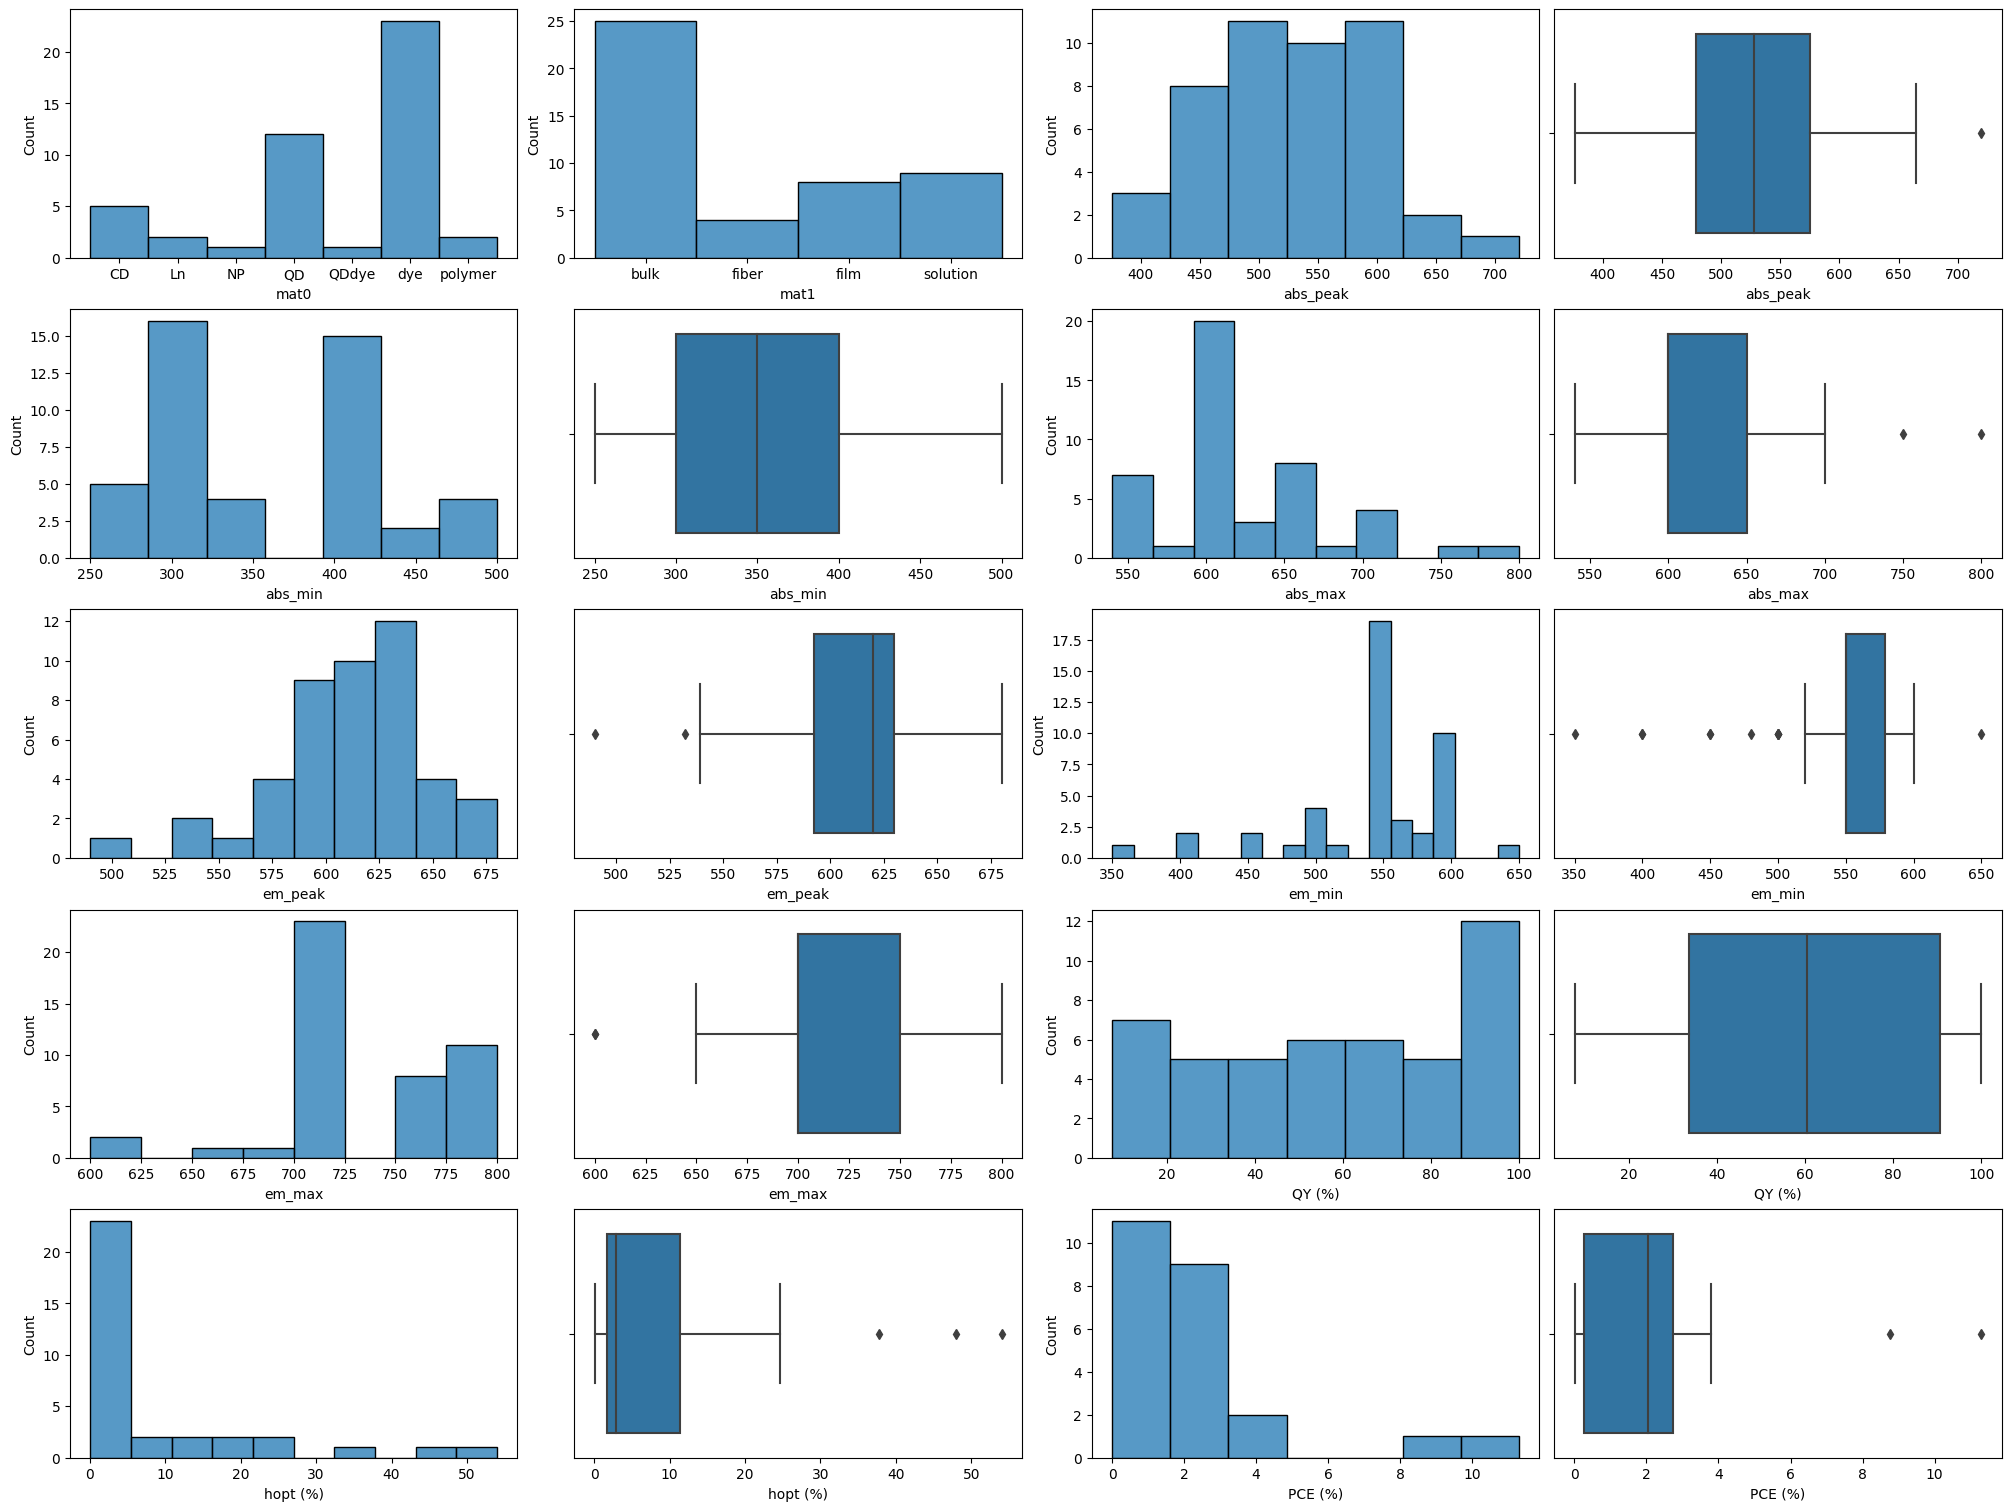

Cluster: 2


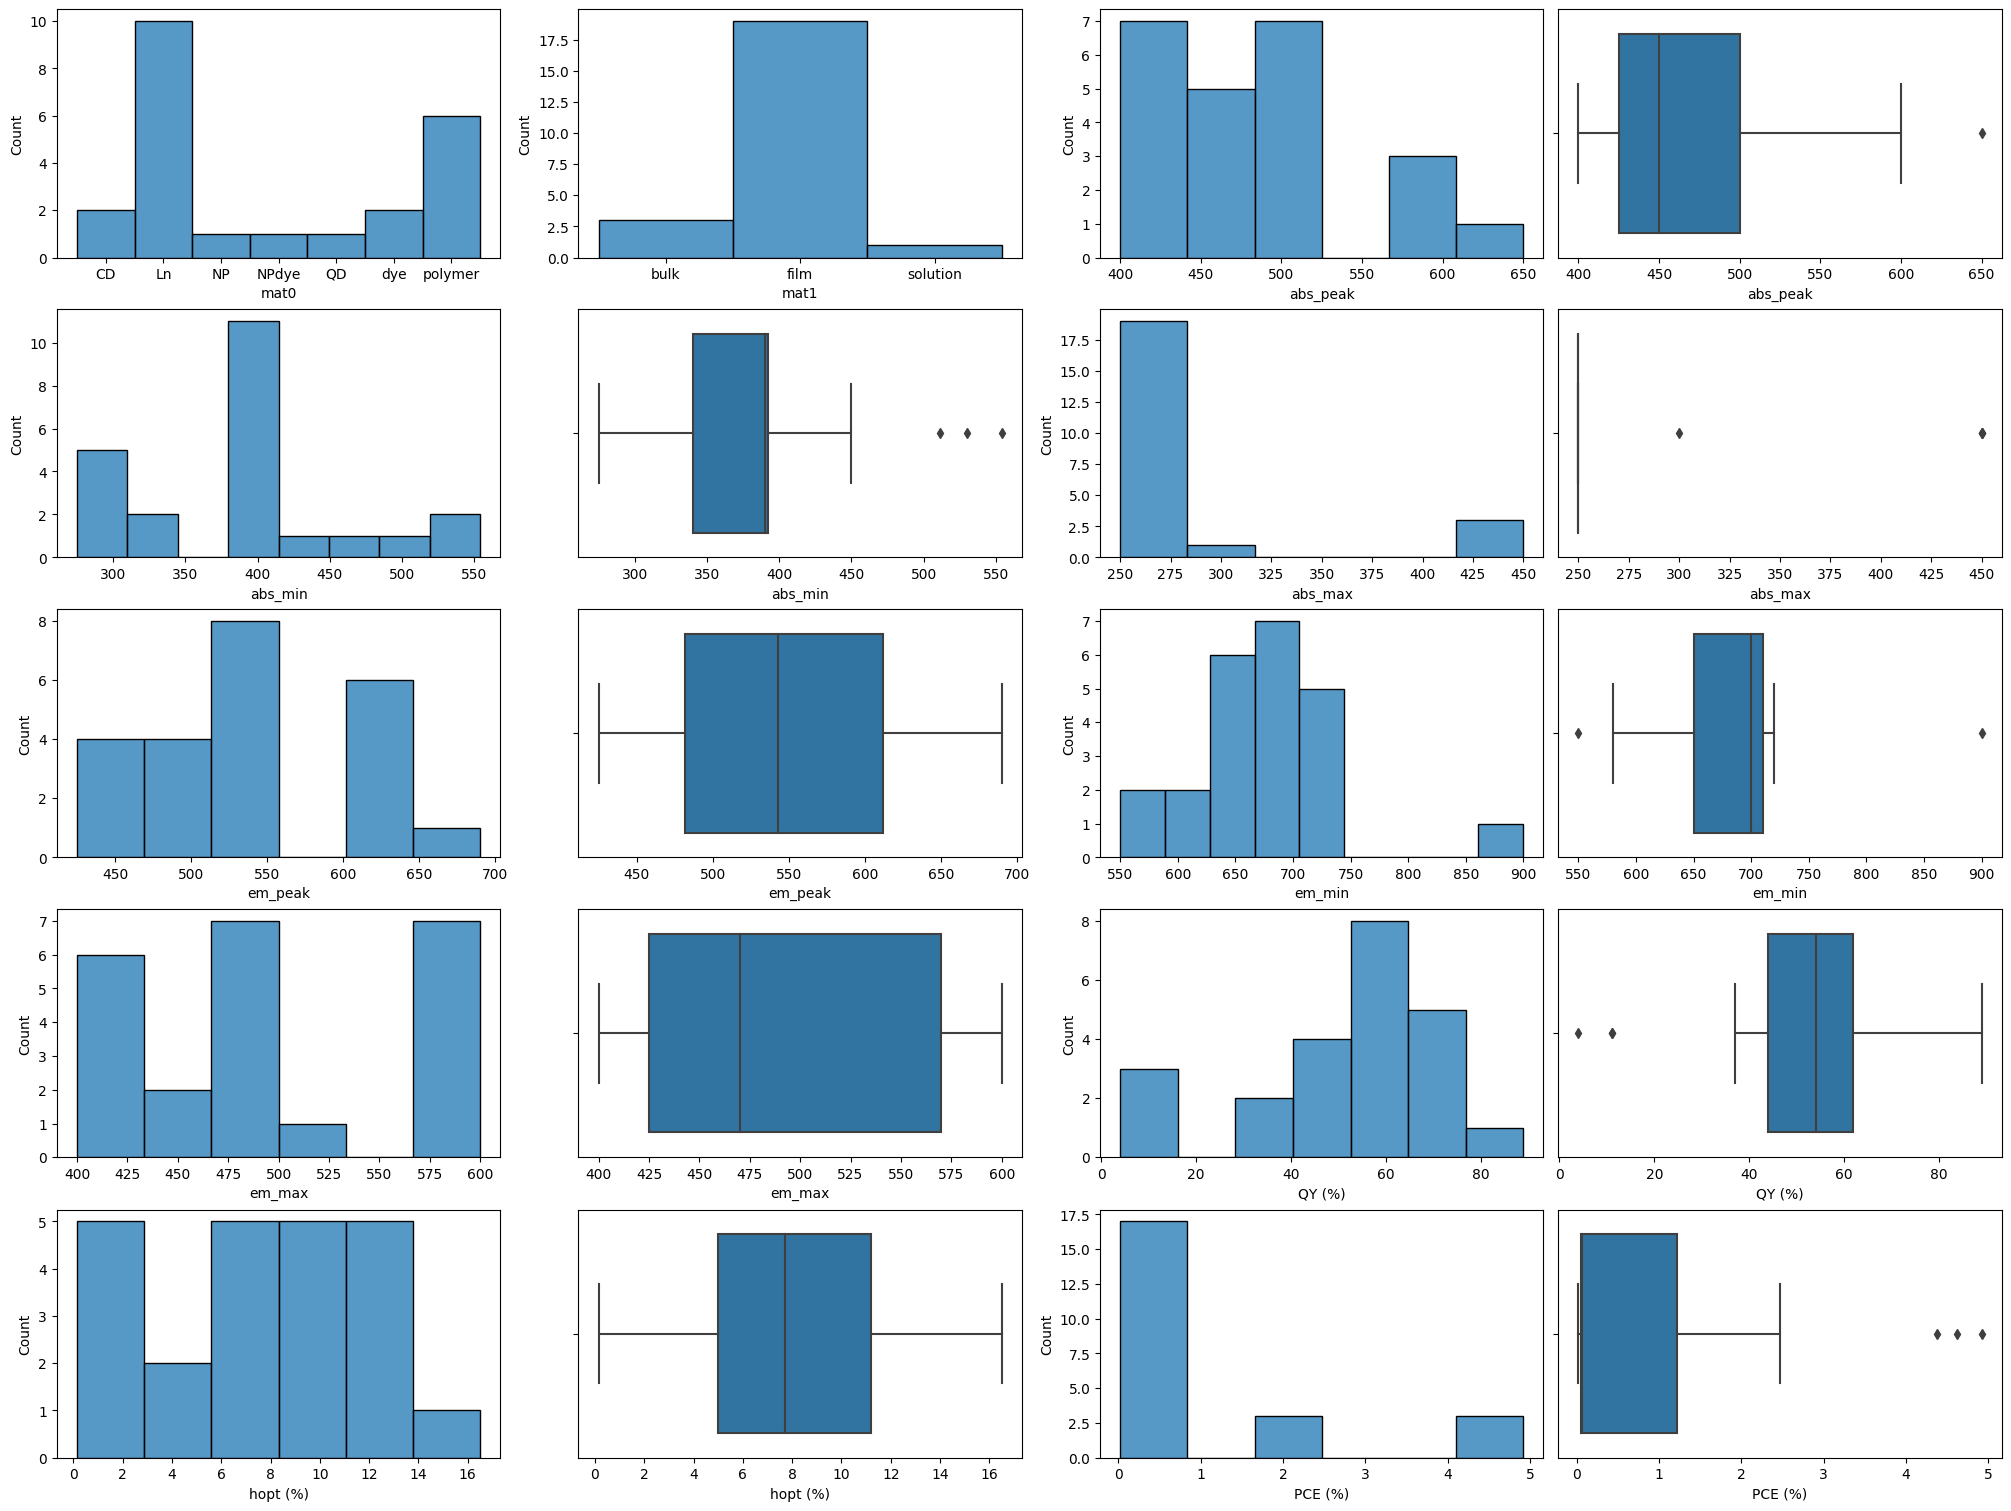

Cluster: 3


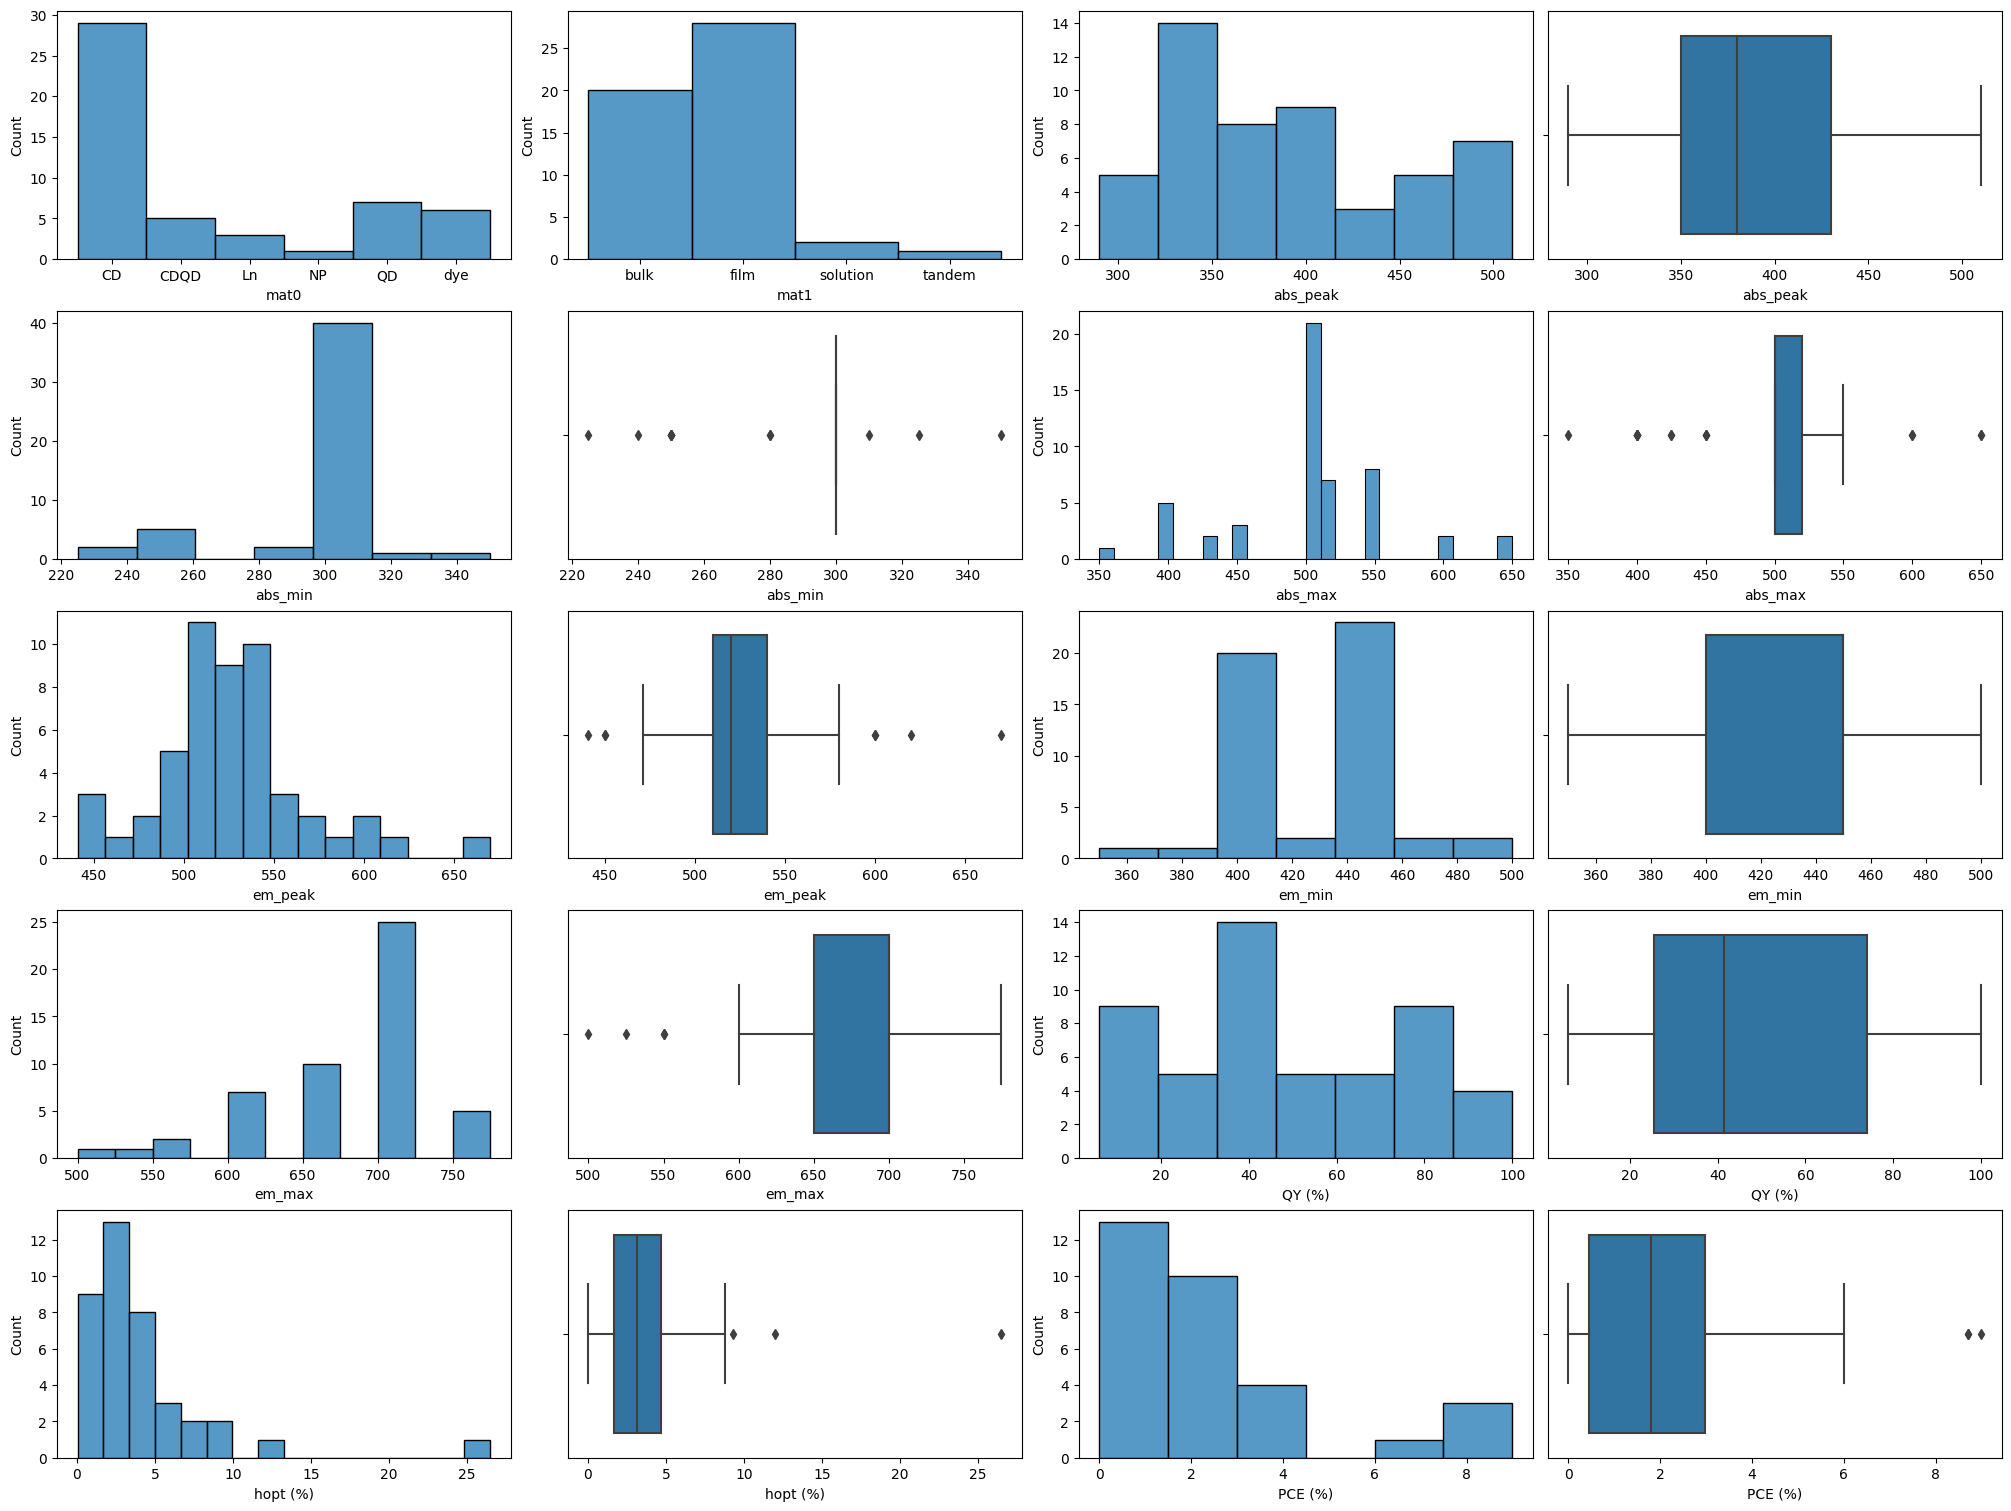

Cluster: 4


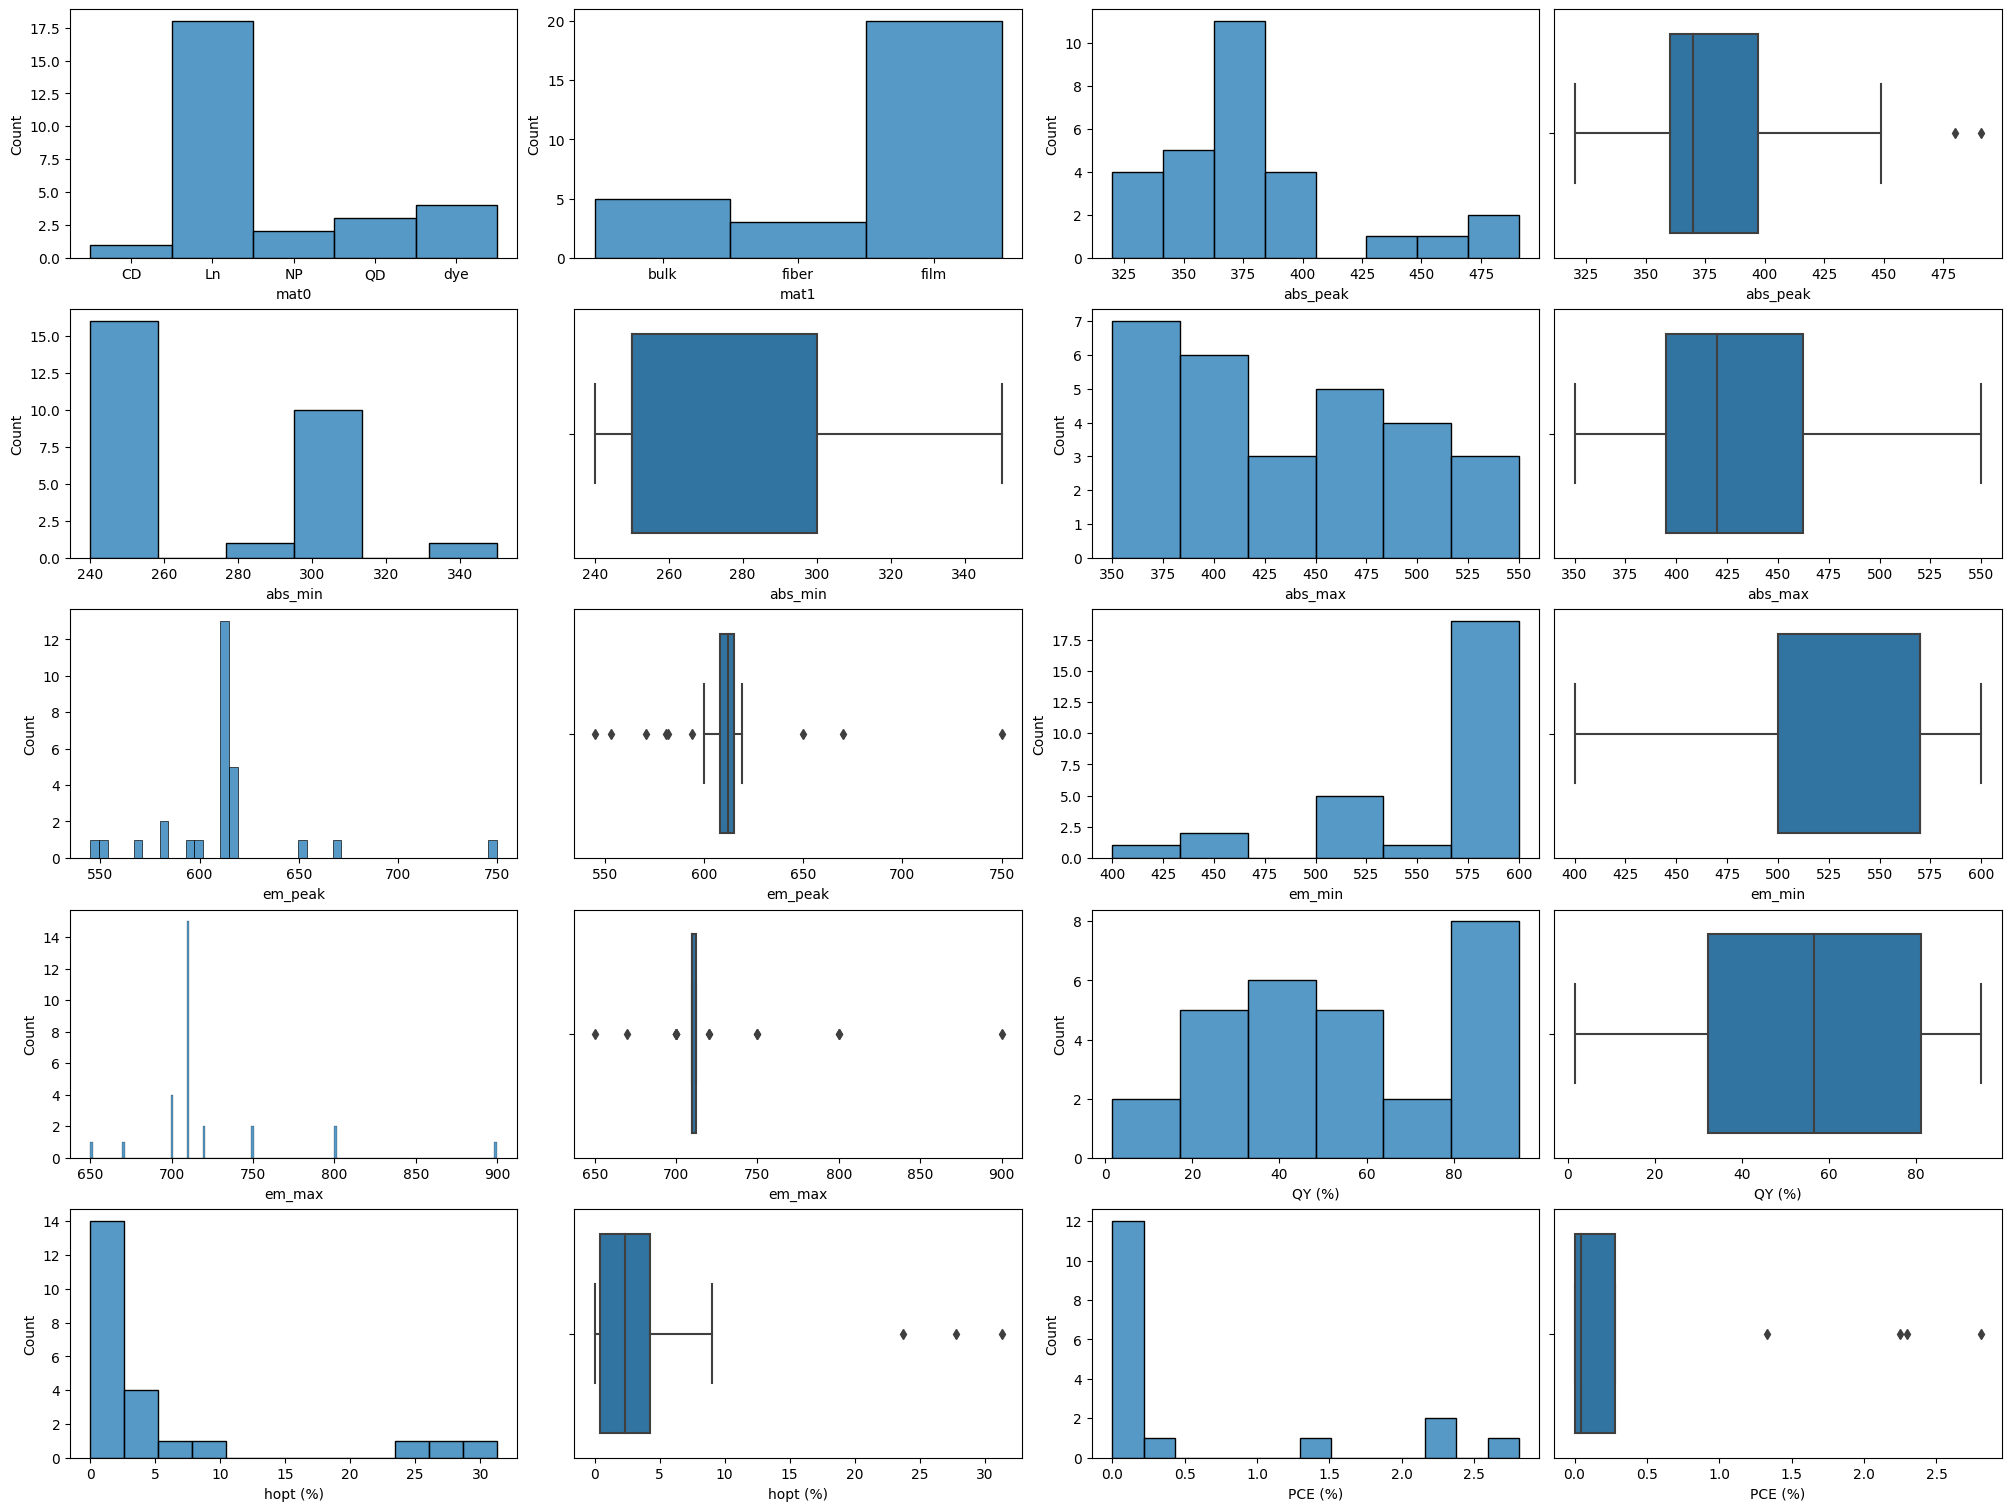

In [137]:
plot_stats_per_cluster(df, df_clustering_index, labels)

## Previous version

In [71]:
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
X

array([[3.700e+02, 3.000e+02, 4.500e+02, 6.500e+02, 4.500e+02, 7.500e+02,
        6.700e+01, 5.500e+00, 0.000e+00],
       [3.750e+02, 3.000e+02, 4.500e+02, 7.500e+02, 4.000e+02, 9.000e+02,
        4.500e+01, 4.250e+00, 1.330e+00],
       [4.800e+02, 3.000e+02, 5.000e+02, 6.190e+02, 5.700e+02, 6.700e+02,
        3.620e+01, 2.950e+00, 2.250e+00],
       [4.000e+02, 3.000e+02, 5.000e+02, 6.000e+02, 5.000e+02, 7.000e+02,
        2.500e+01, 1.850e+00, 0.000e+00],
       [4.460e+02, 2.500e+02, 5.000e+02, 5.530e+02, 5.000e+02, 8.000e+02,
        8.950e+01, 3.130e+01, 0.000e+00],
       [4.490e+02, 2.500e+02, 5.500e+02, 5.710e+02, 5.000e+02, 8.000e+02,
        8.000e+01, 2.780e+01, 0.000e+00],
       [4.910e+02, 3.000e+02, 5.000e+02, 5.810e+02, 5.500e+02, 6.500e+02,
        9.500e+01, 2.370e+01, 2.810e+00],
       [3.800e+02, 2.500e+02, 4.000e+02, 6.120e+02, 5.700e+02, 7.100e+02,
        3.050e+01, 3.400e-01, 1.900e-03],
       [3.600e+02, 2.500e+02, 3.800e+02, 5.450e+02, 4.500e+02, 7.000e+02

In [72]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[20, 3, 0, 23, 8, 7, 22, 4]
[3, 26, 19, 2, 21, 13]
[2, 1, 27, 7, 22]


In [73]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[86.  25.  67.  53.   1.6 30.5 89.  89.5]
[1.85 0.02 0.28 2.95 0.7  1.2 ]
[2.25e+00 1.33e+00 4.71e-04 1.90e-03 8.00e-02]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


In [74]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [75]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [76]:
print(f"{cost} {solution}")

49.7770480742326 (8, 59)


In [77]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[15.97727897 62.32648612 90.01184508 19.35966872 59.88768401 72.13344412
 18.33772585 46.85491737]
[12.57010428  4.919815    1.98392266 24.25932488  2.95390967  1.06247509]
[1.83368088 0.07531809 0.58336117 0.60496385 0.67724153]


In [78]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 49.875122512813185 (54.22035714285715 ± 26.58863969041543)
RMSE(HOPT): 10.008484102517194 (5.469478260869565 ± 8.892388483707826)
RMSE(PCE): 0.7493587531423203 (0.5521064117647059 ± 0.9382626018509556)


### Grid Search (optimize with test set)

In [79]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [80]:
print(f"{cost} {solution}")

0.6433135652975798 (6, 83)


In [81]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 37.75873316  80.51076649  62.08184412 143.49604739  73.47495419
  43.23225725  94.97112549  94.22130926]
[11.68839014  5.07296792  4.07583527 19.44763593  5.26625266  4.70790051]
[1.9742166  2.1266637  0.3299664  0.51122061 0.54863358]


In [82]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 48.74481047928015 (54.22035714285715 ± 26.58863969041543)
RMSE(HOPT): 8.58353842574834 (5.469478260869565 ± 8.892388483707826)
RMSE(PCE): 0.5095726953252192 (0.5521064117647059 ± 0.9382626018509556)


### Reconstruct the matrix

In [83]:
# Get the original matrix
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(28, 9)


In [84]:
X

array([[3.70000000e+02, 3.00000000e+02, 4.50000000e+02, 6.50000000e+02,
        4.50000000e+02, 7.50000000e+02, 6.70000000e+01, 5.50000000e+00,
        1.30557497e+00],
       [3.75000000e+02, 3.00000000e+02, 4.50000000e+02, 7.50000000e+02,
        4.00000000e+02, 9.00000000e+02, 4.50000000e+01, 4.25000000e+00,
        1.33000000e+00],
       [4.80000000e+02, 3.00000000e+02, 5.00000000e+02, 6.19000000e+02,
        5.70000000e+02, 6.70000000e+02, 3.62000000e+01, 2.95000000e+00,
        2.25000000e+00],
       [4.00000000e+02, 3.00000000e+02, 5.00000000e+02, 6.00000000e+02,
        5.00000000e+02, 7.00000000e+02, 2.50000000e+01, 1.85000000e+00,
        1.78174879e+00],
       [4.46000000e+02, 2.50000000e+02, 5.00000000e+02, 5.53000000e+02,
        5.00000000e+02, 8.00000000e+02, 8.95000000e+01, 3.13000000e+01,
        1.14920925e+00],
       [4.49000000e+02, 2.50000000e+02, 5.50000000e+02, 5.71000000e+02,
        5.00000000e+02, 8.00000000e+02, 8.00000000e+01, 2.78000000e+01,
        1.6

In [85]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
print(f'{field_names}')
df = pl.DataFrame({field_names[i+2]: X[:,i] for i in range(cols)})
df

['#', 'mat0', 'mat1', 'abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']


shape: (28, 9)
┌───────┬──────────┬─────────┬─────────┬───┬────────┬────────┬──────────┬──────────┐
│ mat1  ┆ abs_peak ┆ abs_min ┆ abs_max ┆ … ┆ em_min ┆ em_max ┆ QY (%)   ┆ hopt (%) │
│ ---   ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---      │
│ f64   ┆ f64      ┆ f64     ┆ f64     ┆   ┆ f64    ┆ f64    ┆ f64      ┆ f64      │
╞═══════╪══════════╪═════════╪═════════╪═══╪════════╪════════╪══════════╪══════════╡
│ 370.0 ┆ 300.0    ┆ 450.0   ┆ 650.0   ┆ … ┆ 750.0  ┆ 67.0   ┆ 5.5      ┆ 1.305575 │
│ 375.0 ┆ 300.0    ┆ 450.0   ┆ 750.0   ┆ … ┆ 900.0  ┆ 45.0   ┆ 4.25     ┆ 1.33     │
│ 480.0 ┆ 300.0    ┆ 500.0   ┆ 619.0   ┆ … ┆ 670.0  ┆ 36.2   ┆ 2.95     ┆ 2.25     │
│ 400.0 ┆ 300.0    ┆ 500.0   ┆ 600.0   ┆ … ┆ 700.0  ┆ 25.0   ┆ 1.85     ┆ 1.781749 │
│ 446.0 ┆ 250.0    ┆ 500.0   ┆ 553.0   ┆ … ┆ 800.0  ┆ 89.5   ┆ 31.3     ┆ 1.149209 │
│ 449.0 ┆ 250.0    ┆ 550.0   ┆ 571.0   ┆ … ┆ 800.0  ┆ 80.0   ┆ 27.8     ┆ 1.698677 │
│ 491.0 ┆ 300.0    ┆ 500.0   ┆ 581.0   ┆ … ┆ 650.0  ┆ 95.0   ┆ 23.7     ┆ 2.81     │
│ 380.0 ┆ 250.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 30.5   ┆ 0.34     ┆ 0.0019   │
│ 360.0 ┆ 250.0    ┆ 380.0   ┆ 545.0   ┆ … ┆ 700.0  ┆ 1.6    ┆ 0.27     ┆ 0.00078  │
│ 370.0 ┆ 290.0    ┆ 380.0   ┆ 611.0   ┆ … ┆ 710.0  ┆ 27.0   ┆ 3.2      ┆ 0.007    │
│ 350.0 ┆ 240.0    ┆ 420.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 34.0   ┆ 4.3      ┆ 0.843871 │
│ 325.0 ┆ 240.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 8.0    ┆ 1.2      ┆ 0.80881  │
│ 370.0 ┆ 240.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 63.0   ┆ 9.0      ┆ 0.413561 │
│ 370.0 ┆ 300.0    ┆ 380.0   ┆ 615.0   ┆ … ┆ 710.0  ┆ 61.0   ┆ 1.2      ┆ 0.2      │
│ 380.0 ┆ 240.0    ┆ 380.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 23.0   ┆ 0.43     ┆ 0.03     │
│ 360.0 ┆ 240.0    ┆ 380.0   ┆ 612.0   ┆ … ┆ 710.0  ┆ 30.0   ┆ 0.01     ┆ 0.0006   │
│ 360.0 ┆ 240.0    ┆ 420.0   ┆ 615.0   ┆ … ┆ 710.0  ┆ 85.0   ┆ 2.3      ┆ 0.00086  │
│ 340.0 ┆ 250.0    ┆ 380.0   ┆ 613.0   ┆ … ┆ 710.0  ┆ 44.0   ┆ 4.95153  ┆ 0.0441   │
│ 405.0 ┆ 250.0    ┆ 420.0   ┆ 613.0   ┆ … ┆ 710.0  ┆ 44.0   ┆ 5.161632 ┆ 0.0499   │
│ 350.0 ┆ 250.0    ┆ 400.0   ┆ 613.0   ┆ … ┆ 710.0  ┆ 73.0   ┆ 0.28     ┆ 0.28     │
│ 320.0 ┆ 250.0    ┆ 350.0   ┆ 613.0   ┆ … ┆ 710.0  ┆ 86.0   ┆ 6.492161 ┆ 0.122327 │
│ 370.0 ┆ 300.0    ┆ 450.0   ┆ 615.0   ┆ … ┆ 710.0  ┆ 89.0   ┆ 0.7      ┆ 0.661502 │
│ 370.0 ┆ 300.0    ┆ 450.0   ┆ 615.0   ┆ … ┆ 710.0  ┆ 89.0   ┆ 9.630443 ┆ 0.08     │
│ 396.0 ┆ 350.0    ┆ 450.0   ┆ 582.0   ┆ … ┆ 700.0  ┆ 53.0   ┆ 8.784745 ┆ 1.080106 │
│ 320.0 ┆ 300.0    ┆ 550.0   ┆ 670.0   ┆ … ┆ 700.0  ┆ 32.97  ┆ 2.55     ┆ 1.997338 │
│ 404.0 ┆ 300.0    ┆ 550.0   ┆ 594.0   ┆ … ┆ 750.0  ┆ 86.4   ┆ 2.6      ┆ 2.3      │
│ 370.0 ┆ 250.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 720.0  ┆ 60.0   ┆ 0.02     ┆ 0.000198 │
│ 370.0 ┆ 250.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 720.0  ┆ 60.0   ┆ 0.048    ┆ 0.000471 │
└───────┴──────────┴─────────┴─────────┴───┴────────┴────────┴──────────┴──────────┘